In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = r'C:\Users\andre\anaconda3\envs\miep\Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 220 

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 1 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/andre/anaconda3/envs/miep/Mask_RCNN/dataset/train/json/instances_default.json', 'C:/Users/andre/anaconda3/envs/miep/Mask_RCNN/dataset/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/andre/anaconda3/envs/miep/Mask_RCNN/dataset/val/json/instances_default.json', 'C:/Users/andre/anaconda3/envs/miep/Mask_RCNN/dataset/val/images')
dataset_val.prepare()

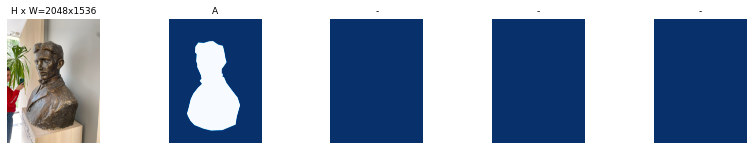

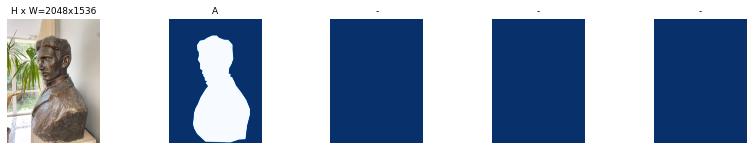

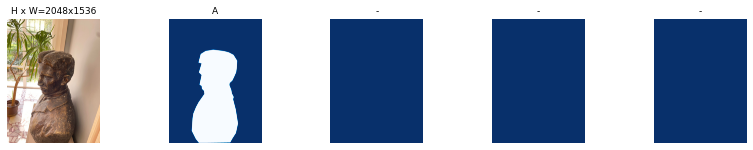

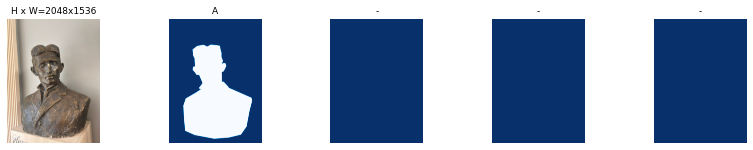

In [7]:

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\andre\anaconda3\envs\miep\Mask_RCNN\logs\cig_butts20230422T1929\mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4      

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "












Epoch 1/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 1:03:59 - loss: 21.8822 - rpn_class_loss: 12.9633 - rpn_bbox_loss: 6.8469 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 1.3354 - mrcnn_mask_loss: 0.7273

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 56:32 - loss: 20.6205 - rpn_class_loss: 13.1779 - rpn_bbox_loss: 6.4049 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.6677 - mrcnn_mask_loss: 0.3637  

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 55:50 - loss: 19.9619 - rpn_class_loss: 11.6830 - rpn_bbox_loss: 6.5855 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 1.1462 - mrcnn_mask_loss: 0.4779

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 55:08 - loss: 18.1887 - rpn_class_loss: 9.8939 - rpn_bbox_loss: 6.5364 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 1.1584 - mrcnn_mask_loss: 0.5361 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 53:47 - loss: 16.6834 - rpn_class_loss: 8.5465 - rpn_bbox_loss: 6.2210 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 1.2528 - mrcnn_mask_loss: 0.5738

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 52:45 - loss: 15.3606 - rpn_class_loss: 7.4398 - rpn_bbox_loss: 5.9171 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 1.2672 - mrcnn_mask_loss: 0.6173

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 52:29 - loss: 14.5277 - rpn_class_loss: 6.5564 - rpn_bbox_loss: 5.7537 - mrcnn_class_loss: 0.3247 - mrcnn_bbox_loss: 1.2523 - mrcnn_mask_loss: 0.6406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 52:48 - loss: 13.7214 - rpn_class_loss: 5.8508 - rpn_bbox_loss: 5.5475 - mrcnn_class_loss: 0.3525 - mrcnn_bbox_loss: 1.3080 - mrcnn_mask_loss: 0.6627

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 52:19 - loss: 13.2055 - rpn_class_loss: 5.2603 - rpn_bbox_loss: 5.5503 - mrcnn_class_loss: 0.3241 - mrcnn_bbox_loss: 1.3932 - mrcnn_mask_loss: 0.6776

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 52:10 - loss: 12.6351 - rpn_class_loss: 4.8215 - rpn_bbox_loss: 5.4235 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 1.4022 - mrcnn_mask_loss: 0.6860

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 51:34 - loss: 11.7865 - rpn_class_loss: 4.4116 - rpn_bbox_loss: 5.2021 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 1.2747 - mrcnn_mask_loss: 0.6236

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 50:28 - loss: 11.0237 - rpn_class_loss: 4.0553 - rpn_bbox_loss: 4.9767 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 1.1685 - mrcnn_mask_loss: 0.5716

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 50:10 - loss: 10.3558 - rpn_class_loss: 3.7538 - rpn_bbox_loss: 4.7634 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 1.0786 - mrcnn_mask_loss: 0.5277

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 49:39 - loss: 9.7709 - rpn_class_loss: 3.5008 - rpn_bbox_loss: 4.5629 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 1.0016 - mrcnn_mask_loss: 0.4900 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 49:14 - loss: 9.4624 - rpn_class_loss: 3.2750 - rpn_bbox_loss: 4.5940 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.9348 - mrcnn_mask_loss: 0.4573

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 48:56 - loss: 9.1158 - rpn_class_loss: 3.0730 - rpn_bbox_loss: 4.5490 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.8764 - mrcnn_mask_loss: 0.4287

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 47:42 - loss: 8.7745 - rpn_class_loss: 2.8990 - rpn_bbox_loss: 4.4695 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.8248 - mrcnn_mask_loss: 0.4035

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 47:21 - loss: 8.4713 - rpn_class_loss: 2.7391 - rpn_bbox_loss: 4.4044 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.7790 - mrcnn_mask_loss: 0.3811

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 46:56 - loss: 8.1542 - rpn_class_loss: 2.5969 - rpn_bbox_loss: 4.2994 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.7380 - mrcnn_mask_loss: 0.3610

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 46:42 - loss: 7.8578 - rpn_class_loss: 2.4710 - rpn_bbox_loss: 4.1918 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.7011 - mrcnn_mask_loss: 0.3430

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 46:32 - loss: 7.7949 - rpn_class_loss: 2.3556 - rpn_bbox_loss: 4.0485 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.8790 - mrcnn_mask_loss: 0.3681

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 46:28 - loss: 7.8054 - rpn_class_loss: 2.2510 - rpn_bbox_loss: 3.9710 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 1.0589 - mrcnn_mask_loss: 0.3872

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 46:09 - loss: 7.5513 - rpn_class_loss: 2.1535 - rpn_bbox_loss: 3.8832 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 1.0129 - mrcnn_mask_loss: 0.3704

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 45:55 - loss: 7.5166 - rpn_class_loss: 2.0659 - rpn_bbox_loss: 3.8237 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 1.1129 - mrcnn_mask_loss: 0.3883

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 45:41 - loss: 7.4580 - rpn_class_loss: 1.9857 - rpn_bbox_loss: 3.7929 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 1.1475 - mrcnn_mask_loss: 0.4111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 45:31 - loss: 7.2625 - rpn_class_loss: 1.9118 - rpn_bbox_loss: 3.7359 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 1.1034 - mrcnn_mask_loss: 0.3953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 45:19 - loss: 7.2178 - rpn_class_loss: 1.8418 - rpn_bbox_loss: 3.7129 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 1.1387 - mrcnn_mask_loss: 0.4126

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 45:05 - loss: 7.0673 - rpn_class_loss: 1.7799 - rpn_bbox_loss: 3.6836 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 1.0980 - mrcnn_mask_loss: 0.3979

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 44:53 - loss: 6.9700 - rpn_class_loss: 1.7198 - rpn_bbox_loss: 3.6248 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 1.1076 - mrcnn_mask_loss: 0.4137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 44:39 - loss: 6.9305 - rpn_class_loss: 1.6628 - rpn_bbox_loss: 3.5517 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 1.1919 - mrcnn_mask_loss: 0.4234

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 44:25 - loss: 6.8214 - rpn_class_loss: 1.6109 - rpn_bbox_loss: 3.4856 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 1.1949 - mrcnn_mask_loss: 0.4326

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 44:11 - loss: 6.7704 - rpn_class_loss: 1.5613 - rpn_bbox_loss: 3.4690 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 1.2027 - mrcnn_mask_loss: 0.4430

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 43:53 - loss: 6.7120 - rpn_class_loss: 1.5164 - rpn_bbox_loss: 3.4303 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 1.1917 - mrcnn_mask_loss: 0.4512

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 43:36 - loss: 6.6464 - rpn_class_loss: 1.4731 - rpn_bbox_loss: 3.3704 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 1.2246 - mrcnn_mask_loss: 0.4593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 43:20 - loss: 6.6128 - rpn_class_loss: 1.4315 - rpn_bbox_loss: 3.3542 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 1.2449 - mrcnn_mask_loss: 0.4665

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 42:56 - loss: 6.5441 - rpn_class_loss: 1.3926 - rpn_bbox_loss: 3.3232 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 1.2425 - mrcnn_mask_loss: 0.4733

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 42:40 - loss: 6.4758 - rpn_class_loss: 1.3561 - rpn_bbox_loss: 3.2754 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 1.2545 - mrcnn_mask_loss: 0.4803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 42:27 - loss: 6.3481 - rpn_class_loss: 1.3208 - rpn_bbox_loss: 3.2315 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 1.2215 - mrcnn_mask_loss: 0.4677

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 42:15 - loss: 6.2060 - rpn_class_loss: 1.2875 - rpn_bbox_loss: 3.1688 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 1.1902 - mrcnn_mask_loss: 0.4557

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 41:57 - loss: 6.1258 - rpn_class_loss: 1.2564 - rpn_bbox_loss: 3.1319 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 1.1743 - mrcnn_mask_loss: 0.4616

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 41:41 - loss: 6.1343 - rpn_class_loss: 1.2264 - rpn_bbox_loss: 3.0930 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 1.1626 - mrcnn_mask_loss: 0.4677

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 41:26 - loss: 6.0649 - rpn_class_loss: 1.1983 - rpn_bbox_loss: 3.0492 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 1.1636 - mrcnn_mask_loss: 0.4735

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 41:16 - loss: 6.0261 - rpn_class_loss: 1.1715 - rpn_bbox_loss: 3.0152 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 1.1723 - mrcnn_mask_loss: 0.4789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 41:03 - loss: 6.0153 - rpn_class_loss: 1.1459 - rpn_bbox_loss: 3.0033 - mrcnn_class_loss: 0.2101 - mrcnn_bbox_loss: 1.1719 - mrcnn_mask_loss: 0.4841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 40:52 - loss: 5.9799 - rpn_class_loss: 1.1216 - rpn_bbox_loss: 2.9771 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 1.1806 - mrcnn_mask_loss: 0.4895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 40:40 - loss: 5.9404 - rpn_class_loss: 1.0974 - rpn_bbox_loss: 2.9557 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 1.1837 - mrcnn_mask_loss: 0.4937

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 40:27 - loss: 5.9126 - rpn_class_loss: 1.0741 - rpn_bbox_loss: 2.9276 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 1.1973 - mrcnn_mask_loss: 0.4980

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 40:14 - loss: 5.8543 - rpn_class_loss: 1.0527 - rpn_bbox_loss: 2.9089 - mrcnn_class_loss: 0.2111 - mrcnn_bbox_loss: 1.1799 - mrcnn_mask_loss: 0.5017

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 39:59 - loss: 5.7580 - rpn_class_loss: 1.0319 - rpn_bbox_loss: 2.8720 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 1.1558 - mrcnn_mask_loss: 0.4914

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 39:34 - loss: 5.7335 - rpn_class_loss: 1.0117 - rpn_bbox_loss: 2.8452 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 1.1650 - mrcnn_mask_loss: 0.4955

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 39:16 - loss: 5.6895 - rpn_class_loss: 0.9921 - rpn_bbox_loss: 2.8082 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 1.1667 - mrcnn_mask_loss: 0.4992

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 38:59 - loss: 5.5953 - rpn_class_loss: 0.9732 - rpn_bbox_loss: 2.7693 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 1.1443 - mrcnn_mask_loss: 0.4896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 38:46 - loss: 5.5586 - rpn_class_loss: 0.9555 - rpn_bbox_loss: 2.7465 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 1.1418 - mrcnn_mask_loss: 0.4935

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 38:32 - loss: 5.5124 - rpn_class_loss: 0.9382 - rpn_bbox_loss: 2.7173 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 1.1402 - mrcnn_mask_loss: 0.4969

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 38:20 - loss: 5.4339 - rpn_class_loss: 0.9216 - rpn_bbox_loss: 2.6892 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 1.1194 - mrcnn_mask_loss: 0.4879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 38:07 - loss: 5.3828 - rpn_class_loss: 0.9057 - rpn_bbox_loss: 2.6866 - mrcnn_class_loss: 0.2119 - mrcnn_bbox_loss: 1.0995 - mrcnn_mask_loss: 0.4792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 37:51 - loss: 5.3502 - rpn_class_loss: 0.8899 - rpn_bbox_loss: 2.6701 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 1.0991 - mrcnn_mask_loss: 0.4829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 37:34 - loss: 5.2929 - rpn_class_loss: 0.8755 - rpn_bbox_loss: 2.6581 - mrcnn_class_loss: 0.2047 - mrcnn_bbox_loss: 1.0801 - mrcnn_mask_loss: 0.4745

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 37:22 - loss: 5.2765 - rpn_class_loss: 0.8608 - rpn_bbox_loss: 2.6517 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 1.0843 - mrcnn_mask_loss: 0.4780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 37:10 - loss: 5.2726 - rpn_class_loss: 0.8467 - rpn_bbox_loss: 2.6321 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 1.1138 - mrcnn_mask_loss: 0.4817

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 36:58 - loss: 5.2374 - rpn_class_loss: 0.8329 - rpn_bbox_loss: 2.6141 - mrcnn_class_loss: 0.1955 - mrcnn_bbox_loss: 1.1102 - mrcnn_mask_loss: 0.4848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 36:42 - loss: 5.2064 - rpn_class_loss: 0.8197 - rpn_bbox_loss: 2.5944 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 1.1120 - mrcnn_mask_loss: 0.4879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 36:17 - loss: 5.1555 - rpn_class_loss: 0.8074 - rpn_bbox_loss: 2.5842 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 1.0944 - mrcnn_mask_loss: 0.4802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 35:58 - loss: 5.0982 - rpn_class_loss: 0.7955 - rpn_bbox_loss: 2.5664 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 1.0773 - mrcnn_mask_loss: 0.4727

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 35:38 - loss: 5.0883 - rpn_class_loss: 0.7834 - rpn_bbox_loss: 2.5538 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 1.0830 - mrcnn_mask_loss: 0.4758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 35:26 - loss: 5.0723 - rpn_class_loss: 0.7717 - rpn_bbox_loss: 2.5462 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 1.0860 - mrcnn_mask_loss: 0.4789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 35:12 - loss: 5.0633 - rpn_class_loss: 0.7606 - rpn_bbox_loss: 2.5349 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 1.0939 - mrcnn_mask_loss: 0.4819

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 34:58 - loss: 5.0345 - rpn_class_loss: 0.7500 - rpn_bbox_loss: 2.5109 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 1.0996 - mrcnn_mask_loss: 0.4848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 34:44 - loss: 5.0000 - rpn_class_loss: 0.7397 - rpn_bbox_loss: 2.4901 - mrcnn_class_loss: 0.1867 - mrcnn_bbox_loss: 1.0962 - mrcnn_mask_loss: 0.4874

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 34:30 - loss: 4.9859 - rpn_class_loss: 0.7295 - rpn_bbox_loss: 2.4844 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 1.0978 - mrcnn_mask_loss: 0.4900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 34:17 - loss: 4.9583 - rpn_class_loss: 0.7200 - rpn_bbox_loss: 2.4672 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 1.0950 - mrcnn_mask_loss: 0.4925

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 34:02 - loss: 4.9223 - rpn_class_loss: 0.7103 - rpn_bbox_loss: 2.4487 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 1.0867 - mrcnn_mask_loss: 0.4950

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 33:49 - loss: 4.8957 - rpn_class_loss: 0.7014 - rpn_bbox_loss: 2.4320 - mrcnn_class_loss: 0.1809 - mrcnn_bbox_loss: 1.0839 - mrcnn_mask_loss: 0.4974

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 33:37 - loss: 4.8738 - rpn_class_loss: 0.6925 - rpn_bbox_loss: 2.4160 - mrcnn_class_loss: 0.1786 - mrcnn_bbox_loss: 1.0868 - mrcnn_mask_loss: 0.4998

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 33:20 - loss: 4.8502 - rpn_class_loss: 0.6839 - rpn_bbox_loss: 2.3968 - mrcnn_class_loss: 0.1774 - mrcnn_bbox_loss: 1.0899 - mrcnn_mask_loss: 0.5022

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 33:05 - loss: 4.8214 - rpn_class_loss: 0.6752 - rpn_bbox_loss: 2.3791 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 1.0837 - mrcnn_mask_loss: 0.5044

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 32:52 - loss: 4.8080 - rpn_class_loss: 0.6666 - rpn_bbox_loss: 2.3732 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 1.0834 - mrcnn_mask_loss: 0.5065

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 32:40 - loss: 4.7856 - rpn_class_loss: 0.6590 - rpn_bbox_loss: 2.3652 - mrcnn_class_loss: 0.1761 - mrcnn_bbox_loss: 1.0769 - mrcnn_mask_loss: 0.5084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 32:27 - loss: 4.7657 - rpn_class_loss: 0.6513 - rpn_bbox_loss: 2.3564 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 1.0736 - mrcnn_mask_loss: 0.5105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 32:16 - loss: 4.7259 - rpn_class_loss: 0.6435 - rpn_bbox_loss: 2.3464 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 1.0601 - mrcnn_mask_loss: 0.5041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 32:02 - loss: 4.6794 - rpn_class_loss: 0.6360 - rpn_bbox_loss: 2.3288 - mrcnn_class_loss: 0.1696 - mrcnn_bbox_loss: 1.0470 - mrcnn_mask_loss: 0.4979

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 31:50 - loss: 4.6535 - rpn_class_loss: 0.6287 - rpn_bbox_loss: 2.3113 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 1.0417 - mrcnn_mask_loss: 0.4997

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 31:37 - loss: 4.6301 - rpn_class_loss: 0.6213 - rpn_bbox_loss: 2.2948 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 1.0398 - mrcnn_mask_loss: 0.5016

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 31:20 - loss: 4.5906 - rpn_class_loss: 0.6145 - rpn_bbox_loss: 2.2825 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 1.0274 - mrcnn_mask_loss: 0.4957

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 31:05 - loss: 4.5822 - rpn_class_loss: 0.6078 - rpn_bbox_loss: 2.2749 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 1.0333 - mrcnn_mask_loss: 0.4978

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 30:51 - loss: 4.5433 - rpn_class_loss: 0.6010 - rpn_bbox_loss: 2.2626 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 1.0213 - mrcnn_mask_loss: 0.4920

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 30:37 - loss: 4.5257 - rpn_class_loss: 0.5943 - rpn_bbox_loss: 2.2490 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 1.0188 - mrcnn_mask_loss: 0.4941

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 30:23 - loss: 4.4943 - rpn_class_loss: 0.5882 - rpn_bbox_loss: 2.2322 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 1.0103 - mrcnn_mask_loss: 0.4960

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 30:05 - loss: 4.4678 - rpn_class_loss: 0.5819 - rpn_bbox_loss: 2.2149 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 1.0074 - mrcnn_mask_loss: 0.4979

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 29:52 - loss: 4.4508 - rpn_class_loss: 0.5759 - rpn_bbox_loss: 2.2055 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 1.0060 - mrcnn_mask_loss: 0.4995

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 29:39 - loss: 4.4298 - rpn_class_loss: 0.5697 - rpn_bbox_loss: 2.1865 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 1.0082 - mrcnn_mask_loss: 0.5015

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 29:25 - loss: 4.3985 - rpn_class_loss: 0.5640 - rpn_bbox_loss: 2.1792 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.9972 - mrcnn_mask_loss: 0.4960

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 29:11 - loss: 4.3857 - rpn_class_loss: 0.5584 - rpn_bbox_loss: 2.1732 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.9955 - mrcnn_mask_loss: 0.4977

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 28:52 - loss: 4.3627 - rpn_class_loss: 0.5527 - rpn_bbox_loss: 2.1605 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.9908 - mrcnn_mask_loss: 0.4995

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 28:39 - loss: 4.3480 - rpn_class_loss: 0.5469 - rpn_bbox_loss: 2.1530 - mrcnn_class_loss: 0.1590 - mrcnn_bbox_loss: 0.9880 - mrcnn_mask_loss: 0.5010

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 28:28 - loss: 4.3336 - rpn_class_loss: 0.5416 - rpn_bbox_loss: 2.1489 - mrcnn_class_loss: 0.1575 - mrcnn_bbox_loss: 0.9830 - mrcnn_mask_loss: 0.5027

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 28:14 - loss: 4.3102 - rpn_class_loss: 0.5363 - rpn_bbox_loss: 2.1357 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.9777 - mrcnn_mask_loss: 0.5043

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 28:01 - loss: 4.2862 - rpn_class_loss: 0.5312 - rpn_bbox_loss: 2.1197 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.9737 - mrcnn_mask_loss: 0.5058

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 27:47 - loss: 4.2669 - rpn_class_loss: 0.5263 - rpn_bbox_loss: 2.1079 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.9706 - mrcnn_mask_loss: 0.5072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 27:34 - loss: 4.2519 - rpn_class_loss: 0.5213 - rpn_bbox_loss: 2.1004 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.9672 - mrcnn_mask_loss: 0.5088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 27:21 - loss: 4.2284 - rpn_class_loss: 0.5165 - rpn_bbox_loss: 2.0865 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.9617 - mrcnn_mask_loss: 0.5104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 27:08 - loss: 4.2011 - rpn_class_loss: 0.5119 - rpn_bbox_loss: 2.0796 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.9523 - mrcnn_mask_loss: 0.5054

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 26:54 - loss: 4.1836 - rpn_class_loss: 0.5074 - rpn_bbox_loss: 2.0744 - mrcnn_class_loss: 0.1504 - mrcnn_bbox_loss: 0.9444 - mrcnn_mask_loss: 0.5069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 26:41 - loss: 4.1670 - rpn_class_loss: 0.5027 - rpn_bbox_loss: 2.0631 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.9438 - mrcnn_mask_loss: 0.5085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 26:26 - loss: 4.1377 - rpn_class_loss: 0.4982 - rpn_bbox_loss: 2.0534 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.9348 - mrcnn_mask_loss: 0.5037

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 26:13 - loss: 4.1290 - rpn_class_loss: 0.4938 - rpn_bbox_loss: 2.0397 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.9447 - mrcnn_mask_loss: 0.5047

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 25:58 - loss: 4.1152 - rpn_class_loss: 0.4893 - rpn_bbox_loss: 2.0301 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.9448 - mrcnn_mask_loss: 0.5062

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 25:45 - loss: 4.1117 - rpn_class_loss: 0.4849 - rpn_bbox_loss: 2.0203 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.9557 - mrcnn_mask_loss: 0.5073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 25:30 - loss: 4.1028 - rpn_class_loss: 0.4807 - rpn_bbox_loss: 2.0129 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.9587 - mrcnn_mask_loss: 0.5085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 25:13 - loss: 4.0896 - rpn_class_loss: 0.4763 - rpn_bbox_loss: 2.0041 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.9587 - mrcnn_mask_loss: 0.5096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 24:58 - loss: 4.0607 - rpn_class_loss: 0.4725 - rpn_bbox_loss: 1.9936 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.9501 - mrcnn_mask_loss: 0.5050

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 24:41 - loss: 4.0513 - rpn_class_loss: 0.4690 - rpn_bbox_loss: 1.9846 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.9537 - mrcnn_mask_loss: 0.5057

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 24:30 - loss: 4.0281 - rpn_class_loss: 0.4652 - rpn_bbox_loss: 1.9714 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.9473 - mrcnn_mask_loss: 0.5070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 24:17 - loss: 4.0266 - rpn_class_loss: 0.4614 - rpn_bbox_loss: 1.9582 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.9630 - mrcnn_mask_loss: 0.5081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 24:04 - loss: 4.0243 - rpn_class_loss: 0.4575 - rpn_bbox_loss: 1.9509 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.9701 - mrcnn_mask_loss: 0.5095

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 23:51 - loss: 4.0162 - rpn_class_loss: 0.4538 - rpn_bbox_loss: 1.9455 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.9709 - mrcnn_mask_loss: 0.5107

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 23:38 - loss: 4.0162 - rpn_class_loss: 0.4501 - rpn_bbox_loss: 1.9420 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.9759 - mrcnn_mask_loss: 0.5119

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 23:22 - loss: 4.0004 - rpn_class_loss: 0.4466 - rpn_bbox_loss: 1.9331 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.9706 - mrcnn_mask_loss: 0.5132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 23:09 - loss: 3.9911 - rpn_class_loss: 0.4430 - rpn_bbox_loss: 1.9266 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.9717 - mrcnn_mask_loss: 0.5140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 22:55 - loss: 3.9810 - rpn_class_loss: 0.4394 - rpn_bbox_loss: 1.9235 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.9676 - mrcnn_mask_loss: 0.5150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 22:41 - loss: 3.9659 - rpn_class_loss: 0.4361 - rpn_bbox_loss: 1.9144 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.9650 - mrcnn_mask_loss: 0.5161

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 22:26 - loss: 3.9521 - rpn_class_loss: 0.4326 - rpn_bbox_loss: 1.9039 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.9633 - mrcnn_mask_loss: 0.5171

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 22:10 - loss: 3.9381 - rpn_class_loss: 0.4295 - rpn_bbox_loss: 1.8944 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.9603 - mrcnn_mask_loss: 0.5183

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 21:56 - loss: 3.9259 - rpn_class_loss: 0.4262 - rpn_bbox_loss: 1.8864 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.9591 - mrcnn_mask_loss: 0.5193

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 21:43 - loss: 3.9143 - rpn_class_loss: 0.4230 - rpn_bbox_loss: 1.8800 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.9566 - mrcnn_mask_loss: 0.5203

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 21:30 - loss: 3.8958 - rpn_class_loss: 0.4200 - rpn_bbox_loss: 1.8704 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.9509 - mrcnn_mask_loss: 0.5212

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 21:17 - loss: 3.8812 - rpn_class_loss: 0.4168 - rpn_bbox_loss: 1.8624 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.9475 - mrcnn_mask_loss: 0.5220

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 20:59 - loss: 3.8662 - rpn_class_loss: 0.4137 - rpn_bbox_loss: 1.8541 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.9441 - mrcnn_mask_loss: 0.5230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 20:43 - loss: 3.8553 - rpn_class_loss: 0.4108 - rpn_bbox_loss: 1.8468 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.9418 - mrcnn_mask_loss: 0.5237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 20:29 - loss: 3.8316 - rpn_class_loss: 0.4078 - rpn_bbox_loss: 1.8384 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.9345 - mrcnn_mask_loss: 0.5197

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 20:16 - loss: 3.8197 - rpn_class_loss: 0.4049 - rpn_bbox_loss: 1.8300 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.9329 - mrcnn_mask_loss: 0.5207

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 20:03 - loss: 3.8112 - rpn_class_loss: 0.4020 - rpn_bbox_loss: 1.8279 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.9294 - mrcnn_mask_loss: 0.5216

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 19:49 - loss: 3.8017 - rpn_class_loss: 0.3990 - rpn_bbox_loss: 1.8212 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.9296 - mrcnn_mask_loss: 0.5225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 19:35 - loss: 3.7791 - rpn_class_loss: 0.3963 - rpn_bbox_loss: 1.8131 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.9226 - mrcnn_mask_loss: 0.5186

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 19:22 - loss: 3.7675 - rpn_class_loss: 0.3935 - rpn_bbox_loss: 1.8074 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.9194 - mrcnn_mask_loss: 0.5197

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 19:09 - loss: 3.7450 - rpn_class_loss: 0.3908 - rpn_bbox_loss: 1.7991 - mrcnn_class_loss: 0.1266 - mrcnn_bbox_loss: 0.9127 - mrcnn_mask_loss: 0.5159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 18:56 - loss: 3.7342 - rpn_class_loss: 0.3881 - rpn_bbox_loss: 1.7929 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.9105 - mrcnn_mask_loss: 0.5169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 18:39 - loss: 3.7221 - rpn_class_loss: 0.3854 - rpn_bbox_loss: 1.7840 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.9099 - mrcnn_mask_loss: 0.5179

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 18:26 - loss: 3.7104 - rpn_class_loss: 0.3827 - rpn_bbox_loss: 1.7765 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.9083 - mrcnn_mask_loss: 0.5187

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 18:13 - loss: 3.6972 - rpn_class_loss: 0.3803 - rpn_bbox_loss: 1.7683 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.9055 - mrcnn_mask_loss: 0.5197

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 17:59 - loss: 3.6814 - rpn_class_loss: 0.3777 - rpn_bbox_loss: 1.7593 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.9013 - mrcnn_mask_loss: 0.5206

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 17:45 - loss: 3.6691 - rpn_class_loss: 0.3754 - rpn_bbox_loss: 1.7532 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.8972 - mrcnn_mask_loss: 0.5214

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 17:29 - loss: 3.6572 - rpn_class_loss: 0.3730 - rpn_bbox_loss: 1.7473 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.8936 - mrcnn_mask_loss: 0.5223

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 17:15 - loss: 3.6440 - rpn_class_loss: 0.3709 - rpn_bbox_loss: 1.7376 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.8924 - mrcnn_mask_loss: 0.5229

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 17:01 - loss: 3.6347 - rpn_class_loss: 0.3686 - rpn_bbox_loss: 1.7319 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.8913 - mrcnn_mask_loss: 0.5234

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 16:48 - loss: 3.6254 - rpn_class_loss: 0.3663 - rpn_bbox_loss: 1.7271 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.8891 - mrcnn_mask_loss: 0.5241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 16:33 - loss: 3.6197 - rpn_class_loss: 0.3640 - rpn_bbox_loss: 1.7235 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.8891 - mrcnn_mask_loss: 0.5250

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 16:19 - loss: 3.6068 - rpn_class_loss: 0.3618 - rpn_bbox_loss: 1.7148 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.8870 - mrcnn_mask_loss: 0.5258

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 16:06 - loss: 3.6002 - rpn_class_loss: 0.3595 - rpn_bbox_loss: 1.7122 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.8852 - mrcnn_mask_loss: 0.5266

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 15:53 - loss: 3.5940 - rpn_class_loss: 0.3573 - rpn_bbox_loss: 1.7096 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.8828 - mrcnn_mask_loss: 0.5275

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 15:39 - loss: 3.5836 - rpn_class_loss: 0.3551 - rpn_bbox_loss: 1.7046 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.8795 - mrcnn_mask_loss: 0.5282

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 15:26 - loss: 3.5721 - rpn_class_loss: 0.3530 - rpn_bbox_loss: 1.6973 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.8769 - mrcnn_mask_loss: 0.5290

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 15:12 - loss: 3.5691 - rpn_class_loss: 0.3507 - rpn_bbox_loss: 1.6936 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.8790 - mrcnn_mask_loss: 0.5295

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 14:59 - loss: 3.5582 - rpn_class_loss: 0.3486 - rpn_bbox_loss: 1.6879 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.8752 - mrcnn_mask_loss: 0.5302

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 14:45 - loss: 3.5519 - rpn_class_loss: 0.3465 - rpn_bbox_loss: 1.6847 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.8736 - mrcnn_mask_loss: 0.5308

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 14:31 - loss: 3.5392 - rpn_class_loss: 0.3444 - rpn_bbox_loss: 1.6763 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.8713 - mrcnn_mask_loss: 0.5315

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 14:18 - loss: 3.5270 - rpn_class_loss: 0.3424 - rpn_bbox_loss: 1.6690 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.8683 - mrcnn_mask_loss: 0.5322

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 14:04 - loss: 3.5142 - rpn_class_loss: 0.3403 - rpn_bbox_loss: 1.6627 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.8640 - mrcnn_mask_loss: 0.5328

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 13:50 - loss: 3.5043 - rpn_class_loss: 0.3384 - rpn_bbox_loss: 1.6573 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.8611 - mrcnn_mask_loss: 0.5333

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 13:36 - loss: 3.4931 - rpn_class_loss: 0.3364 - rpn_bbox_loss: 1.6492 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.8596 - mrcnn_mask_loss: 0.5339

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 13:23 - loss: 3.4819 - rpn_class_loss: 0.3345 - rpn_bbox_loss: 1.6408 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.8583 - mrcnn_mask_loss: 0.5345

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 13:09 - loss: 3.4742 - rpn_class_loss: 0.3325 - rpn_bbox_loss: 1.6362 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.8569 - mrcnn_mask_loss: 0.5353

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 12:54 - loss: 3.4643 - rpn_class_loss: 0.3307 - rpn_bbox_loss: 1.6304 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.8543 - mrcnn_mask_loss: 0.5359

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 12:41 - loss: 3.4561 - rpn_class_loss: 0.3288 - rpn_bbox_loss: 1.6263 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.8519 - mrcnn_mask_loss: 0.5363

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 12:27 - loss: 3.4436 - rpn_class_loss: 0.3269 - rpn_bbox_loss: 1.6195 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.8481 - mrcnn_mask_loss: 0.5370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 12:13 - loss: 3.4376 - rpn_class_loss: 0.3250 - rpn_bbox_loss: 1.6169 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.8459 - mrcnn_mask_loss: 0.5376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 11:59 - loss: 3.4259 - rpn_class_loss: 0.3232 - rpn_bbox_loss: 1.6105 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.8417 - mrcnn_mask_loss: 0.5381

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 11:46 - loss: 3.4187 - rpn_class_loss: 0.3215 - rpn_bbox_loss: 1.6076 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.8389 - mrcnn_mask_loss: 0.5387

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 11:33 - loss: 3.4069 - rpn_class_loss: 0.3198 - rpn_bbox_loss: 1.6002 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.8358 - mrcnn_mask_loss: 0.5392

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 11:19 - loss: 3.3980 - rpn_class_loss: 0.3180 - rpn_bbox_loss: 1.5949 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.8340 - mrcnn_mask_loss: 0.5395

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 11:05 - loss: 3.3886 - rpn_class_loss: 0.3162 - rpn_bbox_loss: 1.5882 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.8332 - mrcnn_mask_loss: 0.5399

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 10:51 - loss: 3.3837 - rpn_class_loss: 0.3145 - rpn_bbox_loss: 1.5854 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.8328 - mrcnn_mask_loss: 0.5404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 10:38 - loss: 3.3773 - rpn_class_loss: 0.3128 - rpn_bbox_loss: 1.5819 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.8308 - mrcnn_mask_loss: 0.5408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 10:24 - loss: 3.3661 - rpn_class_loss: 0.3111 - rpn_bbox_loss: 1.5748 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.8286 - mrcnn_mask_loss: 0.5409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 10:10 - loss: 3.3597 - rpn_class_loss: 0.3094 - rpn_bbox_loss: 1.5721 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.8267 - mrcnn_mask_loss: 0.5414

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 9:57 - loss: 3.3535 - rpn_class_loss: 0.3080 - rpn_bbox_loss: 1.5698 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.8240 - mrcnn_mask_loss: 0.5416 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 9:43 - loss: 3.3478 - rpn_class_loss: 0.3064 - rpn_bbox_loss: 1.5676 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.8221 - mrcnn_mask_loss: 0.5421

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 9:30 - loss: 3.3387 - rpn_class_loss: 0.3047 - rpn_bbox_loss: 1.5616 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.8197 - mrcnn_mask_loss: 0.5425

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 9:16 - loss: 3.3279 - rpn_class_loss: 0.3031 - rpn_bbox_loss: 1.5548 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.8173 - mrcnn_mask_loss: 0.5429

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 9:03 - loss: 3.3214 - rpn_class_loss: 0.3016 - rpn_bbox_loss: 1.5519 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.8147 - mrcnn_mask_loss: 0.5433

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 8:50 - loss: 3.3148 - rpn_class_loss: 0.3001 - rpn_bbox_loss: 1.5480 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.8130 - mrcnn_mask_loss: 0.5437

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 8:36 - loss: 3.3099 - rpn_class_loss: 0.2987 - rpn_bbox_loss: 1.5468 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.8103 - mrcnn_mask_loss: 0.5442

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 8:22 - loss: 3.3030 - rpn_class_loss: 0.2972 - rpn_bbox_loss: 1.5438 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.8079 - mrcnn_mask_loss: 0.5446

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 8:09 - loss: 3.2975 - rpn_class_loss: 0.2957 - rpn_bbox_loss: 1.5410 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.8063 - mrcnn_mask_loss: 0.5451

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 7:56 - loss: 3.2908 - rpn_class_loss: 0.2941 - rpn_bbox_loss: 1.5394 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.8030 - mrcnn_mask_loss: 0.5454

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 7:42 - loss: 3.2819 - rpn_class_loss: 0.2926 - rpn_bbox_loss: 1.5350 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.8001 - mrcnn_mask_loss: 0.5458

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 7:29 - loss: 3.2750 - rpn_class_loss: 0.2912 - rpn_bbox_loss: 1.5315 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.7983 - mrcnn_mask_loss: 0.5461

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 7:15 - loss: 3.2681 - rpn_class_loss: 0.2898 - rpn_bbox_loss: 1.5278 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.7959 - mrcnn_mask_loss: 0.5465

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 7:02 - loss: 3.2553 - rpn_class_loss: 0.2884 - rpn_bbox_loss: 1.5242 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.7917 - mrcnn_mask_loss: 0.5436

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 6:48 - loss: 3.2399 - rpn_class_loss: 0.2869 - rpn_bbox_loss: 1.5178 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.7875 - mrcnn_mask_loss: 0.5408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 6:35 - loss: 3.2352 - rpn_class_loss: 0.2855 - rpn_bbox_loss: 1.5157 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.7862 - mrcnn_mask_loss: 0.5410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 6:21 - loss: 3.2275 - rpn_class_loss: 0.2841 - rpn_bbox_loss: 1.5124 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.7832 - mrcnn_mask_loss: 0.5415

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 6:08 - loss: 3.2169 - rpn_class_loss: 0.2828 - rpn_bbox_loss: 1.5056 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.7809 - mrcnn_mask_loss: 0.5419

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 5:53 - loss: 3.2120 - rpn_class_loss: 0.2814 - rpn_bbox_loss: 1.5041 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.7793 - mrcnn_mask_loss: 0.5419

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 5:40 - loss: 3.2084 - rpn_class_loss: 0.2800 - rpn_bbox_loss: 1.5031 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.7775 - mrcnn_mask_loss: 0.5423

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 5:26 - loss: 3.2031 - rpn_class_loss: 0.2787 - rpn_bbox_loss: 1.4995 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.7767 - mrcnn_mask_loss: 0.5427

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 5:12 - loss: 3.1967 - rpn_class_loss: 0.2774 - rpn_bbox_loss: 1.4966 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.7744 - mrcnn_mask_loss: 0.5431

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 4:59 - loss: 3.1889 - rpn_class_loss: 0.2763 - rpn_bbox_loss: 1.4923 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.7718 - mrcnn_mask_loss: 0.5435

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 4:45 - loss: 3.1781 - rpn_class_loss: 0.2750 - rpn_bbox_loss: 1.4859 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.7688 - mrcnn_mask_loss: 0.5438

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 4:31 - loss: 3.1708 - rpn_class_loss: 0.2737 - rpn_bbox_loss: 1.4820 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.7666 - mrcnn_mask_loss: 0.5444

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 4:18 - loss: 3.1630 - rpn_class_loss: 0.2724 - rpn_bbox_loss: 1.4779 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.7644 - mrcnn_mask_loss: 0.5446

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 4:04 - loss: 3.1536 - rpn_class_loss: 0.2710 - rpn_bbox_loss: 1.4718 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.7621 - mrcnn_mask_loss: 0.5448

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 3:51 - loss: 3.1474 - rpn_class_loss: 0.2698 - rpn_bbox_loss: 1.4678 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.7608 - mrcnn_mask_loss: 0.5453

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 3:37 - loss: 3.1400 - rpn_class_loss: 0.2685 - rpn_bbox_loss: 1.4635 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.7586 - mrcnn_mask_loss: 0.5456

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 3:24 - loss: 3.1331 - rpn_class_loss: 0.2674 - rpn_bbox_loss: 1.4592 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.7567 - mrcnn_mask_loss: 0.5457

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 3:10 - loss: 3.1273 - rpn_class_loss: 0.2662 - rpn_bbox_loss: 1.4562 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.7551 - mrcnn_mask_loss: 0.5460

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 2:57 - loss: 3.1189 - rpn_class_loss: 0.2650 - rpn_bbox_loss: 1.4511 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.7529 - mrcnn_mask_loss: 0.5464

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 2:43 - loss: 3.1122 - rpn_class_loss: 0.2638 - rpn_bbox_loss: 1.4474 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.7510 - mrcnn_mask_loss: 0.5466

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 2:29 - loss: 3.1065 - rpn_class_loss: 0.2626 - rpn_bbox_loss: 1.4433 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.7493 - mrcnn_mask_loss: 0.5470

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 2:16 - loss: 3.1004 - rpn_class_loss: 0.2614 - rpn_bbox_loss: 1.4398 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.7469 - mrcnn_mask_loss: 0.5473

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 2:02 - loss: 3.0937 - rpn_class_loss: 0.2602 - rpn_bbox_loss: 1.4353 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.7453 - mrcnn_mask_loss: 0.5476

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 1:48 - loss: 3.0873 - rpn_class_loss: 0.2591 - rpn_bbox_loss: 1.4321 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.7433 - mrcnn_mask_loss: 0.5480

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 1:35 - loss: 3.0835 - rpn_class_loss: 0.2580 - rpn_bbox_loss: 1.4296 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.7429 - mrcnn_mask_loss: 0.5482

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 1:21 - loss: 3.0796 - rpn_class_loss: 0.2569 - rpn_bbox_loss: 1.4275 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.7420 - mrcnn_mask_loss: 0.5485

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 1:08 - loss: 3.0746 - rpn_class_loss: 0.2558 - rpn_bbox_loss: 1.4244 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.7411 - mrcnn_mask_loss: 0.5488

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 54s - loss: 3.0673 - rpn_class_loss: 0.2547 - rpn_bbox_loss: 1.4200 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.7390 - mrcnn_mask_loss: 0.5491 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 40s - loss: 3.0560 - rpn_class_loss: 0.2536 - rpn_bbox_loss: 1.4163 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.7356 - mrcnn_mask_loss: 0.5466

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 27s - loss: 3.0538 - rpn_class_loss: 0.2526 - rpn_bbox_loss: 1.4154 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.7352 - mrcnn_mask_loss: 0.5469

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 13s - loss: 3.0483 - rpn_class_loss: 0.2515 - rpn_bbox_loss: 1.4135 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.7329 - mrcnn_mask_loss: 0.5471

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 3029s 14s/step - loss: 3.0471 - rpn_class_loss: 0.2503 - rpn_bbox_loss: 1.4147 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.7318 - mrcnn_mask_loss: 0.5471 - val_loss: 2.1213 - val_rpn_class_loss: 0.0212 - val_rpn_bbox_loss: 1.1412 - val_mrcnn_class_loss: 0.0277 - val_mrcnn_bbox_loss: 0.3402 - val_mrcnn_mask_loss: 0.5909

Epoch 2/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 54:53 - loss: 2.0943 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 1.2871 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.5864

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 52:46 - loss: 2.1992 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.2547 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.5734

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 51:24 - loss: 1.9604 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.9925 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.5891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 50:20 - loss: 1.8230 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8573 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.5918

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 49:51 - loss: 1.9047 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8505 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.5915

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 48:51 - loss: 1.8877 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.8246 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.3507 - mrcnn_mask_loss: 0.5956

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 48:18 - loss: 1.8387 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8023 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.3434 - mrcnn_mask_loss: 0.5914

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 48:03 - loss: 1.8956 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.8369 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.3799 - mrcnn_mask_loss: 0.5849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 48:03 - loss: 1.9214 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.8511 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.5840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 47:33 - loss: 1.8970 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8388 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.5860

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 46:57 - loss: 1.8625 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8060 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.3735 - mrcnn_mask_loss: 0.5853

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 46:43 - loss: 1.8511 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7823 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.3766 - mrcnn_mask_loss: 0.5858

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 46:36 - loss: 1.8230 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7626 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.5838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 46:27 - loss: 1.7840 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7321 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.5844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 46:21 - loss: 1.8365 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7592 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.5857

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 5:07:53 - loss: 1.7991 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7246 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.3808 - mrcnn_mask_loss: 0.5871

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 4:49:42 - loss: 1.7804 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7181 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.5887

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 4:34:50 - loss: 1.7522 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6947 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.3668 - mrcnn_mask_loss: 0.5882

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 4:21:37 - loss: 1.7604 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7087 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.5877

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 4:09:31 - loss: 1.7492 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.6998 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.3636 - mrcnn_mask_loss: 0.5887

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 3:58:23 - loss: 1.7564 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7155 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.5890

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 3:48:35 - loss: 1.7630 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7167 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.3634 - mrcnn_mask_loss: 0.5877

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 3:39:30 - loss: 1.7409 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7009 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.5891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 3:31:10 - loss: 1.7333 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.6981 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.5879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 3:23:30 - loss: 1.7221 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6854 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.3569 - mrcnn_mask_loss: 0.5878

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 3:16:24 - loss: 1.7016 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.6695 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.5877

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 3:09:44 - loss: 1.6932 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.6527 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3498 - mrcnn_mask_loss: 0.5869

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 3:03:32 - loss: 1.6684 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.6354 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.3440 - mrcnn_mask_loss: 0.5863

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 2:57:48 - loss: 1.6595 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3430 - mrcnn_mask_loss: 0.5850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 2:52:15 - loss: 1.6486 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.6234 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.3403 - mrcnn_mask_loss: 0.5834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 2:47:17 - loss: 1.6578 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.6269 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.3449 - mrcnn_mask_loss: 0.5824

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 2:42:34 - loss: 1.6504 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.6196 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.5825

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 2:38:00 - loss: 1.6413 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6112 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.3482 - mrcnn_mask_loss: 0.5815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 3:10:24 - loss: 1.6254 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.5990 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.5816

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 3:04:25 - loss: 1.6239 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.6004 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.3422 - mrcnn_mask_loss: 0.5807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 2:59:12 - loss: 1.6123 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5974 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.3360 - mrcnn_mask_loss: 0.5809

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 2:54:33 - loss: 1.6050 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.5926 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.5809

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 2:50:05 - loss: 1.6005 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.5894 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.5795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 2:45:49 - loss: 1.6138 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6058 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.3317 - mrcnn_mask_loss: 0.5790

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 2:41:52 - loss: 1.6221 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.6101 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.3374 - mrcnn_mask_loss: 0.5787

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 2:38:08 - loss: 1.6333 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.6184 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.3381 - mrcnn_mask_loss: 0.5797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 2:34:28 - loss: 1.6108 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6197 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.5659

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 2:30:56 - loss: 1.6188 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6262 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.5666

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 2:27:35 - loss: 1.6188 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6298 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.3285 - mrcnn_mask_loss: 0.5667

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 2:24:22 - loss: 1.6325 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6465 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.5662

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 2:21:20 - loss: 1.6291 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6492 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.5649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 2:18:21 - loss: 1.6273 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6483 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.5640

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 2:15:32 - loss: 1.6282 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6493 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.5639

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 2:12:48 - loss: 1.6225 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6449 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.5643

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 2:10:12 - loss: 1.6170 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.6402 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.5645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 2:07:34 - loss: 1.6138 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.3224 - mrcnn_mask_loss: 0.5637

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 2:05:05 - loss: 1.6075 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6376 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.5643

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 2:02:48 - loss: 1.6109 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.6381 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.5644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 2:00:30 - loss: 1.6053 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.6333 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.5637

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 1:58:19 - loss: 1.6257 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.6447 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.5642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 1:56:12 - loss: 1.6253 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.6448 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.5643

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 1:54:03 - loss: 1.6224 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6425 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.5641

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 1:52:02 - loss: 1.6132 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6355 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.5646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 1:50:01 - loss: 1.6091 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.6341 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.5645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 2:15:04 - loss: 1.6055 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6342 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.3184 - mrcnn_mask_loss: 0.5652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 2:12:25 - loss: 1.5993 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6271 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3197 - mrcnn_mask_loss: 0.5657

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 2:10:02 - loss: 1.5987 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.6270 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.3191 - mrcnn_mask_loss: 0.5652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 2:07:45 - loss: 1.5957 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6214 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3232 - mrcnn_mask_loss: 0.5646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 2:05:32 - loss: 1.5961 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6222 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.5642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 2:03:21 - loss: 1.5975 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.6224 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.5637

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 2:01:16 - loss: 1.6047 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6261 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.5635

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 1:59:13 - loss: 1.6019 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6232 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.3303 - mrcnn_mask_loss: 0.5631

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 1:57:12 - loss: 1.6124 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6313 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.3306 - mrcnn_mask_loss: 0.5635

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 1:55:14 - loss: 1.6209 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.6396 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.5627

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 1:53:17 - loss: 1.6269 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6424 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.3345 - mrcnn_mask_loss: 0.5624

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 1:51:25 - loss: 1.6077 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6368 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.5545

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 1:49:36 - loss: 1.6068 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6352 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.3311 - mrcnn_mask_loss: 0.5546

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 1:47:50 - loss: 1.6111 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6389 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.3321 - mrcnn_mask_loss: 0.5544

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 1:46:03 - loss: 1.6128 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6428 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.3302 - mrcnn_mask_loss: 0.5545

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 1:44:07 - loss: 1.6151 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6459 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.3293 - mrcnn_mask_loss: 0.5545

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 1:42:14 - loss: 1.6168 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6491 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.3279 - mrcnn_mask_loss: 0.5540

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 1:40:40 - loss: 1.6180 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6503 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.3290 - mrcnn_mask_loss: 0.5536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 1:39:05 - loss: 1.6153 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6496 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.3285 - mrcnn_mask_loss: 0.5528

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 1:37:32 - loss: 1.6045 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6507 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.5458

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 1:36:02 - loss: 1.5995 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6460 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.5450

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 1:34:36 - loss: 1.6020 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6486 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.5450

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 1:33:10 - loss: 1.6038 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6498 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.5450

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 1:31:45 - loss: 1.6087 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6526 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.5451

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 1:30:22 - loss: 1.6066 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6537 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.5455

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 1:29:01 - loss: 1.6106 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6581 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.5454

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 1:27:43 - loss: 1.6120 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6595 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.5453

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 1:26:24 - loss: 1.6155 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6630 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.5446

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 1:25:06 - loss: 1.6122 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6614 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.5444

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 1:23:51 - loss: 1.6103 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.5444

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 1:32:02 - loss: 1.6129 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6622 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.5446

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 1:30:27 - loss: 1.6163 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6653 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.5442

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 1:29:06 - loss: 1.6152 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6641 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.5443

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 1:27:47 - loss: 1.6064 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6653 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.5384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 1:26:28 - loss: 1.6147 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6686 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.3293 - mrcnn_mask_loss: 0.5374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 1:25:12 - loss: 1.6157 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6710 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.3284 - mrcnn_mask_loss: 0.5372

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 1:23:51 - loss: 1.6127 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6698 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.5373

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 1:22:36 - loss: 1.6117 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6703 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.5379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 1:21:22 - loss: 1.6077 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6677 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.3246 - mrcnn_mask_loss: 0.5379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 1:20:10 - loss: 1.6037 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6650 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.5378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 1:19:00 - loss: 1.5983 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6616 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.5384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 1:17:50 - loss: 1.5989 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6619 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.5380

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 1:16:41 - loss: 1.6010 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6648 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.5383

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 1:15:33 - loss: 1.6018 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6645 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.5378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 1:14:26 - loss: 1.5997 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6619 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.5381

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 1:13:20 - loss: 1.5958 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6593 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.3197 - mrcnn_mask_loss: 0.5388

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 1:12:15 - loss: 1.5948 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6596 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.5387

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 1:11:12 - loss: 1.5957 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.6609 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.5390

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 1:10:09 - loss: 1.5958 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6584 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.5387

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 1:09:08 - loss: 1.5958 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6561 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.3236 - mrcnn_mask_loss: 0.5382

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 1:08:06 - loss: 1.5940 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6544 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.5379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 1:07:06 - loss: 1.5948 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6541 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.5377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 1:06:06 - loss: 1.6021 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6594 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3262 - mrcnn_mask_loss: 0.5377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 1:05:06 - loss: 1.5995 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6571 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.5378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 1:04:03 - loss: 1.6031 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6607 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.5374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 1:03:06 - loss: 1.6004 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6576 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.5372

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 1:02:10 - loss: 1.5949 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6539 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.3246 - mrcnn_mask_loss: 0.5372

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 1:01:15 - loss: 1.5915 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6508 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.3237 - mrcnn_mask_loss: 0.5373

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 1:00:21 - loss: 1.5883 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6489 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.3228 - mrcnn_mask_loss: 0.5371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 59:27 - loss: 1.5877 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6484 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.5370  

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 58:33 - loss: 1.5903 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6515 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.5369

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 57:40 - loss: 1.5867 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6498 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.5366

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 56:48 - loss: 1.5825 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6471 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.5362

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 55:56 - loss: 1.5783 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6440 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3197 - mrcnn_mask_loss: 0.5361

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 55:05 - loss: 1.5748 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6426 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.5362

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 54:15 - loss: 1.5711 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6397 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.5360

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 53:26 - loss: 1.5697 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6377 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.5361

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 52:37 - loss: 1.5702 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6394 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3168 - mrcnn_mask_loss: 0.5361

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 51:48 - loss: 1.5673 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6384 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.5355

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 51:00 - loss: 1.5623 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6345 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.5354

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 50:13 - loss: 1.5574 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6319 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 0.5349

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 49:26 - loss: 1.5527 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6286 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.5351

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 48:40 - loss: 1.5506 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6254 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.5347

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 47:54 - loss: 1.5461 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6219 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.3131 - mrcnn_mask_loss: 0.5345

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 47:08 - loss: 1.5408 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6184 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.3112 - mrcnn_mask_loss: 0.5350

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 46:23 - loss: 1.5368 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6154 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.5348

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 45:39 - loss: 1.5327 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6116 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.5347

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 44:56 - loss: 1.5298 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6091 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.5341

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 44:12 - loss: 1.5272 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6072 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.5339

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 43:28 - loss: 1.5236 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6050 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.5334

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 42:44 - loss: 1.5220 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6047 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.5328

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 42:01 - loss: 1.5217 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6046 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.5323

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 41:20 - loss: 1.5190 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6026 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.3080 - mrcnn_mask_loss: 0.5321

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 40:38 - loss: 1.5186 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6018 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.5322

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 39:57 - loss: 1.5148 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5989 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.5317

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 39:16 - loss: 1.5131 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.5310

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 38:35 - loss: 1.5125 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5988 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.5308

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 37:55 - loss: 1.5129 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5980 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.5303

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 37:15 - loss: 1.5107 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5964 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.5303

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 36:36 - loss: 1.5092 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5959 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.5300

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 35:56 - loss: 1.5065 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5941 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.5293

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 35:18 - loss: 1.5092 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5971 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.5293

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 34:39 - loss: 1.5082 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5973 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.5286

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 34:01 - loss: 1.5077 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.5288

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 33:24 - loss: 1.5071 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.5286

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 32:47 - loss: 1.5037 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5937 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.5288

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 32:10 - loss: 1.4994 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5906 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.5283

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 31:33 - loss: 1.4972 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5891 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.5279

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 30:57 - loss: 1.4976 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5898 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.5279

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 30:21 - loss: 1.4978 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5902 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.5279

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 29:45 - loss: 1.4977 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5908 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3048 - mrcnn_mask_loss: 0.5277

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 29:10 - loss: 1.4967 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.5277

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 28:34 - loss: 1.4937 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5895 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.5274

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 27:58 - loss: 1.4903 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5876 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.5271

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 27:23 - loss: 1.4892 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 0.5265

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 33:57 - loss: 1.4865 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3022 - mrcnn_mask_loss: 0.5258

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 33:12 - loss: 1.4887 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5861 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 0.5254

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 32:28 - loss: 1.4892 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5858 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.5252

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 31:44 - loss: 1.4870 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5840 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.5250

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 31:00 - loss: 1.4846 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5829 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.5246

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 30:16 - loss: 1.4834 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5817 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.5240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 29:34 - loss: 1.4838 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5822 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.5237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 28:51 - loss: 1.4856 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.5233

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 28:09 - loss: 1.4854 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5851 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.5229

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 27:27 - loss: 1.4866 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5856 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.5225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 26:46 - loss: 1.4862 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.5220

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 26:05 - loss: 1.4848 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5860 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.5217

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 25:25 - loss: 1.4830 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.5213

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 24:44 - loss: 1.4806 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.5214

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 24:04 - loss: 1.4784 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5823 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.5210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 23:24 - loss: 1.4758 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5801 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.5207

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 22:44 - loss: 1.4757 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5806 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 0.5202

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 22:04 - loss: 1.4747 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5805 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.5199

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 21:25 - loss: 1.4749 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5814 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.5194

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 20:47 - loss: 1.4744 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5799 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.5192

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 20:08 - loss: 1.4727 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5782 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 0.5190

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 19:30 - loss: 1.4713 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5763 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.3022 - mrcnn_mask_loss: 0.5191

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 18:51 - loss: 1.4689 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5746 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.5187

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 18:14 - loss: 1.4665 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 0.5180

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 17:36 - loss: 1.4655 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5723 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.5179

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 16:59 - loss: 1.4657 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5727 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.5178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 25:04 - loss: 1.4650 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.5172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 24:06 - loss: 1.4619 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5712 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.5165

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 23:09 - loss: 1.4609 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5708 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.5164

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 22:13 - loss: 1.4616 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5721 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2995 - mrcnn_mask_loss: 0.5159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 21:16 - loss: 1.4596 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5706 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.5157

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 20:20 - loss: 1.4566 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 0.5154

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 19:25 - loss: 1.4538 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.5149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 18:30 - loss: 1.4521 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 0.5143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 17:35 - loss: 1.4505 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5655 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.5138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 16:41 - loss: 1.4508 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5664 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.5136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 15:48 - loss: 1.4496 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.5133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 14:55 - loss: 1.4469 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5673 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.5108

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 14:02 - loss: 1.4487 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.5107

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 13:10 - loss: 1.4481 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.5104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 12:18 - loss: 1.4470 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5681 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.5101

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 11:25 - loss: 1.4449 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5671 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.5098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 10:34 - loss: 1.4401 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.5073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 9:43 - loss: 1.4388 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5664 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.5068 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 8:52 - loss: 1.4400 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.5066

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 8:02 - loss: 1.4391 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.5060

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 7:12 - loss: 1.4368 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2921 - mrcnn_mask_loss: 0.5056

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 6:23 - loss: 1.4344 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5655 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.5054

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 5:34 - loss: 1.4327 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2910 - mrcnn_mask_loss: 0.5053

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 4:45 - loss: 1.4313 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.5048

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 3:57 - loss: 1.4291 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5628 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2901 - mrcnn_mask_loss: 0.5043

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 3:09 - loss: 1.4265 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5608 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.5041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 2:21 - loss: 1.4241 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5594 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.5035

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 1:33 - loss: 1.4226 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5586 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.5031

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 46s - loss: 1.4211 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5578 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.5030 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 10274s 47s/step - loss: 1.4191 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5564 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.5029 - val_loss: 1.3377 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.5959 - val_mrcnn_class_loss: 0.0466 - val_mrcnn_bbox_loss: 0.1938 - val_mrcnn_mask_loss: 0.4844
Epoch 3/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 44:16 - loss: 1.0506 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.3169 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.4632

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 42:00 - loss: 1.0432 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2587 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.4320

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 41:11 - loss: 1.1222 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.2456 - mrcnn_mask_loss: 0.4215

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 44:41 - loss: 1.0937 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.4237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 44:32 - loss: 1.0332 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3064 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.4049

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 42:39 - loss: 1.0625 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3382 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.4229

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 42:32 - loss: 1.0963 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.4184

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 43:05 - loss: 1.0644 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3582 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.4217

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 42:46 - loss: 1.0732 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3709 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.4220

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 42:16 - loss: 1.0720 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3695 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.1966 - mrcnn_mask_loss: 0.4166

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 41:49 - loss: 1.1022 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.4128

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 42:23 - loss: 1.0991 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.4137 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1949 - mrcnn_mask_loss: 0.4133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 42:49 - loss: 1.0956 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.4144

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 43:18 - loss: 1.0982 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4110 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1852 - mrcnn_mask_loss: 0.4235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 42:53 - loss: 1.0883 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4013 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.4200

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 42:39 - loss: 1.0849 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3937 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.1820 - mrcnn_mask_loss: 0.4241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 42:03 - loss: 1.0776 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3830 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.4269

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 42:02 - loss: 1.0623 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3724 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.4291

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 42:15 - loss: 1.0699 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3720 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.4290

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 42:20 - loss: 1.0776 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3780 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1807 - mrcnn_mask_loss: 0.4283

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 42:34 - loss: 1.0664 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.4079

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 42:11 - loss: 1.0726 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4068 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.4090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 42:12 - loss: 1.0678 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.4076

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 41:42 - loss: 1.0650 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.4043

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 41:45 - loss: 1.0733 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4118 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.4032

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 41:45 - loss: 1.0743 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.4017

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 41:45 - loss: 1.0803 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4211 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.4052

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 41:02 - loss: 1.1194 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.1821 - mrcnn_mask_loss: 0.4067

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 40:42 - loss: 1.1270 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4569 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.4060

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 40:46 - loss: 1.1357 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4644 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.1852 - mrcnn_mask_loss: 0.4058

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 40:48 - loss: 1.1270 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1855 - mrcnn_mask_loss: 0.4052

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 40:31 - loss: 1.1320 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.1860 - mrcnn_mask_loss: 0.4046

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 40:20 - loss: 1.1210 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4472 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.4045

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 40:07 - loss: 1.1199 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.4035

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 39:59 - loss: 1.1271 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4607 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.4026

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 39:52 - loss: 1.1238 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4594 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.4015

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 39:32 - loss: 1.1217 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4566 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.4033

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 39:12 - loss: 1.1126 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1860 - mrcnn_mask_loss: 0.4016

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 39:08 - loss: 1.1143 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.4021

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 39:05 - loss: 1.1109 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4475 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.4022

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 39:00 - loss: 1.1077 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4430 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.4019

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 38:56 - loss: 1.1000 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.4021

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 38:18 - loss: 1.0911 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4320 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.4026

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 38:11 - loss: 1.0881 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.4009

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 37:50 - loss: 1.0890 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4320 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.4021

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 37:34 - loss: 1.0843 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.1840 - mrcnn_mask_loss: 0.4012

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 37:30 - loss: 1.0853 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4299 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.4008

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 37:15 - loss: 1.0788 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4266 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.3990

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 37:09 - loss: 1.0895 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4339 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.1887 - mrcnn_mask_loss: 0.3992

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 37:04 - loss: 1.0918 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.3990

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 36:50 - loss: 1.0936 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4315 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.4009

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 36:34 - loss: 1.0975 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.4002

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 36:31 - loss: 1.0995 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.3989

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 36:22 - loss: 1.1052 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.1962 - mrcnn_mask_loss: 0.3985

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 36:13 - loss: 1.1064 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.1947 - mrcnn_mask_loss: 0.3985

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 35:57 - loss: 1.1015 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.3988

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 35:26 - loss: 1.1017 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4366 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.3998

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 35:13 - loss: 1.0939 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.3987

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 35:02 - loss: 1.0893 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1927 - mrcnn_mask_loss: 0.3983

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 34:50 - loss: 1.0877 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4280 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.3990

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 34:42 - loss: 1.0851 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4250 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.3984

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 34:24 - loss: 1.0801 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.3989

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 34:03 - loss: 1.0794 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4200 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.3985

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 33:54 - loss: 1.0766 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4186 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.1906 - mrcnn_mask_loss: 0.3970

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 33:43 - loss: 1.0713 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4157 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.1893 - mrcnn_mask_loss: 0.3966

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 33:35 - loss: 1.0666 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4127 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.3961

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 33:25 - loss: 1.0622 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1892 - mrcnn_mask_loss: 0.3955

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 33:19 - loss: 1.0567 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.1897 - mrcnn_mask_loss: 0.3949

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 32:57 - loss: 1.0542 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4000 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.3942

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 32:44 - loss: 1.0534 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.1897 - mrcnn_mask_loss: 0.3940

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 32:24 - loss: 1.0514 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3978 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.3929

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 32:14 - loss: 1.0501 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3952 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.3930

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 31:55 - loss: 1.0597 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.3926

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 31:39 - loss: 1.0620 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.3923

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 31:27 - loss: 1.0654 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.3919

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 31:12 - loss: 1.0658 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.3925

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 31:02 - loss: 1.0731 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4110 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.3926

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 30:54 - loss: 1.0728 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.3926

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 30:43 - loss: 1.0744 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.3920

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 30:32 - loss: 1.0701 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.3910

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 30:21 - loss: 1.0701 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1938 - mrcnn_mask_loss: 0.3911

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 30:09 - loss: 1.0698 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.3909

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 29:52 - loss: 1.0619 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1913 - mrcnn_mask_loss: 0.3862

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 29:42 - loss: 1.0617 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.3855

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 29:30 - loss: 1.0658 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1938 - mrcnn_mask_loss: 0.3854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 29:17 - loss: 1.0625 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4062 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.3850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 29:05 - loss: 1.0608 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.3843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 28:47 - loss: 1.0564 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1920 - mrcnn_mask_loss: 0.3840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 28:34 - loss: 1.0542 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4025 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1920 - mrcnn_mask_loss: 0.3834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 28:21 - loss: 1.0526 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4008 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1927 - mrcnn_mask_loss: 0.3834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 28:09 - loss: 1.0550 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.3829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 27:57 - loss: 1.0564 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.3826

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 27:46 - loss: 1.0553 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.3819

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 27:34 - loss: 1.0560 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.3816

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 27:22 - loss: 1.0541 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3995 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.3817

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 27:09 - loss: 1.0522 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.3815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 26:57 - loss: 1.0509 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3978 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.3809

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 26:46 - loss: 1.0482 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.3806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 26:33 - loss: 1.0460 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3945 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.3805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 26:20 - loss: 1.0439 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.3798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 26:08 - loss: 1.0435 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3923 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.3794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 25:53 - loss: 1.0428 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3929 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.3790

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 37:27 - loss: 1.0395 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3908 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.3786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 36:54 - loss: 1.0379 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3894 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.3786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 36:29 - loss: 1.0365 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3885 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.3788

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 36:02 - loss: 1.0406 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.3784

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 35:31 - loss: 1.0443 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3969 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.3785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 35:03 - loss: 1.0440 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.3781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 34:36 - loss: 1.0422 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1961 - mrcnn_mask_loss: 0.3786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 34:11 - loss: 1.0417 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3905 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1971 - mrcnn_mask_loss: 0.3778

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 33:48 - loss: 1.0465 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3962 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.3782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 33:25 - loss: 1.0458 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3966 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.3782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 33:04 - loss: 1.0429 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3940 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.3781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 32:40 - loss: 1.0405 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3934 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.3775

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 32:15 - loss: 1.0407 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3934 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.3780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 31:53 - loss: 1.0370 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1922 - mrcnn_mask_loss: 0.3780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 31:32 - loss: 1.0355 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3897 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.3775

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 31:10 - loss: 1.0360 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3885 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.3771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 30:48 - loss: 1.0338 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3859 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.3771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 30:26 - loss: 1.0327 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3860 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.3767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 30:04 - loss: 1.0312 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.3770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 29:43 - loss: 1.0282 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3822 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.3769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 29:21 - loss: 1.0278 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3823 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1912 - mrcnn_mask_loss: 0.3763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 28:58 - loss: 1.0250 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3802 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1907 - mrcnn_mask_loss: 0.3761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 28:37 - loss: 1.0211 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3782 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.3759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 28:16 - loss: 1.0185 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1886 - mrcnn_mask_loss: 0.3754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 27:54 - loss: 1.0153 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3751 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.3752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 27:33 - loss: 1.0128 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.3749

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 27:10 - loss: 1.0119 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3722 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1879 - mrcnn_mask_loss: 0.3746

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 26:49 - loss: 1.0121 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3712 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1888 - mrcnn_mask_loss: 0.3746

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 26:29 - loss: 1.0105 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3699 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1889 - mrcnn_mask_loss: 0.3742

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 26:08 - loss: 1.0088 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3694 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.3740

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 25:47 - loss: 1.0074 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3687 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.3737

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 25:27 - loss: 1.0052 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.3734

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 25:07 - loss: 1.0042 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3660 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.3735

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 24:47 - loss: 1.0025 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3652 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1866 - mrcnn_mask_loss: 0.3731

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 24:27 - loss: 1.0014 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3649 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.3731

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 24:07 - loss: 0.9989 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3635 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.3729

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 23:48 - loss: 0.9974 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3626 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1856 - mrcnn_mask_loss: 0.3727

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 23:28 - loss: 0.9956 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3618 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.3722

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 23:09 - loss: 0.9932 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3601 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1848 - mrcnn_mask_loss: 0.3721

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 22:49 - loss: 0.9924 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3607 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.3719

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 22:29 - loss: 0.9926 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3605 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1843 - mrcnn_mask_loss: 0.3715

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 22:10 - loss: 0.9913 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3603 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1835 - mrcnn_mask_loss: 0.3711

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 21:51 - loss: 0.9896 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3593 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.3711

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 21:31 - loss: 0.9893 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3597 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.3709

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 21:12 - loss: 0.9887 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3596 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1825 - mrcnn_mask_loss: 0.3708

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 20:53 - loss: 0.9887 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3595 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1828 - mrcnn_mask_loss: 0.3705

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 20:33 - loss: 0.9860 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3580 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1822 - mrcnn_mask_loss: 0.3702

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 20:13 - loss: 0.9847 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3573 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 0.3696

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 19:54 - loss: 0.9839 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3567 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.3703

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 19:35 - loss: 0.9815 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1802 - mrcnn_mask_loss: 0.3703

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 19:17 - loss: 0.9792 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1798 - mrcnn_mask_loss: 0.3699

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 18:58 - loss: 0.9798 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1791 - mrcnn_mask_loss: 0.3696

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 18:39 - loss: 0.9819 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3581 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.1794 - mrcnn_mask_loss: 0.3692

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 18:21 - loss: 0.9838 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3597 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1798 - mrcnn_mask_loss: 0.3688

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 18:02 - loss: 0.9835 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3592 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.3684

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 17:43 - loss: 0.9850 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3609 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1803 - mrcnn_mask_loss: 0.3682

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 17:25 - loss: 0.9837 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3594 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.1802 - mrcnn_mask_loss: 0.3679

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 17:06 - loss: 0.9813 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3583 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.3677

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 16:48 - loss: 0.9804 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3573 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1799 - mrcnn_mask_loss: 0.3675

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 16:30 - loss: 0.9793 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3563 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.3671

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 16:11 - loss: 0.9775 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1797 - mrcnn_mask_loss: 0.3667

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 15:53 - loss: 0.9750 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1791 - mrcnn_mask_loss: 0.3665

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 15:35 - loss: 0.9731 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3528 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.3663

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 15:17 - loss: 0.9719 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3527 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.1786 - mrcnn_mask_loss: 0.3659

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 14:59 - loss: 0.9716 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3527 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.3656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 14:41 - loss: 0.9723 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3535 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.3654

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 14:23 - loss: 0.9722 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1787 - mrcnn_mask_loss: 0.3653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 14:05 - loss: 0.9714 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3530 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.3653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 13:48 - loss: 0.9732 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3540 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.3655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 13:31 - loss: 0.9712 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3523 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.3655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 13:13 - loss: 0.9695 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3511 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.3657

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 12:55 - loss: 0.9689 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3502 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.3653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 12:38 - loss: 0.9680 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3488 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.3653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 12:20 - loss: 0.9668 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3483 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.3649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 12:02 - loss: 0.9647 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3473 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.3645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 11:45 - loss: 0.9647 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.3642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 11:27 - loss: 0.9640 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3471 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.3640

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 11:10 - loss: 0.9622 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3458 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.3638

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 10:52 - loss: 0.9599 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3444 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.1783 - mrcnn_mask_loss: 0.3638

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 10:35 - loss: 0.9585 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3442 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.1780 - mrcnn_mask_loss: 0.3632

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 10:18 - loss: 0.9587 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3446 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.3631

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 10:01 - loss: 0.9568 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3436 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.3629

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 9:43 - loss: 0.9544 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3421 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.3628 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 9:26 - loss: 0.9525 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3413 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1762 - mrcnn_mask_loss: 0.3627

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 9:09 - loss: 0.9517 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3410 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.3627

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 8:52 - loss: 0.9505 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3402 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.3623

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 8:35 - loss: 0.9490 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3393 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.3623

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 8:18 - loss: 0.9474 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3380 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.3621

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 8:01 - loss: 0.9460 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3374 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.3617

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 7:44 - loss: 0.9450 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.3614

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 7:28 - loss: 0.9452 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3371 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.3610

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 7:11 - loss: 0.9436 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3363 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.3607

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 6:54 - loss: 0.9414 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3352 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3604

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 6:36 - loss: 0.9395 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3341 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3603

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 6:19 - loss: 0.9389 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3329 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3603

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 6:02 - loss: 0.9398 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3337 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3603

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 5:44 - loss: 0.9397 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3340 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3602

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 5:28 - loss: 0.9386 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3335 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 5:11 - loss: 0.9378 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 4:54 - loss: 0.9372 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3328 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3590

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 4:37 - loss: 0.9371 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3331 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3588

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 4:21 - loss: 0.9364 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3331 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 4:04 - loss: 0.9353 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3326 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3581

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 3:48 - loss: 0.9336 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3578

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 3:31 - loss: 0.9323 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3310 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 3:15 - loss: 0.9307 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3580

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 2:58 - loss: 0.9313 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3293 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 2:42 - loss: 0.9309 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3293 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3577

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 2:26 - loss: 0.9290 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 2:09 - loss: 0.9282 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3282 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 1:53 - loss: 0.9281 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3281 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3571

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 1:37 - loss: 0.9275 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3278 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 1:21 - loss: 0.9259 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3567

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 1:04 - loss: 0.9294 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3563

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 48s - loss: 0.9302 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3564 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 32s - loss: 0.9298 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3307 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3562

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 16s - loss: 0.9283 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3559

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 3577s 16s/step - loss: 0.9267 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3554 - val_loss: 0.8722 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.3661 - val_mrcnn_class_loss: 0.0768 - val_mrcnn_bbox_loss: 0.1167 - val_mrcnn_mask_loss: 0.3047
Epoch 4/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 50:38 - loss: 0.9180 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.3500 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.2553 - mrcnn_mask_loss: 0.2551

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 50:34 - loss: 1.0755 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5590 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 50:41 - loss: 0.9490 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4549 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.2777

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 50:42 - loss: 0.9020 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4084 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.2797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 50:38 - loss: 0.8370 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3530 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2818

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 50:32 - loss: 0.7806 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3017 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 49:45 - loss: 0.7999 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.3155

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 49:19 - loss: 0.7953 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2891 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.3129

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 48:44 - loss: 0.7967 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2913 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.3091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 48:23 - loss: 0.8130 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.3085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 48:08 - loss: 0.8089 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.3076

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 47:51 - loss: 0.7978 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2839 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.3178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 47:54 - loss: 0.7778 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.3169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 47:55 - loss: 0.7638 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.3176

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 47:30 - loss: 0.7488 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.2555 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.3170

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 47:05 - loss: 0.7509 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2618 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.3151

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 46:52 - loss: 0.7519 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.3175

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 46:38 - loss: 0.7502 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2647 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.3150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 46:28 - loss: 0.7438 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.3142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 46:16 - loss: 0.7348 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2458 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.3150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 46:03 - loss: 0.7435 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2523 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.3147

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 45:48 - loss: 0.7362 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.3133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 45:52 - loss: 0.7343 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.3129

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 45:38 - loss: 0.7357 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.3148

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 45:22 - loss: 0.7381 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.3163

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 45:01 - loss: 0.7424 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2453 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.3149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 44:46 - loss: 0.7409 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.3145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 44:21 - loss: 0.7327 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2324 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.3137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 44:07 - loss: 0.7245 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.3136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 43:54 - loss: 0.7188 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.3131

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 43:40 - loss: 0.7113 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.3118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 43:14 - loss: 0.7084 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.3106

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 42:56 - loss: 0.7026 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.3096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 42:42 - loss: 0.7118 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.3128

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 42:29 - loss: 0.7068 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.3124

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 42:18 - loss: 0.7035 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.3130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 42:01 - loss: 0.7012 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2093 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.3115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 41:47 - loss: 0.7027 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.3117

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 41:33 - loss: 0.6960 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.3105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 41:22 - loss: 0.6987 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2066 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.3105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 41:09 - loss: 0.6974 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.3112

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 40:57 - loss: 0.6920 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.3103

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 40:17 - loss: 0.6885 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.3091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 39:28 - loss: 0.6860 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.3086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 38:42 - loss: 0.6822 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.3067

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 37:56 - loss: 0.6836 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2026 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.3069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 37:12 - loss: 0.6872 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2024 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.3070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 36:31 - loss: 0.6848 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.3060

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 35:55 - loss: 0.6831 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.3058

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 35:26 - loss: 0.6807 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2012 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.3053

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 34:50 - loss: 0.6809 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.3061

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 34:18 - loss: 0.6778 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.3057

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 33:49 - loss: 0.6787 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.3045

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 33:17 - loss: 0.6810 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.3037

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 32:45 - loss: 0.6846 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.3059

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 32:13 - loss: 0.6862 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.3060

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 31:44 - loss: 0.6855 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.3068

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 31:15 - loss: 0.6918 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.3073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 30:47 - loss: 0.6902 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.3069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 30:22 - loss: 0.6882 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.3059

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 29:56 - loss: 0.6872 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.3062

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 29:30 - loss: 0.6856 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.3050

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 29:06 - loss: 0.6826 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.3043

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 28:41 - loss: 0.6799 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.3041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 28:17 - loss: 0.6769 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.3048

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 27:56 - loss: 0.6776 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.3041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 27:33 - loss: 0.6793 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2044 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.3030

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 27:11 - loss: 0.6799 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.3025

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 26:48 - loss: 0.6839 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.3042

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 26:26 - loss: 0.6843 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.3045

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 26:07 - loss: 0.6857 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.3042

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 25:45 - loss: 0.6864 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.3044

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 25:26 - loss: 0.6840 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.3042

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 25:07 - loss: 0.6878 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.3046

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 24:47 - loss: 0.6876 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.3034

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 24:27 - loss: 0.6907 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.3030

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 24:10 - loss: 0.6894 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.3023

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 23:50 - loss: 0.6892 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.3013

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 23:32 - loss: 0.6928 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.3015

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 23:16 - loss: 0.6980 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2184 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.3022

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 22:58 - loss: 0.6993 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2173 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.3021

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 22:42 - loss: 0.6963 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.3018

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 22:24 - loss: 0.6933 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.3015

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 22:07 - loss: 0.6906 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.3012

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 21:50 - loss: 0.6915 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1302 - mrcnn_mask_loss: 0.3009

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 21:35 - loss: 0.6937 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.3018

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 21:18 - loss: 0.6926 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.3014

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 21:03 - loss: 0.6927 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.3009

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 20:48 - loss: 0.6926 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.3007

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 20:32 - loss: 0.6920 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.3006

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 20:18 - loss: 0.6919 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.3014

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 20:03 - loss: 0.6924 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.3008

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 19:49 - loss: 0.6939 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.3004

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 19:36 - loss: 0.6928 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.3001

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 19:21 - loss: 0.6916 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.3001

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 19:07 - loss: 0.6913 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.3000

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 18:54 - loss: 0.6913 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2999

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 18:39 - loss: 0.6910 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2999

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 18:26 - loss: 0.6902 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.2993

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 18:12 - loss: 0.6905 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2093 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.2986

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 17:58 - loss: 0.6905 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.2992

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 17:46 - loss: 0.6908 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.2989

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 17:32 - loss: 0.6894 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2981

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 17:19 - loss: 0.6896 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2981

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 17:07 - loss: 0.6869 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2980

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 16:54 - loss: 0.6865 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2980

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 16:41 - loss: 0.6847 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2977

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 16:29 - loss: 0.6826 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2973

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 16:17 - loss: 0.6816 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2037 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2970

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 16:05 - loss: 0.6815 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2965

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 15:53 - loss: 0.6807 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2961

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 15:41 - loss: 0.6818 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2040 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 15:29 - loss: 0.6804 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2950

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 15:18 - loss: 0.6788 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2018 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2948

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 15:07 - loss: 0.6801 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2948

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 14:55 - loss: 0.6801 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2034 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 14:45 - loss: 0.6789 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2024 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2950

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 14:34 - loss: 0.6813 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2947

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 14:24 - loss: 0.6842 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 14:13 - loss: 0.6860 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2951

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 14:02 - loss: 0.6860 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2948

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 13:52 - loss: 0.6857 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2947

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 13:41 - loss: 0.6868 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2951

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 13:30 - loss: 0.6870 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2951

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 13:20 - loss: 0.6865 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2955

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 13:09 - loss: 0.6855 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2956

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 12:59 - loss: 0.6910 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2972

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 12:50 - loss: 0.6914 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2968

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 12:40 - loss: 0.6922 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.2966

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 12:30 - loss: 0.6915 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1302 - mrcnn_mask_loss: 0.2966

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 12:20 - loss: 0.6912 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2969

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 12:09 - loss: 0.6909 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2975

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 11:59 - loss: 0.6908 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2973

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 11:50 - loss: 0.6913 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.2975

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 11:40 - loss: 0.6904 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.2975

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 11:30 - loss: 0.6897 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.2970

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 11:20 - loss: 0.6892 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.2969

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 11:10 - loss: 0.6901 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2968

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 11:01 - loss: 0.6903 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2969

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 10:51 - loss: 0.6903 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2968

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 10:41 - loss: 0.6901 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2965

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 10:32 - loss: 0.6884 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2963

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 10:22 - loss: 0.6868 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2958

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 10:13 - loss: 0.6862 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2958

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 10:04 - loss: 0.6848 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2958

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 9:54 - loss: 0.6840 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2955 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 9:45 - loss: 0.6834 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2956

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 9:36 - loss: 0.6828 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 9:27 - loss: 0.6848 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 9:18 - loss: 0.6846 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2953

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 9:08 - loss: 0.6841 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2950

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 8:59 - loss: 0.6833 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2947

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 8:51 - loss: 0.6841 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2951

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 8:42 - loss: 0.6834 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2951

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 8:33 - loss: 0.6821 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2949

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 8:24 - loss: 0.6805 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2054 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2946

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 8:15 - loss: 0.6805 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2943

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 8:06 - loss: 0.6794 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2937

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 7:58 - loss: 0.6786 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2938

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 7:49 - loss: 0.6786 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2937

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 7:40 - loss: 0.6797 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.2938

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 7:32 - loss: 0.6796 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2937

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 7:23 - loss: 0.6809 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2936

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 7:15 - loss: 0.6811 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2934

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 7:06 - loss: 0.6826 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2931

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 6:58 - loss: 0.6822 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2931

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 6:49 - loss: 0.6817 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2066 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2930

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 6:41 - loss: 0.6816 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2928

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 6:32 - loss: 0.6817 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2059 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2929

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 6:24 - loss: 0.6821 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2925

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 6:16 - loss: 0.6833 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2929

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 6:07 - loss: 0.6850 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2925

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 5:59 - loss: 0.6845 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2921

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 5:51 - loss: 0.6860 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2919

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 5:43 - loss: 0.6883 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2921

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 5:35 - loss: 0.6887 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2917

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 5:27 - loss: 0.6902 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2915

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 5:18 - loss: 0.6897 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2913

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 5:10 - loss: 0.6909 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2913

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 5:02 - loss: 0.6906 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2910

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 4:54 - loss: 0.6896 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2908

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 4:46 - loss: 0.6894 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2905

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 4:38 - loss: 0.6889 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2905

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 4:30 - loss: 0.6886 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 4:22 - loss: 0.6908 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2902

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 4:15 - loss: 0.6901 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 4:07 - loss: 0.6897 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:59 - loss: 0.6894 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 3:51 - loss: 0.6905 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2903

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 3:43 - loss: 0.6905 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2907

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 3:36 - loss: 0.6899 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2907

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 3:28 - loss: 0.6885 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2905

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 3:20 - loss: 0.6875 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2903

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 3:13 - loss: 0.6883 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2903

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 3:05 - loss: 0.6880 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:57 - loss: 0.6887 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:50 - loss: 0.6895 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:42 - loss: 0.6894 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 2:35 - loss: 0.6888 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 2:27 - loss: 0.6885 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 2:19 - loss: 0.6879 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2887

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 2:12 - loss: 0.6866 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2885

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 2:04 - loss: 0.6853 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2884

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:57 - loss: 0.6847 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2887

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:49 - loss: 0.6839 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2887

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:42 - loss: 0.6840 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2884

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:34 - loss: 0.6834 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.2882

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:27 - loss: 0.6833 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.2879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:20 - loss: 0.6826 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2878

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 1:12 - loss: 0.6817 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.2876

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 1:05 - loss: 0.6821 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 58s - loss: 0.6810 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2878 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 50s - loss: 0.6813 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2876

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 43s - loss: 0.6808 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2875

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 36s - loss: 0.6815 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2873

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 28s - loss: 0.6803 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2872

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 21s - loss: 0.6794 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.2870

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 14s - loss: 0.6798 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2867

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 7s - loss: 0.6789 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2864 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1595s 7s/step - loss: 0.6786 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2863 - val_loss: 0.8597 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4137 - val_mrcnn_class_loss: 0.0438 - val_mrcnn_bbox_loss: 0.1316 - val_mrcnn_mask_loss: 0.2616
Epoch 5/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 19:03 - loss: 0.5680 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.2114

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 18:33 - loss: 0.6746 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.2280

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 19:25 - loss: 0.5912 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.2322

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 19:07 - loss: 0.7104 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 18:51 - loss: 0.7133 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2584 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2589

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 19:20 - loss: 0.6618 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2365 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.2543

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 19:18 - loss: 0.6757 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2340 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2557

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 19:12 - loss: 0.6699 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 19:26 - loss: 0.6647 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2490

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 19:29 - loss: 0.6538 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2539

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 19:43 - loss: 0.6348 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 19:57 - loss: 0.6389 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.2500

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 19:54 - loss: 0.6291 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 20:12 - loss: 0.6538 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2271 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 20:13 - loss: 0.6524 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.2583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 20:19 - loss: 0.6430 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2578

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 20:10 - loss: 0.6539 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 19:56 - loss: 0.6417 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 19:52 - loss: 0.6378 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2554

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 19:41 - loss: 0.6281 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.2570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 19:27 - loss: 0.6221 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.2566

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 19:23 - loss: 0.6152 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1950 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.2556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 19:12 - loss: 0.6059 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1901 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:58 - loss: 0.6237 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.2535

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 19:00 - loss: 0.6188 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.2532

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:48 - loss: 0.6181 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.2524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:40 - loss: 0.6099 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2516

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 18:37 - loss: 0.6137 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2539

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 18:31 - loss: 0.6086 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2541

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 18:26 - loss: 0.6036 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1901 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2535

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 18:16 - loss: 0.6070 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 18:06 - loss: 0.6088 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1940 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2537

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 18:01 - loss: 0.6051 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:53 - loss: 0.6158 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1974 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.2553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:45 - loss: 0.6146 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1956 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.2571

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:39 - loss: 0.6093 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2566

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:29 - loss: 0.6082 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1902 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2581

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 17:20 - loss: 0.6108 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2584

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 17:15 - loss: 0.6091 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.2579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 17:08 - loss: 0.6082 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2568

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 17:00 - loss: 0.6047 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1879 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2567

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:55 - loss: 0.6101 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1914 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2563

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:46 - loss: 0.6050 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1894 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2560

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:38 - loss: 0.6046 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1886 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:33 - loss: 0.6048 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1862 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2554

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:25 - loss: 0.6029 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.2557

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:18 - loss: 0.6022 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.2545

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 16:13 - loss: 0.5990 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1816 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2540

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 16:06 - loss: 0.5958 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1809 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2529

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 15:59 - loss: 0.5959 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2530

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:54 - loss: 0.5935 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2534

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:49 - loss: 0.5904 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.2527

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:48 - loss: 0.5881 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1766 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2528

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:55 - loss: 0.5868 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2525

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:55 - loss: 0.5831 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2523

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:50 - loss: 0.5813 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:44 - loss: 0.5808 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1720 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2520

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:38 - loss: 0.5787 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 15:32 - loss: 0.5784 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2532

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 15:25 - loss: 0.5772 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1687 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2539

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 15:21 - loss: 0.5766 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.2540

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 15:13 - loss: 0.5757 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2540

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 15:07 - loss: 0.5735 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1669 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 15:03 - loss: 0.5719 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2539

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:56 - loss: 0.5705 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1643 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:48 - loss: 0.5716 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1637 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2534

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:43 - loss: 0.5724 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1642 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.2531

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:36 - loss: 0.5777 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1670 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.2528

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:32 - loss: 0.5823 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2535

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 14:26 - loss: 0.5842 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1697 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 14:22 - loss: 0.5877 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2557

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 14:20 - loss: 0.5884 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.2575

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 14:15 - loss: 0.5894 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1714 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2586

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 14:15 - loss: 0.5905 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2580

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 14:09 - loss: 0.5875 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.2575

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 14:04 - loss: 0.5859 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.2574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 14:00 - loss: 0.5905 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.2579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:54 - loss: 0.5925 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:48 - loss: 0.5953 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.2594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:42 - loss: 0.5967 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2600

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 13:34 - loss: 0.5964 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 13:31 - loss: 0.6005 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.2606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 13:26 - loss: 0.5990 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.2599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 13:21 - loss: 0.5986 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1757 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 13:15 - loss: 0.6041 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.2597

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 13:09 - loss: 0.6040 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 13:03 - loss: 0.6020 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1796 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:56 - loss: 0.6039 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2584

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:49 - loss: 0.6032 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.2583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:44 - loss: 0.6026 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1798 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:37 - loss: 0.6019 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.2582

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 12:30 - loss: 0.6023 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1787 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.2585

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 12:26 - loss: 0.6014 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 12:20 - loss: 0.5996 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1782 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2571

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 12:16 - loss: 0.6015 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2577

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 12:10 - loss: 0.5997 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1779 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2575

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 12:04 - loss: 0.5973 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1768 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2571

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:58 - loss: 0.5967 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2567

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:52 - loss: 0.5941 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1757 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2563

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:44 - loss: 0.5942 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:39 - loss: 0.5928 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2555

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:32 - loss: 0.5915 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 11:25 - loss: 0.5900 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2549

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 11:19 - loss: 0.5898 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2543

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 11:13 - loss: 0.5887 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2546

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 11:06 - loss: 0.5870 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2542

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 11:00 - loss: 0.5859 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:54 - loss: 0.5846 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2534

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:47 - loss: 0.5857 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2541

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:42 - loss: 0.5857 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:36 - loss: 0.5883 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:29 - loss: 0.5907 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2529

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:24 - loss: 0.5921 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2526

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 10:17 - loss: 0.5904 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1771 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 10:12 - loss: 0.5887 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2523

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 10:06 - loss: 0.5878 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1755 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 10:00 - loss: 0.5871 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1752 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:54 - loss: 0.5858 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2521 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:48 - loss: 0.5853 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:41 - loss: 0.5853 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1742 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2520

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:35 - loss: 0.5840 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2517

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:29 - loss: 0.5854 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:23 - loss: 0.5849 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.2519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:18 - loss: 0.5838 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2516

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 9:12 - loss: 0.5839 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 9:07 - loss: 0.5833 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.2521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 9:01 - loss: 0.5850 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1720 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2526

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:54 - loss: 0.5836 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2523

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:48 - loss: 0.5835 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:43 - loss: 0.5853 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.2521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:37 - loss: 0.5842 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2517

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:33 - loss: 0.5839 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2515

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:28 - loss: 0.5843 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2511

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:23 - loss: 0.5836 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.2516

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 8:17 - loss: 0.5837 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2518

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 8:10 - loss: 0.5832 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2516

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 8:05 - loss: 0.5849 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2515

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:59 - loss: 0.5859 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.2510

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:53 - loss: 0.5865 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2511

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:47 - loss: 0.5855 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1752 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2510

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:41 - loss: 0.5856 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1762 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2508

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:35 - loss: 0.5856 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1764 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.2507

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:29 - loss: 0.5843 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.2509

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:23 - loss: 0.5831 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.2506

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:17 - loss: 0.5813 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2504

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 7:11 - loss: 0.5811 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2500

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 7:05 - loss: 0.5824 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1759 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.2497

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:59 - loss: 0.5851 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1785 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2494

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:53 - loss: 0.5842 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2492

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:47 - loss: 0.5829 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2490

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:41 - loss: 0.5822 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1760 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2487

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:35 - loss: 0.5822 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1758 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2490

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:29 - loss: 0.5804 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:23 - loss: 0.5800 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2487

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:17 - loss: 0.5804 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:11 - loss: 0.5796 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2480

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 6:05 - loss: 0.5799 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1742 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2485

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:59 - loss: 0.5800 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2482

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:53 - loss: 0.5796 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2483

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:47 - loss: 0.5791 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1745 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2483

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:41 - loss: 0.5799 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:36 - loss: 0.5805 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1754 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2485

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:30 - loss: 0.5797 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2482

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:24 - loss: 0.5797 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1757 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2480

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:18 - loss: 0.5795 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1755 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2481

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:12 - loss: 0.5790 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2483

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 5:06 - loss: 0.5784 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2485

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 5:00 - loss: 0.5770 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:55 - loss: 0.5765 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1738 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:49 - loss: 0.5755 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.2484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:43 - loss: 0.5768 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2483

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:37 - loss: 0.5755 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2483

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:31 - loss: 0.5765 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2488

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:25 - loss: 0.5760 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.2488

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:19 - loss: 0.5767 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2485

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:13 - loss: 0.5773 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2494

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:08 - loss: 0.5775 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2498

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 4:02 - loss: 0.5791 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1731 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.2500

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:56 - loss: 0.5793 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1738 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2498

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:50 - loss: 0.5798 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2496

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:44 - loss: 0.5806 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2501

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:38 - loss: 0.5799 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.2501

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:32 - loss: 0.5798 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2502

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:27 - loss: 0.5792 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2501

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:21 - loss: 0.5788 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2499

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:15 - loss: 0.5790 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1733 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2498

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:10 - loss: 0.5792 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1738 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2497

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:04 - loss: 0.5782 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2494

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:58 - loss: 0.5775 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1731 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2493

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:52 - loss: 0.5782 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2494

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:46 - loss: 0.5775 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2491

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:41 - loss: 0.5770 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2493

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:35 - loss: 0.5762 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2492

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:29 - loss: 0.5764 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2491

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:23 - loss: 0.5758 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.2487

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:17 - loss: 0.5752 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:12 - loss: 0.5744 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.2484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:06 - loss: 0.5737 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.2482

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 2:00 - loss: 0.5729 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.2479

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:54 - loss: 0.5723 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1720 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2476

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:49 - loss: 0.5725 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2477

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:43 - loss: 0.5729 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2477

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:37 - loss: 0.5730 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.2478

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:31 - loss: 0.5730 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.2480

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:25 - loss: 0.5734 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2478

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:20 - loss: 0.5734 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1733 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.2475

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:14 - loss: 0.5731 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1731 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.2474

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:08 - loss: 0.5732 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1739 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2471

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:02 - loss: 0.5738 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2471

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 57s - loss: 0.5741 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2470 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 51s - loss: 0.5748 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2470

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.5748 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1760 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.2467

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 40s - loss: 0.5741 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.2466

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 34s - loss: 0.5739 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1754 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.2468

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.5757 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2470

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.5766 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2469

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 17s - loss: 0.5769 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.2468

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.5765 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1781 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.2467

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.5757 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.2470 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1266s 6s/step - loss: 0.5756 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.2469 - val_loss: 0.9758 - val_rpn_class_loss: 0.0077 - val_rpn_bbox_loss: 0.5886 - val_mrcnn_class_loss: 0.0195 - val_mrcnn_bbox_loss: 0.1424 - val_mrcnn_mask_loss: 0.2175
Epoch 6/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 20:50 - loss: 0.4443 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.2137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 20:52 - loss: 0.6866 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 22:03 - loss: 0.6564 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2633 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.2307

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 21:16 - loss: 0.6357 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2385

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 21:54 - loss: 0.5990 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2348

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 21:33 - loss: 0.5651 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.2320

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 21:10 - loss: 0.5571 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.2225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 21:24 - loss: 0.5626 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2205

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 21:03 - loss: 0.5685 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2202

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 20:35 - loss: 0.5518 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2175

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 20:36 - loss: 0.5526 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.2243

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 20:14 - loss: 0.5711 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.2218

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 20:04 - loss: 0.5883 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2184 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.2217

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 19:56 - loss: 0.6055 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.2220

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 20:05 - loss: 0.5894 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.2213

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 20:06 - loss: 0.5905 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.2228

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 19:57 - loss: 0.5989 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.2250

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 19:49 - loss: 0.5921 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.2246

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 19:45 - loss: 0.5838 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.2222

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 19:32 - loss: 0.5761 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.2208

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 19:24 - loss: 0.5665 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.2208

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 19:23 - loss: 0.5603 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2081 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.2213

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 19:10 - loss: 0.5636 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2081 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2208

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 19:04 - loss: 0.5692 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.2223

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:55 - loss: 0.5620 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.2227

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:44 - loss: 0.5638 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2263

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:41 - loss: 0.5580 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.2292

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 18:32 - loss: 0.5536 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.2285

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 18:21 - loss: 0.5473 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1958 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.2279

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 18:16 - loss: 0.5430 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1921 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.2271

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 18:09 - loss: 0.5451 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1907 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.2280

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 18:00 - loss: 0.5462 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1884 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.2322

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:56 - loss: 0.5423 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.2320

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:47 - loss: 0.5402 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.2315

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:38 - loss: 0.5426 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.2302

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:32 - loss: 0.5404 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.2289

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:23 - loss: 0.5393 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1814 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2289

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 17:15 - loss: 0.5418 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2277

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 17:13 - loss: 0.5417 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1847 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.2294

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 17:06 - loss: 0.5468 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2291

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:58 - loss: 0.5441 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2290

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:53 - loss: 0.5426 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2286

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:45 - loss: 0.5394 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1763 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2282

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:37 - loss: 0.5436 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.2293

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:33 - loss: 0.5433 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.2297

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:26 - loss: 0.5425 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.2297

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:17 - loss: 0.5392 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1785 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.2289

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 16:18 - loss: 0.5432 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.2287

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 16:16 - loss: 0.5398 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1765 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2285

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 16:18 - loss: 0.5394 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1765 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2286

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 16:16 - loss: 0.5401 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1773 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2288

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 16:14 - loss: 0.5431 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.2298

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 16:10 - loss: 0.5448 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.2291

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 16:02 - loss: 0.5431 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1770 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.2284

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:56 - loss: 0.5431 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.2276

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:49 - loss: 0.5406 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.2269

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:41 - loss: 0.5415 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.2282

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:38 - loss: 0.5426 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.2286

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 15:31 - loss: 0.5412 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.2279

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 15:24 - loss: 0.5394 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.2281

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 15:19 - loss: 0.5378 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1736 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.2273

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 15:12 - loss: 0.5354 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.2267

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 15:06 - loss: 0.5334 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.2261

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 15:02 - loss: 0.5355 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.2278

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:55 - loss: 0.5363 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.2278

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:50 - loss: 0.5348 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.2271

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:43 - loss: 0.5406 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.2278

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:36 - loss: 0.5385 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.2269

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:32 - loss: 0.5359 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.2267

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 14:26 - loss: 0.5342 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.2261

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 14:20 - loss: 0.5326 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.2259

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 14:17 - loss: 0.5314 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.2256

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 14:09 - loss: 0.5326 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2249

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 14:03 - loss: 0.5313 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.2257

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:58 - loss: 0.5295 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.2257

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:50 - loss: 0.5282 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.2254

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:44 - loss: 0.5253 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1659 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.2249

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:38 - loss: 0.5238 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1648 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.2252

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:35 - loss: 0.5235 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.2251

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:32 - loss: 0.5229 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.2247

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 13:26 - loss: 0.5251 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.2247

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 13:23 - loss: 0.5247 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 13:17 - loss: 0.5242 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1663 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2236

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 13:10 - loss: 0.5233 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1652 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.2245

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 13:05 - loss: 0.5234 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.2242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:57 - loss: 0.5232 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.2239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:51 - loss: 0.5223 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1644 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.2239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:45 - loss: 0.5209 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1641 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.2235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:38 - loss: 0.5186 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.2228

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:32 - loss: 0.5168 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1626 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.2226

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:27 - loss: 0.5165 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1614 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2221

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 12:20 - loss: 0.5148 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.2221

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 12:13 - loss: 0.5141 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2215

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 12:08 - loss: 0.5134 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1598 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2212

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 12:01 - loss: 0.5115 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2207

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:57 - loss: 0.5108 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1591 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.2205

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:51 - loss: 0.5125 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1612 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.2201

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:45 - loss: 0.5135 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.2205

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:39 - loss: 0.5140 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1609 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2202

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:33 - loss: 0.5133 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1607 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.2199

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:27 - loss: 0.5185 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1605 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2207

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:21 - loss: 0.5178 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.2204

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 11:14 - loss: 0.5168 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1588 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.2206

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 11:08 - loss: 0.5154 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.2203

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 11:02 - loss: 0.5146 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.2203

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:56 - loss: 0.5122 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.2197

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:50 - loss: 0.5115 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2193

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:44 - loss: 0.5131 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2193

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:38 - loss: 0.5114 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2190

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:31 - loss: 0.5113 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2191

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:27 - loss: 0.5120 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2186

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:22 - loss: 0.5114 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.2188

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:17 - loss: 0.5119 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.2186

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 10:11 - loss: 0.5125 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.2184

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 10:04 - loss: 0.5123 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.2182

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:58 - loss: 0.5134 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1588 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.2183 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:52 - loss: 0.5144 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1589 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.2183

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:46 - loss: 0.5144 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2181

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:40 - loss: 0.5128 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.2178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:34 - loss: 0.5129 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1580 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.2178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:28 - loss: 0.5118 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1572 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.2175

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:23 - loss: 0.5106 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.2173

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:16 - loss: 0.5087 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1558 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.2169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:10 - loss: 0.5087 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1550 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 9:05 - loss: 0.5072 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1543 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.2169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:59 - loss: 0.5063 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.2166

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:54 - loss: 0.5057 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1534 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2165

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:49 - loss: 0.5056 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1532 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.2167

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:43 - loss: 0.5064 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1536 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2166

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:37 - loss: 0.5069 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2162

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:31 - loss: 0.5057 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2160

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:25 - loss: 0.5036 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1530 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.2154

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:20 - loss: 0.5022 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.2150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:14 - loss: 0.5022 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1528 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2155

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 8:07 - loss: 0.5011 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1522 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.2152

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 8:02 - loss: 0.5008 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1515 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2152

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:56 - loss: 0.4996 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1508 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:49 - loss: 0.4985 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.2146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:44 - loss: 0.4985 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1501 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.2145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:38 - loss: 0.4972 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.2142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:32 - loss: 0.4968 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1489 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.2140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:27 - loss: 0.4965 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.2139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:21 - loss: 0.4967 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1490 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.2137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:15 - loss: 0.4960 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:09 - loss: 0.4965 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 7:03 - loss: 0.4959 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:57 - loss: 0.4956 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1483 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.2132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:52 - loss: 0.4961 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.2131

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:47 - loss: 0.4960 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.2130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:41 - loss: 0.4987 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.2138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:35 - loss: 0.4975 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.2136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:29 - loss: 0.4976 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.2135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:24 - loss: 0.4975 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.2132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:18 - loss: 0.4963 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2128

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:12 - loss: 0.4953 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2126

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:06 - loss: 0.4944 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2123

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 6:00 - loss: 0.4941 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1470 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.2123

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:54 - loss: 0.4941 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2121

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:48 - loss: 0.4932 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2119

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:42 - loss: 0.4921 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1462 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.2116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:36 - loss: 0.4917 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.2115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:31 - loss: 0.4913 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.2113

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:25 - loss: 0.4903 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1461 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.2111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:19 - loss: 0.4902 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.2111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:14 - loss: 0.4891 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1457 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.2111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:08 - loss: 0.4888 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.2109

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 5:02 - loss: 0.4891 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1469 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2106

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:56 - loss: 0.4901 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:50 - loss: 0.4899 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:45 - loss: 0.4886 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.2099

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:39 - loss: 0.4879 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.2097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:33 - loss: 0.4875 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.2098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:27 - loss: 0.4873 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.2100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:22 - loss: 0.4872 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1466 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.2098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:16 - loss: 0.4866 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.2098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:10 - loss: 0.4864 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.2096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:05 - loss: 0.4856 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.2094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:59 - loss: 0.4847 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.2094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:53 - loss: 0.4843 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1444 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.2095

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:48 - loss: 0.4836 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.2092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:42 - loss: 0.4832 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.2088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:36 - loss: 0.4823 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.2086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:30 - loss: 0.4817 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.2085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:24 - loss: 0.4807 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.2083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:19 - loss: 0.4806 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.2080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:13 - loss: 0.4804 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.2080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:07 - loss: 0.4816 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.2083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:02 - loss: 0.4822 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.2083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:56 - loss: 0.4815 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.2081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:50 - loss: 0.4824 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.2084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:45 - loss: 0.4821 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.2083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:39 - loss: 0.4811 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.2081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:33 - loss: 0.4802 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.2080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:27 - loss: 0.4792 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.2076

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:22 - loss: 0.4786 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.2075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:16 - loss: 0.4776 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.2071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:10 - loss: 0.4772 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.2070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:05 - loss: 0.4782 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.2072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:59 - loss: 0.4779 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.2072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:53 - loss: 0.4782 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.2071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:48 - loss: 0.4775 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.2070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:42 - loss: 0.4773 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.2068

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:36 - loss: 0.4771 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.2068

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:31 - loss: 0.4766 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.2064

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:25 - loss: 0.4772 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.2064

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:19 - loss: 0.4764 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.2062

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:13 - loss: 0.4760 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.2061

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:08 - loss: 0.4753 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.2061

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:02 - loss: 0.4754 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.2059

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 57s - loss: 0.4749 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.2060 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 51s - loss: 0.4740 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.2059

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.4733 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.2057

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 40s - loss: 0.4728 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.2059

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 34s - loss: 0.4724 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.2059

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.4721 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.2057

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.4720 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2056

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 17s - loss: 0.4716 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2055

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.4713 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2054

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.4711 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2053 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1269s 6s/step - loss: 0.4702 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.2052 - val_loss: 0.6344 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.3689 - val_mrcnn_class_loss: 0.0291 - val_mrcnn_bbox_loss: 0.0549 - val_mrcnn_mask_loss: 0.1756
Epoch 7/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 24:01 - loss: 0.4314 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1729

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 22:47 - loss: 0.4208 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 21:55 - loss: 0.4516 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 22:18 - loss: 0.4993 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.2065

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 22:06 - loss: 0.5585 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.2200

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 21:49 - loss: 0.5285 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.2120

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 21:54 - loss: 0.5175 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.2065

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 21:29 - loss: 0.5024 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2057

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 21:07 - loss: 0.4996 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.2041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 21:04 - loss: 0.4954 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.2045

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 20:35 - loss: 0.4765 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.2016

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 20:19 - loss: 0.4577 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1990

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 20:33 - loss: 0.4456 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1970

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 20:26 - loss: 0.4474 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1979

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 20:20 - loss: 0.4542 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1987

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 20:00 - loss: 0.4447 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1986

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 19:40 - loss: 0.4452 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1992

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 19:33 - loss: 0.4368 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1990

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 19:21 - loss: 0.4347 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1975

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 19:07 - loss: 0.4505 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.2013

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:59 - loss: 0.4488 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.2006

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:48 - loss: 0.4430 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1994

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 18:33 - loss: 0.4418 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1990

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:30 - loss: 0.4402 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1989

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:20 - loss: 0.4393 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1237 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1963

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:07 - loss: 0.4407 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1950

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:02 - loss: 0.4366 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1925

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 17:54 - loss: 0.4333 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1915

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 17:44 - loss: 0.4305 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1930

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:33 - loss: 0.4272 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1929

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:26 - loss: 0.4233 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1919

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:17 - loss: 0.4217 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1911

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:05 - loss: 0.4202 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1913

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:01 - loss: 0.4271 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 16:51 - loss: 0.4275 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 16:43 - loss: 0.4315 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1922

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 16:39 - loss: 0.4287 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1908

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 16:32 - loss: 0.4264 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 16:24 - loss: 0.4226 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1890

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 16:18 - loss: 0.4190 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1881

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:10 - loss: 0.4200 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:01 - loss: 0.4182 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 15:57 - loss: 0.4159 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 15:50 - loss: 0.4163 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1888

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 15:41 - loss: 0.4166 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1884

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 15:36 - loss: 0.4176 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1888

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 15:30 - loss: 0.4173 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1881

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 15:23 - loss: 0.4190 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1885

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 15:16 - loss: 0.4215 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1206 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 15:13 - loss: 0.4192 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1884

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:05 - loss: 0.4177 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1884

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 14:58 - loss: 0.4168 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1889

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 14:54 - loss: 0.4164 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1886

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 14:47 - loss: 0.4150 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1881

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 14:40 - loss: 0.4145 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1880

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 14:34 - loss: 0.4122 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1873

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 14:27 - loss: 0.4138 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1868

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 14:20 - loss: 0.4150 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1867

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 14:16 - loss: 0.4133 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1868

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 14:09 - loss: 0.4123 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1874

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 14:13 - loss: 0.4096 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1871

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:17 - loss: 0.4072 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1869

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:13 - loss: 0.4068 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1868

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:11 - loss: 0.4051 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1863

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:06 - loss: 0.4052 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1867

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:01 - loss: 0.4052 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1869

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 13:56 - loss: 0.4063 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1878

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 13:49 - loss: 0.4078 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 13:46 - loss: 0.4063 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1880

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 13:40 - loss: 0.4070 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1880

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 13:34 - loss: 0.4069 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1885

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:31 - loss: 0.4083 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1878

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:25 - loss: 0.4084 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1874

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:19 - loss: 0.4084 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1878

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:15 - loss: 0.4084 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1879

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:09 - loss: 0.4095 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1874

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:03 - loss: 0.4093 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1869

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 12:59 - loss: 0.4128 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1870

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 12:53 - loss: 0.4121 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1866

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 12:46 - loss: 0.4098 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1860

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 12:41 - loss: 0.4109 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1862

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 12:36 - loss: 0.4129 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1858

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:30 - loss: 0.4142 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:25 - loss: 0.4171 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1855

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:19 - loss: 0.4175 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1852

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:15 - loss: 0.4171 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:09 - loss: 0.4205 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:03 - loss: 0.4214 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1852

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 11:58 - loss: 0.4229 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 11:52 - loss: 0.4237 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1858

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 11:46 - loss: 0.4220 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 11:43 - loss: 0.4220 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:38 - loss: 0.4223 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:32 - loss: 0.4225 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:27 - loss: 0.4223 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:21 - loss: 0.4229 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:16 - loss: 0.4231 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:12 - loss: 0.4222 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1847

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:06 - loss: 0.4226 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:00 - loss: 0.4219 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 10:55 - loss: 0.4213 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 10:49 - loss: 0.4204 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 10:44 - loss: 0.4213 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1206 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:39 - loss: 0.4211 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:33 - loss: 0.4208 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:28 - loss: 0.4213 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:22 - loss: 0.4210 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:16 - loss: 0.4221 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:12 - loss: 0.4242 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:06 - loss: 0.4249 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:00 - loss: 0.4263 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 9:55 - loss: 0.4268 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1844 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 9:51 - loss: 0.4263 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:48 - loss: 0.4261 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:42 - loss: 0.4255 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:36 - loss: 0.4239 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:31 - loss: 0.4235 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:27 - loss: 0.4228 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1827

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 59:15 - loss: 0.4224 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1826

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 58:15 - loss: 0.4219 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1824

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 57:16 - loss: 0.4210 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1820

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 56:17 - loss: 0.4218 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 55:19 - loss: 0.4215 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1826

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 54:22 - loss: 0.4230 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1239 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 53:26 - loss: 0.4217 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 52:31 - loss: 0.4214 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 51:36 - loss: 0.4219 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1236 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1824

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 50:42 - loss: 0.4221 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1821

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 49:49 - loss: 0.4225 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1246 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1823

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 48:57 - loss: 0.4223 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1821

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 48:05 - loss: 0.4244 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 47:14 - loss: 0.4247 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1831

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 46:24 - loss: 0.4252 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 45:35 - loss: 0.4251 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 44:46 - loss: 0.4262 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 43:59 - loss: 0.4279 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1831

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 43:11 - loss: 0.4278 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 42:24 - loss: 0.4287 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1827

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 41:38 - loss: 0.4300 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 40:53 - loss: 0.4355 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 40:08 - loss: 0.4385 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 39:24 - loss: 0.4384 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 38:41 - loss: 0.4384 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1847

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 37:59 - loss: 0.4382 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 37:17 - loss: 0.4392 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1851

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 36:35 - loss: 0.4399 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 35:53 - loss: 0.4398 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 35:12 - loss: 0.4390 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1846

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 34:31 - loss: 0.4389 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 33:51 - loss: 0.4378 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 33:11 - loss: 0.4376 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 32:32 - loss: 0.4384 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 31:53 - loss: 0.4377 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 31:14 - loss: 0.4383 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 30:36 - loss: 0.4375 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 29:58 - loss: 0.4373 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 29:21 - loss: 0.4378 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 28:44 - loss: 0.4369 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 28:08 - loss: 0.4378 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 27:32 - loss: 0.4373 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 26:56 - loss: 0.4385 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 26:21 - loss: 0.4383 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 25:46 - loss: 0.4379 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1826

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 25:11 - loss: 0.4377 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1826

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 24:37 - loss: 0.4365 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1823

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 24:03 - loss: 0.4358 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1824

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 23:29 - loss: 0.4358 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1823

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 22:56 - loss: 0.4349 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1821

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 22:23 - loss: 0.4338 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1817

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 21:51 - loss: 0.4329 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1341 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1814

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 21:19 - loss: 0.4325 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1813

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 20:47 - loss: 0.4323 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1813

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 20:15 - loss: 0.4318 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1812

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 19:44 - loss: 0.4316 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1812

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 19:13 - loss: 0.4324 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 18:42 - loss: 0.4327 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 18:12 - loss: 0.4323 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 17:42 - loss: 0.4338 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1820

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 17:12 - loss: 0.4343 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1823

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 16:42 - loss: 0.4347 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1822

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 16:13 - loss: 0.4354 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1820

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 15:44 - loss: 0.4353 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1819

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 15:15 - loss: 0.4351 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1820

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 14:46 - loss: 0.4346 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1818

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 14:18 - loss: 0.4344 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1816

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 13:50 - loss: 0.4355 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1818

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 13:22 - loss: 0.4365 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1817

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 12:55 - loss: 0.4359 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 12:27 - loss: 0.4358 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1814

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 12:00 - loss: 0.4359 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 11:33 - loss: 0.4354 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1812

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 11:07 - loss: 0.4350 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1812

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 10:40 - loss: 0.4341 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1810

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 10:14 - loss: 0.4331 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1809

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 9:48 - loss: 0.4330 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1809 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 9:22 - loss: 0.4338 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 8:57 - loss: 0.4339 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 8:31 - loss: 0.4344 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 8:06 - loss: 0.4337 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 7:41 - loss: 0.4332 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 7:16 - loss: 0.4326 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 6:52 - loss: 0.4325 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 6:27 - loss: 0.4341 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 6:03 - loss: 0.4339 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 5:39 - loss: 0.4339 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 5:15 - loss: 0.4342 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 4:52 - loss: 0.4342 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 4:28 - loss: 0.4336 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 4:05 - loss: 0.4334 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 3:42 - loss: 0.4329 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 3:19 - loss: 0.4320 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 2:56 - loss: 0.4315 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 2:33 - loss: 0.4317 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 2:11 - loss: 0.4320 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 1:49 - loss: 0.4318 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 1:27 - loss: 0.4317 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 1:05 - loss: 0.4312 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 43s - loss: 0.4306 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1792 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 21s - loss: 0.4304 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 4729s 21s/step - loss: 0.4304 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1792 - val_loss: 0.9040 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 0.5540 - val_mrcnn_class_loss: 0.0218 - val_mrcnn_bbox_loss: 0.1324 - val_mrcnn_mask_loss: 0.1879
Epoch 8/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 19:49 - loss: 0.5887 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.3770 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1319

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 19:01 - loss: 0.4492 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.2473 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 18:53 - loss: 0.4459 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 18:50 - loss: 0.3975 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1816 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1546

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 18:50 - loss: 0.3829 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1611 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1551

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 18:43 - loss: 0.3648 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 18:37 - loss: 0.3831 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1582 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1525

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 18:47 - loss: 0.3833 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1539

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 18:35 - loss: 0.3957 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1624 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1528

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 18:17 - loss: 0.4136 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1586 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 18:32 - loss: 0.4078 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1512 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 18:20 - loss: 0.3980 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 18:15 - loss: 0.3940 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1584

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 18:13 - loss: 0.3901 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1609

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 18:04 - loss: 0.3943 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1612

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 17:50 - loss: 0.3966 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1635

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 17:56 - loss: 0.4027 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 17:46 - loss: 0.4012 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1654

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 17:40 - loss: 0.4021 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1673

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 17:42 - loss: 0.4018 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1712

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 17:31 - loss: 0.4060 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1725

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 17:21 - loss: 0.4134 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1718

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 17:22 - loss: 0.4117 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1733

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 17:17 - loss: 0.4060 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1733

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 17:06 - loss: 0.4010 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1721

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 17:08 - loss: 0.3977 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1734

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 16:58 - loss: 0.3992 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1724

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 16:49 - loss: 0.4058 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1725

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 16:48 - loss: 0.4061 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1725

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 16:39 - loss: 0.4078 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1743

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 16:32 - loss: 0.4042 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1274 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1737

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 16:29 - loss: 0.4043 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1744

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 16:22 - loss: 0.4056 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1739

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 16:15 - loss: 0.4062 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1738

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 16:14 - loss: 0.4046 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1742

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 16:08 - loss: 0.4036 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1735

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 16:01 - loss: 0.4041 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1730

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 15:58 - loss: 0.4017 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1719

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 15:52 - loss: 0.4008 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1721

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 15:47 - loss: 0.3999 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1712

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 15:44 - loss: 0.3952 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1701

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 15:38 - loss: 0.4045 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1699

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 15:32 - loss: 0.4020 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1694

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 15:29 - loss: 0.4023 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1704

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 15:23 - loss: 0.3991 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1693

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 15:15 - loss: 0.3986 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1691

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 15:12 - loss: 0.3990 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1695

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 15:06 - loss: 0.3963 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1685

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 15:00 - loss: 0.3978 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1685

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 14:56 - loss: 0.3994 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1683

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 14:50 - loss: 0.3974 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1679

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 14:44 - loss: 0.3949 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1682

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 14:39 - loss: 0.3928 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1679

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 14:33 - loss: 0.3941 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1690

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 14:26 - loss: 0.3953 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1690

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 14:23 - loss: 0.3954 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1706

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 14:18 - loss: 0.3959 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1714

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 14:11 - loss: 0.3938 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1706

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 14:07 - loss: 0.3932 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1715

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 14:02 - loss: 0.3957 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1713

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 13:56 - loss: 0.3978 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1713

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 13:52 - loss: 0.3993 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1296 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1718

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 13:47 - loss: 0.3987 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1293 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1717

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 13:42 - loss: 0.3977 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1281 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1716

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 13:39 - loss: 0.3966 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1282 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1710

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 13:33 - loss: 0.3981 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1705

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 13:28 - loss: 0.3978 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1704

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 13:23 - loss: 0.3982 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1709

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 13:18 - loss: 0.3979 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1707

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 13:12 - loss: 0.3975 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1704

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 13:08 - loss: 0.3999 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1701

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:02 - loss: 0.4035 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1701

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 12:56 - loss: 0.4042 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1699

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 12:53 - loss: 0.4026 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1695

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 12:47 - loss: 0.4014 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1689

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 12:41 - loss: 0.3995 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1686

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 12:37 - loss: 0.3984 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1684

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 12:31 - loss: 0.3965 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1681

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 12:25 - loss: 0.3971 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1679

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 12:21 - loss: 0.3984 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1679

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 12:15 - loss: 0.3985 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1677

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 12:09 - loss: 0.4017 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1674

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:04 - loss: 0.4019 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1671

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 11:59 - loss: 0.4014 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1669

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 11:53 - loss: 0.4025 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1678

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 11:49 - loss: 0.4050 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1684

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 11:44 - loss: 0.4069 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1683

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 11:38 - loss: 0.4089 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1678

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 11:33 - loss: 0.4086 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1677

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 11:27 - loss: 0.4072 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1672

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 11:22 - loss: 0.4051 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1666

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 11:17 - loss: 0.4050 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1663

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:11 - loss: 0.4039 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1660

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:06 - loss: 0.4027 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:01 - loss: 0.4016 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 10:55 - loss: 0.4017 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 10:49 - loss: 0.4008 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 10:45 - loss: 0.3999 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 10:40 - loss: 0.3994 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 10:34 - loss: 0.3993 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 10:29 - loss: 0.3980 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1640

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 10:24 - loss: 0.3970 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1641

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 10:18 - loss: 0.3969 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1638

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:13 - loss: 0.3972 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1638

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:08 - loss: 0.3975 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1643

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:02 - loss: 0.3975 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 9:57 - loss: 0.3962 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1642 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 9:52 - loss: 0.3954 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1641

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 9:47 - loss: 0.3954 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 9:42 - loss: 0.3950 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 9:36 - loss: 0.3965 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1643

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 9:31 - loss: 0.3988 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1665

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 9:26 - loss: 0.3980 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1663

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:21 - loss: 0.3971 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1664

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:15 - loss: 0.3961 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1665

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:10 - loss: 0.3954 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1668

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:05 - loss: 0.3950 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1669

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 8:59 - loss: 0.3938 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1666

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 8:54 - loss: 0.3929 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1664

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 8:49 - loss: 0.3922 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1664

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 8:43 - loss: 0.3925 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1666

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 8:38 - loss: 0.3924 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1664

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 8:33 - loss: 0.3929 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1664

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 8:27 - loss: 0.3936 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1666

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:22 - loss: 0.3926 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1667

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:17 - loss: 0.3921 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1665

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:12 - loss: 0.3910 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1660

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:06 - loss: 0.3896 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:01 - loss: 0.3887 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 7:56 - loss: 0.3882 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 7:50 - loss: 0.3894 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 7:45 - loss: 0.3891 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 7:40 - loss: 0.3882 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 7:34 - loss: 0.3878 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 7:29 - loss: 0.3866 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1292 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:24 - loss: 0.3855 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:19 - loss: 0.3863 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:14 - loss: 0.3855 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1281 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:08 - loss: 0.3855 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1658

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:02 - loss: 0.3853 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1283 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1654

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 6:58 - loss: 0.3851 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 6:52 - loss: 0.3843 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 6:47 - loss: 0.3848 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 6:42 - loss: 0.3848 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 6:36 - loss: 0.3844 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1283 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1654

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 6:31 - loss: 0.3842 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1285 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:26 - loss: 0.3844 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:21 - loss: 0.3834 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1283 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1648

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:15 - loss: 0.3826 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1648

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:10 - loss: 0.3824 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:05 - loss: 0.3828 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 5:59 - loss: 0.3823 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 5:54 - loss: 0.3811 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 5:49 - loss: 0.3807 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 5:44 - loss: 0.3800 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1648

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 5:39 - loss: 0.3788 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:33 - loss: 0.3785 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:28 - loss: 0.3785 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:23 - loss: 0.3781 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:17 - loss: 0.3771 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:12 - loss: 0.3770 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:07 - loss: 0.3779 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1650

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:01 - loss: 0.3790 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 4:56 - loss: 0.3803 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 4:51 - loss: 0.3803 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1246 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 4:45 - loss: 0.3797 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 4:40 - loss: 0.3798 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1657

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:35 - loss: 0.3803 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1659

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:29 - loss: 0.3796 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1657

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:24 - loss: 0.3789 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1655

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:19 - loss: 0.3788 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1238 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1653

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:13 - loss: 0.3780 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:08 - loss: 0.3775 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1650

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:03 - loss: 0.3766 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 3:57 - loss: 0.3758 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1648

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 3:52 - loss: 0.3754 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1648

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 3:47 - loss: 0.3750 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:42 - loss: 0.3750 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:36 - loss: 0.3751 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:31 - loss: 0.3754 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:26 - loss: 0.3753 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:20 - loss: 0.3748 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:15 - loss: 0.3755 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:10 - loss: 0.3748 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:05 - loss: 0.3743 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1639

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 2:59 - loss: 0.3737 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1638

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 2:54 - loss: 0.3728 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1636

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 2:49 - loss: 0.3723 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1636

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:43 - loss: 0.3726 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1641

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:38 - loss: 0.3722 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1640

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:33 - loss: 0.3720 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1639

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:28 - loss: 0.3724 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1638

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:22 - loss: 0.3717 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1636

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:17 - loss: 0.3716 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1634

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:12 - loss: 0.3713 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1632

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:06 - loss: 0.3721 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1635

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:01 - loss: 0.3740 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1640

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 1:56 - loss: 0.3744 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1642

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:51 - loss: 0.3742 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1641

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:45 - loss: 0.3744 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1641

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:40 - loss: 0.3756 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:35 - loss: 0.3768 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1648

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:29 - loss: 0.3771 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1645

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:24 - loss: 0.3776 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:19 - loss: 0.3779 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1643

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:13 - loss: 0.3794 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:08 - loss: 0.3799 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1649

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:03 - loss: 0.3805 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 58s - loss: 0.3820 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1246 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1652 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 52s - loss: 0.3832 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 47s - loss: 0.3834 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 42s - loss: 0.3827 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 36s - loss: 0.3823 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 31s - loss: 0.3821 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 26s - loss: 0.3827 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 21s - loss: 0.3831 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1651

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 15s - loss: 0.3841 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1269 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 10s - loss: 0.3836 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1652

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.3832 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1649 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1171s 5s/step - loss: 0.3830 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1650 - val_loss: 0.5906 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.3372 - val_mrcnn_class_loss: 0.0267 - val_mrcnn_bbox_loss: 0.0759 - val_mrcnn_mask_loss: 0.1437
Epoch 9/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 20:05 - loss: 0.2308 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 19:05 - loss: 0.3701 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1255

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 18:46 - loss: 0.3543 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1451 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1366

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 18:52 - loss: 0.3312 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1304

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 18:32 - loss: 0.3414 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1386

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 18:13 - loss: 0.3486 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1340

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 18:20 - loss: 0.3495 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1436

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 18:12 - loss: 0.3500 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1468

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 18:00 - loss: 0.3612 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1513

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 17:53 - loss: 0.3578 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 17:51 - loss: 0.3441 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1502

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 17:43 - loss: 0.3333 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 17:44 - loss: 0.3273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1495

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 17:42 - loss: 0.3263 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1502

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 17:37 - loss: 0.3231 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1503

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 17:31 - loss: 0.3190 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1511

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 17:24 - loss: 0.3213 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1490

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 17:18 - loss: 0.3330 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1550

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 17:12 - loss: 0.3306 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1555

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 17:10 - loss: 0.3300 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1535

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 17:04 - loss: 0.3266 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 16:57 - loss: 0.3278 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1506

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 16:55 - loss: 0.3270 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1505

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 16:51 - loss: 0.3259 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1505

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 16:47 - loss: 0.3239 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1507

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 16:41 - loss: 0.3313 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 16:36 - loss: 0.3309 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1577

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 16:32 - loss: 0.3318 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 16:28 - loss: 0.3300 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 16:24 - loss: 0.3290 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1596

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 16:20 - loss: 0.3328 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1603

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 16:15 - loss: 0.3305 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 16:10 - loss: 0.3301 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 16:05 - loss: 0.3289 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1586

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 16:02 - loss: 0.3273 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1580

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 15:57 - loss: 0.3270 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 15:51 - loss: 0.3245 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1568

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 15:45 - loss: 0.3269 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 15:41 - loss: 0.3250 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 15:35 - loss: 0.3236 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1568

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 15:31 - loss: 0.3296 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1566

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 15:25 - loss: 0.3305 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1569

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 15:19 - loss: 0.3307 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1569

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 15:13 - loss: 0.3293 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1566

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 15:08 - loss: 0.3310 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 15:03 - loss: 0.3302 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1563

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 14:58 - loss: 0.3298 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 14:54 - loss: 0.3299 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 14:48 - loss: 0.3297 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 14:43 - loss: 0.3301 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 14:38 - loss: 0.3321 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1573

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 14:33 - loss: 0.3307 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1566

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 14:28 - loss: 0.3303 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 14:22 - loss: 0.3309 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 14:17 - loss: 0.3319 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 14:13 - loss: 0.3340 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 14:07 - loss: 0.3344 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1595

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 14:02 - loss: 0.3362 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 13:57 - loss: 0.3367 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 13:52 - loss: 0.3363 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 13:46 - loss: 0.3383 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1605

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 13:42 - loss: 0.3380 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1605

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 13:37 - loss: 0.3378 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1608

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 13:32 - loss: 0.3370 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1607

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 13:32 - loss: 0.3352 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1604

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 13:30 - loss: 0.3341 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 13:24 - loss: 0.3331 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1596

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 13:19 - loss: 0.3320 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 13:15 - loss: 0.3322 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 13:09 - loss: 0.3345 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 13:04 - loss: 0.3343 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1598

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 12:59 - loss: 0.3344 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1596

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 12:54 - loss: 0.3339 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 12:49 - loss: 0.3334 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1607

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 12:44 - loss: 0.3322 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1602

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 12:39 - loss: 0.3308 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1597

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 12:34 - loss: 0.3302 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 12:29 - loss: 0.3304 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1590

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 12:23 - loss: 0.3299 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 12:19 - loss: 0.3289 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 12:13 - loss: 0.3285 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1591

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 12:08 - loss: 0.3309 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:03 - loss: 0.3319 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1604

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 11:58 - loss: 0.3324 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1600

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 11:52 - loss: 0.3316 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 11:48 - loss: 0.3316 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 11:42 - loss: 0.3382 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1609

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 11:37 - loss: 0.3380 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1604

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 11:32 - loss: 0.3409 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1608

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 11:26 - loss: 0.3408 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1613

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 11:21 - loss: 0.3414 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1615

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 11:16 - loss: 0.3409 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1612

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:10 - loss: 0.3412 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1612

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:05 - loss: 0.3433 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1607

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:01 - loss: 0.3471 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 10:55 - loss: 0.3490 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1609

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 10:49 - loss: 0.3489 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 10:45 - loss: 0.3483 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1602

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 10:39 - loss: 0.3493 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1605

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 10:34 - loss: 0.3487 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 10:29 - loss: 0.3485 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 10:24 - loss: 0.3484 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 10:19 - loss: 0.3512 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:14 - loss: 0.3520 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1600

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:09 - loss: 0.3525 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:03 - loss: 0.3527 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 9:58 - loss: 0.3532 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1599 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 9:53 - loss: 0.3540 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1596

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 9:47 - loss: 0.3546 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 9:42 - loss: 0.3546 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 9:37 - loss: 0.3544 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1599

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 9:32 - loss: 0.3557 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1601

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 9:27 - loss: 0.3553 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1597

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:21 - loss: 0.3545 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:16 - loss: 0.3543 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:11 - loss: 0.3545 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:05 - loss: 0.3548 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1593

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:00 - loss: 0.3545 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1591

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 8:55 - loss: 0.3539 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 8:50 - loss: 0.3534 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1591

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 8:45 - loss: 0.3530 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1588

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 8:40 - loss: 0.3524 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1048 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1585

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 8:34 - loss: 0.3513 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1583

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 8:29 - loss: 0.3514 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1582

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:24 - loss: 0.3521 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1053 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1580

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:19 - loss: 0.3523 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1579

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:14 - loss: 0.3527 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1578

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:08 - loss: 0.3518 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1575

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:03 - loss: 0.3511 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1575

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 7:58 - loss: 0.3506 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1053 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1575

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 7:52 - loss: 0.3511 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1577

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 7:47 - loss: 0.3509 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1573

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 7:42 - loss: 0.3508 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1573

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 7:37 - loss: 0.3505 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 7:31 - loss: 0.3499 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:26 - loss: 0.3488 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1049 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1568

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:21 - loss: 0.3481 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1564

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:16 - loss: 0.3499 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1574

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:10 - loss: 0.3493 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:05 - loss: 0.3490 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:00 - loss: 0.3484 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1568

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 6:55 - loss: 0.3474 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1567

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 6:49 - loss: 0.3469 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1563

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 6:44 - loss: 0.3467 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1560

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 6:39 - loss: 0.3464 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1560

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 6:33 - loss: 0.3461 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1559

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:28 - loss: 0.3464 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1034 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:23 - loss: 0.3457 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:17 - loss: 0.3450 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1555

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:12 - loss: 0.3447 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1555

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:07 - loss: 0.3446 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:02 - loss: 0.3444 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1555

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 5:56 - loss: 0.3438 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1554

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 5:51 - loss: 0.3436 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 5:46 - loss: 0.3436 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 5:40 - loss: 0.3430 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:35 - loss: 0.3426 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1554

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:30 - loss: 0.3418 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:25 - loss: 0.3413 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1552

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:19 - loss: 0.3409 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1549

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:14 - loss: 0.3405 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:09 - loss: 0.3405 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1547

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:04 - loss: 0.3402 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 4:58 - loss: 0.3404 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 4:53 - loss: 0.3406 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1549

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 4:48 - loss: 0.3407 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1550

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 4:42 - loss: 0.3421 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:37 - loss: 0.3416 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:32 - loss: 0.3412 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1005 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:27 - loss: 0.3412 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1005 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:21 - loss: 0.3404 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1555

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:16 - loss: 0.3398 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1554

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:10 - loss: 0.3391 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:05 - loss: 0.3385 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1552

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:00 - loss: 0.3384 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 3:55 - loss: 0.3380 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1552

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 3:49 - loss: 0.3378 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1550

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:44 - loss: 0.3378 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1550

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:39 - loss: 0.3378 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1551

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:33 - loss: 0.3374 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1550

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:28 - loss: 0.3370 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0988 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:23 - loss: 0.3371 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:18 - loss: 0.3368 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1545

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:12 - loss: 0.3364 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1544

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:07 - loss: 0.3376 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1543

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:02 - loss: 0.3377 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1542

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 2:56 - loss: 0.3377 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1541

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 2:51 - loss: 0.3369 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1538

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:45 - loss: 0.3372 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:40 - loss: 0.3369 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1534

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:35 - loss: 0.3366 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1534

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:30 - loss: 0.3361 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:24 - loss: 0.3354 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1532

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:19 - loss: 0.3349 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1530

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:13 - loss: 0.3345 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1528

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:08 - loss: 0.3340 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1527

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:03 - loss: 0.3339 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 1:57 - loss: 0.3333 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:52 - loss: 0.3330 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:47 - loss: 0.3333 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:41 - loss: 0.3334 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:36 - loss: 0.3328 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:31 - loss: 0.3325 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1517

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:25 - loss: 0.3324 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1516

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:20 - loss: 0.3321 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1515

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:15 - loss: 0.3318 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1514

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:09 - loss: 0.3316 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1513

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:04 - loss: 0.3325 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1516

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 59s - loss: 0.3325 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0988 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1518 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 53s - loss: 0.3342 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 48s - loss: 0.3338 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 42s - loss: 0.3333 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1517

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 37s - loss: 0.3346 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1527

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 32s - loss: 0.3339 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1524

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 26s - loss: 0.3336 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1523

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 21s - loss: 0.3334 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 16s - loss: 0.3333 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 10s - loss: 0.3329 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1521

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.3333 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1521 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1191s 5s/step - loss: 0.3331 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1518 - val_loss: 0.7044 - val_rpn_class_loss: 0.0060 - val_rpn_bbox_loss: 0.4538 - val_mrcnn_class_loss: 0.0426 - val_mrcnn_bbox_loss: 0.0623 - val_mrcnn_mask_loss: 0.1398
Epoch 10/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 18:43 - loss: 0.5311 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.2361

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 19:51 - loss: 0.4213 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.2171

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 19:36 - loss: 0.3752 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1887

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 19:33 - loss: 0.3402 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1693

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 19:19 - loss: 0.3271 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1674

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 19:24 - loss: 0.3407 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1704

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 19:10 - loss: 0.3394 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1703

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 19:14 - loss: 0.3222 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1617

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 19:05 - loss: 0.3091 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1577

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 18:55 - loss: 0.3204 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1570

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 18:59 - loss: 0.3096 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1528

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 18:50 - loss: 0.3022 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1509

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 18:52 - loss: 0.3127 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1562

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 18:53 - loss: 0.3051 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1547

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 18:49 - loss: 0.3104 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1596

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 18:45 - loss: 0.3110 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 18:38 - loss: 0.3096 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1569

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 18:31 - loss: 0.3100 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1541

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 18:23 - loss: 0.3089 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1544

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 18:18 - loss: 0.3120 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1558

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:12 - loss: 0.3156 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:03 - loss: 0.3146 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1535

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 17:58 - loss: 0.3106 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1520

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 17:55 - loss: 0.3067 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1506

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 17:48 - loss: 0.3094 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1499

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 17:46 - loss: 0.3130 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1489

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 17:38 - loss: 0.3098 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1475

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 17:34 - loss: 0.3101 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1476

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 17:29 - loss: 0.3102 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1485

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:24 - loss: 0.3140 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1476

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:16 - loss: 0.3197 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1465

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:11 - loss: 0.3173 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1457

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:06 - loss: 0.3160 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1446

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 16:59 - loss: 0.3132 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1447

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 16:55 - loss: 0.3155 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1444

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 16:48 - loss: 0.3223 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1436

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 16:44 - loss: 0.3260 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1431

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 16:37 - loss: 0.3267 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1431

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 16:30 - loss: 0.3258 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1034 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1425

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 16:24 - loss: 0.3223 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1418

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:20 - loss: 0.3271 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1063 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1416

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:14 - loss: 0.3314 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1430

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:09 - loss: 0.3383 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1430

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:04 - loss: 0.3443 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1229 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1424

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 15:58 - loss: 0.3425 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1415

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 15:54 - loss: 0.3408 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 15:49 - loss: 0.3428 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 15:44 - loss: 0.3488 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1415

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 15:38 - loss: 0.3508 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1417

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 15:33 - loss: 0.3604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1418

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:27 - loss: 0.3584 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1423

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:21 - loss: 0.3574 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1416

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:15 - loss: 0.3572 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1415

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:09 - loss: 0.3579 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1419

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:05 - loss: 0.3568 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1418

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:00 - loss: 0.3558 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1418

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 14:54 - loss: 0.3545 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1421

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 14:48 - loss: 0.3535 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1433

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 14:43 - loss: 0.3516 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1430

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 14:38 - loss: 0.3503 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1437

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 14:33 - loss: 0.3489 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1440

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:29 - loss: 0.3478 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1290 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1440

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:23 - loss: 0.3477 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1431

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:17 - loss: 0.3452 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1423

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:12 - loss: 0.3449 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1422

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:07 - loss: 0.3464 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1423

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:02 - loss: 0.3448 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1421

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 13:56 - loss: 0.3452 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1422

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 13:51 - loss: 0.3438 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1422

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 13:45 - loss: 0.3441 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1269 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1422

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 13:40 - loss: 0.3424 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1258 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1417

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:35 - loss: 0.3413 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1420

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:30 - loss: 0.3393 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1416

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:23 - loss: 0.3377 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1415

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:18 - loss: 0.3356 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:13 - loss: 0.3340 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1407

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:07 - loss: 0.3331 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1403

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:02 - loss: 0.3331 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1202 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 12:56 - loss: 0.3318 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 12:51 - loss: 0.3319 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 12:45 - loss: 0.3309 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 12:39 - loss: 0.3312 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:33 - loss: 0.3301 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1401

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:28 - loss: 0.3330 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1412

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:22 - loss: 0.3341 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1414

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:17 - loss: 0.3360 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1416

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:11 - loss: 0.3396 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1416

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:05 - loss: 0.3424 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1413

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 11:59 - loss: 0.3414 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 11:54 - loss: 0.3418 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 11:48 - loss: 0.3418 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1411

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 11:42 - loss: 0.3431 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1413

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:36 - loss: 0.3425 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1238 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1412

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:31 - loss: 0.3432 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1413

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:25 - loss: 0.3433 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1415

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:20 - loss: 0.3420 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1413

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:15 - loss: 0.3410 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1412

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:09 - loss: 0.3413 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1413

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:04 - loss: 0.3399 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 10:58 - loss: 0.3387 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 10:53 - loss: 0.3380 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 10:47 - loss: 0.3372 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1407

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 10:42 - loss: 0.3365 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:36 - loss: 0.3362 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:30 - loss: 0.3369 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:25 - loss: 0.3367 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1410

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:19 - loss: 0.3357 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:14 - loss: 0.3360 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:08 - loss: 0.3365 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:03 - loss: 0.3358 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 9:57 - loss: 0.3353 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1405 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 9:52 - loss: 0.3350 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 9:46 - loss: 0.3341 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:41 - loss: 0.3334 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:35 - loss: 0.3335 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1405

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:30 - loss: 0.3320 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1401

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:24 - loss: 0.3311 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1400

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:19 - loss: 0.3303 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1399

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:13 - loss: 0.3293 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1395

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:08 - loss: 0.3291 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1397

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:02 - loss: 0.3282 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1395

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 8:57 - loss: 0.3274 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 8:51 - loss: 0.3278 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 8:46 - loss: 0.3300 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1402

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:40 - loss: 0.3299 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:35 - loss: 0.3318 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1411

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:30 - loss: 0.3311 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:24 - loss: 0.3304 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1407

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:19 - loss: 0.3296 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:13 - loss: 0.3289 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1405

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:08 - loss: 0.3288 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1403

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:02 - loss: 0.3285 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 7:57 - loss: 0.3278 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1402

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 7:52 - loss: 0.3269 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1401

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 7:46 - loss: 0.3261 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1401

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:40 - loss: 0.3253 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1398

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:35 - loss: 0.3246 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1399

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:30 - loss: 0.3236 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1397

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:24 - loss: 0.3227 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1396

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:19 - loss: 0.3218 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:14 - loss: 0.3217 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1395

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:08 - loss: 0.3217 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1395

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:03 - loss: 0.3210 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1049 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1394

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 6:57 - loss: 0.3206 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 6:52 - loss: 0.3204 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1396

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 6:46 - loss: 0.3195 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:41 - loss: 0.3189 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1392

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:35 - loss: 0.3185 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1034 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1392

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:30 - loss: 0.3179 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1392

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:24 - loss: 0.3182 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1390

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:19 - loss: 0.3182 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1390

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:13 - loss: 0.3171 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1388

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:08 - loss: 0.3163 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1386

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:02 - loss: 0.3162 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1390

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 5:57 - loss: 0.3161 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1390

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 5:51 - loss: 0.3157 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1388

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:46 - loss: 0.3155 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1391

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:40 - loss: 0.3148 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1389

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:35 - loss: 0.3138 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1386

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:29 - loss: 0.3130 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1385

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:24 - loss: 0.3128 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:18 - loss: 0.3122 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1382

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:13 - loss: 0.3123 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1382

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:08 - loss: 0.3118 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:02 - loss: 0.3119 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 4:57 - loss: 0.3120 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 4:51 - loss: 0.3117 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:46 - loss: 0.3118 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:40 - loss: 0.3116 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:34 - loss: 0.3113 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:29 - loss: 0.3117 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:24 - loss: 0.3112 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:18 - loss: 0.3113 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:13 - loss: 0.3106 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1375

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:07 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:02 - loss: 0.3106 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 3:56 - loss: 0.3105 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1375

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:51 - loss: 0.3109 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:45 - loss: 0.3107 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:40 - loss: 0.3107 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:34 - loss: 0.3107 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:29 - loss: 0.3106 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1380

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:23 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:18 - loss: 0.3098 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:12 - loss: 0.3103 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:07 - loss: 0.3096 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:01 - loss: 0.3094 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1373

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 2:56 - loss: 0.3092 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1373

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:50 - loss: 0.3088 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:45 - loss: 0.3088 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:39 - loss: 0.3103 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:34 - loss: 0.3104 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:28 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:23 - loss: 0.3104 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1380

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:17 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:12 - loss: 0.3102 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:06 - loss: 0.3102 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:01 - loss: 0.3098 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:55 - loss: 0.3090 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:50 - loss: 0.3093 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1375

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:44 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:39 - loss: 0.3100 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:33 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:28 - loss: 0.3104 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:22 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:17 - loss: 0.3097 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:11 - loss: 0.3102 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:06 - loss: 0.3101 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:00 - loss: 0.3097 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 55s - loss: 0.3093 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1375 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 49s - loss: 0.3112 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 44s - loss: 0.3114 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1385

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 38s - loss: 0.3125 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 33s - loss: 0.3133 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 27s - loss: 0.3135 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1381

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.3139 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1383

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 16s - loss: 0.3141 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1388

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.3139 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1388

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.3147 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1389 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1225s 6s/step - loss: 0.3152 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1389 - val_loss: 0.9155 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.4852 - val_mrcnn_class_loss: 0.0140 - val_mrcnn_bbox_loss: 0.1212 - val_mrcnn_mask_loss: 0.2904
Epoch 11/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 21:40 - loss: 0.5783 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2630 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.2536

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 20:52 - loss: 0.4748 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.2243

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 20:42 - loss: 0.4523 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.2014

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 20:45 - loss: 0.4147 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1444 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1860

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 20:20 - loss: 0.3979 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 19:58 - loss: 0.3831 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1721

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 19:47 - loss: 0.4100 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1875

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 19:44 - loss: 0.3859 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1784

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 19:41 - loss: 0.3666 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1720

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 19:32 - loss: 0.3680 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1726

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 19:28 - loss: 0.3728 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1764

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 19:20 - loss: 0.3632 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1729

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 19:12 - loss: 0.3835 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 19:09 - loss: 0.3730 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1748

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 19:05 - loss: 0.3622 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.1717

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 18:58 - loss: 0.3624 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1709

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 18:51 - loss: 0.3575 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1683

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 18:49 - loss: 0.3506 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1676

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 18:47 - loss: 0.3435 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1644

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 18:40 - loss: 0.3416 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1675

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:39 - loss: 0.3370 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1647

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:35 - loss: 0.3370 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1660

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 18:29 - loss: 0.3366 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1656

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:23 - loss: 0.3356 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1646

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:14 - loss: 0.3297 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1005 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1623

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:07 - loss: 0.3292 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1621

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:01 - loss: 0.3277 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1614

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 17:54 - loss: 0.3250 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1603

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 17:48 - loss: 0.3213 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1584

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:42 - loss: 0.3229 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1578

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:34 - loss: 0.3181 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1560

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:30 - loss: 0.3183 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1573

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:25 - loss: 0.3200 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1606

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:18 - loss: 0.3178 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1600

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:12 - loss: 0.3173 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1613

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:05 - loss: 0.3138 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:00 - loss: 0.3135 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1585

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 16:54 - loss: 0.3147 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1591

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 16:47 - loss: 0.3128 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 16:40 - loss: 0.3139 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1592

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:34 - loss: 0.3166 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1582

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:29 - loss: 0.3189 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:25 - loss: 0.3182 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1562

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:19 - loss: 0.3195 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1557

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:12 - loss: 0.3195 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:06 - loss: 0.3178 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:02 - loss: 0.3164 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1551

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 15:56 - loss: 0.3154 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1545

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 15:49 - loss: 0.3165 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1553

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 15:44 - loss: 0.3169 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1546

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:37 - loss: 0.3163 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1543

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:31 - loss: 0.3142 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1537

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:26 - loss: 0.3195 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1567

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:21 - loss: 0.3236 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1600

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:16 - loss: 0.3248 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1598

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:12 - loss: 0.3257 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1598

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:06 - loss: 0.3248 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1594

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:01 - loss: 0.3253 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1596

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 14:55 - loss: 0.3267 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1600

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 14:49 - loss: 0.3262 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1597

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 14:43 - loss: 0.3295 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1630

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:38 - loss: 0.3288 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1625

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:33 - loss: 0.3281 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1624

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:28 - loss: 0.3304 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1619

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:22 - loss: 0.3305 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1612

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:16 - loss: 0.3316 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1618

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:12 - loss: 0.3303 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1610

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:06 - loss: 0.3318 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1022 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1613

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:00 - loss: 0.3305 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1612

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 13:56 - loss: 0.3285 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1605

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 13:50 - loss: 0.3267 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1598

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:45 - loss: 0.3262 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1595

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:39 - loss: 0.3259 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1589

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:33 - loss: 0.3245 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1585

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:28 - loss: 0.3241 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1582

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:23 - loss: 0.3237 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1582

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:17 - loss: 0.3222 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1577

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:12 - loss: 0.3205 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1572

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:06 - loss: 0.3195 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1569

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:00 - loss: 0.3182 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1562

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 12:55 - loss: 0.3181 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1560

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 12:50 - loss: 0.3170 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1561

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:44 - loss: 0.3164 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1556

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:39 - loss: 0.3174 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1552

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:33 - loss: 0.3174 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1551

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:27 - loss: 0.3179 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1548

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:22 - loss: 0.3164 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1543

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:16 - loss: 0.3167 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1542

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:12 - loss: 0.3168 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1539

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:08 - loss: 0.3153 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1533

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:03 - loss: 0.3144 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1532

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 11:58 - loss: 0.3134 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1527

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:53 - loss: 0.3120 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1522

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:47 - loss: 0.3116 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1519

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:42 - loss: 0.3106 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1515

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:36 - loss: 0.3100 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1512

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:30 - loss: 0.3093 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1509

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:25 - loss: 0.3086 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1507

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:19 - loss: 0.3077 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1505

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:14 - loss: 0.3069 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1501

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:09 - loss: 0.3057 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1498

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:03 - loss: 0.3064 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1494

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 10:57 - loss: 0.3071 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1491

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:52 - loss: 0.3061 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:47 - loss: 0.3048 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1480

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:41 - loss: 0.3067 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:35 - loss: 0.3062 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1486

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:29 - loss: 0.3066 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1484

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:24 - loss: 0.3060 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1481

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:18 - loss: 0.3053 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1478

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:12 - loss: 0.3045 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1476

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:07 - loss: 0.3047 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1476

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:01 - loss: 0.3050 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1475

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:56 - loss: 0.3048 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1473 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:50 - loss: 0.3048 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1471

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:45 - loss: 0.3045 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1467

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:40 - loss: 0.3038 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1464

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:34 - loss: 0.3037 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1462

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:28 - loss: 0.3031 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1458

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:23 - loss: 0.3028 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1454

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:17 - loss: 0.3021 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1450

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:11 - loss: 0.3023 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1448

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:06 - loss: 0.3023 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1445

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:00 - loss: 0.3018 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1443

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:54 - loss: 0.3012 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1440

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:49 - loss: 0.3006 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1437

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:43 - loss: 0.3013 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1435

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:37 - loss: 0.3011 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1434

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:32 - loss: 0.3002 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1430

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:26 - loss: 0.2996 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1428

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:20 - loss: 0.2998 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1428

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:15 - loss: 0.2997 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1424

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:09 - loss: 0.2989 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1422

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:04 - loss: 0.2989 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1421

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 7:58 - loss: 0.2983 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1417

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:52 - loss: 0.2976 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1416

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:47 - loss: 0.2966 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1413

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:41 - loss: 0.2960 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1412

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:36 - loss: 0.2956 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:30 - loss: 0.2961 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:24 - loss: 0.2962 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:18 - loss: 0.2959 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1409

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:13 - loss: 0.2952 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1407

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:07 - loss: 0.2944 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:02 - loss: 0.2946 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 6:56 - loss: 0.2948 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1408

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:51 - loss: 0.2943 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1407

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:45 - loss: 0.2948 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1406

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:40 - loss: 0.2942 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:34 - loss: 0.2942 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1404

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:28 - loss: 0.2935 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1403

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:22 - loss: 0.2935 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1402

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:17 - loss: 0.2930 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1401

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:11 - loss: 0.2924 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1399

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:05 - loss: 0.2928 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1396

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:00 - loss: 0.2931 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1398

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:54 - loss: 0.2925 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1396

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:48 - loss: 0.2924 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1394

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:43 - loss: 0.2919 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:37 - loss: 0.2929 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1394

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:31 - loss: 0.2926 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1393

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:26 - loss: 0.2925 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1392

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:20 - loss: 0.2926 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1390

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:15 - loss: 0.2921 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1388

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:09 - loss: 0.2932 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1391

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:03 - loss: 0.2931 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1389

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 4:58 - loss: 0.2928 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1387

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:52 - loss: 0.2925 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1383

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:46 - loss: 0.2923 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1383

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:41 - loss: 0.2934 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1386

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:35 - loss: 0.2931 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1387

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:30 - loss: 0.2931 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1386

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:24 - loss: 0.2931 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1384

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:18 - loss: 0.2928 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1382

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:13 - loss: 0.2922 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1380

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:07 - loss: 0.2924 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1380

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:01 - loss: 0.2932 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:56 - loss: 0.2937 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:50 - loss: 0.2943 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:45 - loss: 0.2943 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1375

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:39 - loss: 0.2939 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1373

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:33 - loss: 0.2937 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:28 - loss: 0.2934 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:22 - loss: 0.2931 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:17 - loss: 0.2933 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:11 - loss: 0.2935 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:05 - loss: 0.2930 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1369

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:00 - loss: 0.2935 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:54 - loss: 0.2946 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1372

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:48 - loss: 0.2951 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:43 - loss: 0.2947 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:37 - loss: 0.2944 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1369

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:31 - loss: 0.2939 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:26 - loss: 0.2946 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1368

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:20 - loss: 0.2962 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1369

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:15 - loss: 0.2967 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:09 - loss: 0.2964 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:03 - loss: 0.2967 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:58 - loss: 0.2965 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:52 - loss: 0.2966 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1366

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:46 - loss: 0.2966 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1364

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:41 - loss: 0.2972 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1366

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:35 - loss: 0.2986 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1377

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:29 - loss: 0.2984 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:24 - loss: 0.2981 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1375

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:18 - loss: 0.2984 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1379

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:13 - loss: 0.2984 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1378

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:07 - loss: 0.2984 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1376

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:01 - loss: 0.2986 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1374

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 56s - loss: 0.2983 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1373 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 50s - loss: 0.2982 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1373

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.2985 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1372

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 39s - loss: 0.2990 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1371

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 33s - loss: 0.2989 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.2989 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1370

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.2983 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1368

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 16s - loss: 0.2983 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1367

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.2979 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1365

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.2974 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1364 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1247s 6s/step - loss: 0.2973 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1363 - val_loss: 0.5747 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.3681 - val_mrcnn_class_loss: 0.0146 - val_mrcnn_bbox_loss: 0.0606 - val_mrcnn_mask_loss: 0.1280
Epoch 12/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 20:42 - loss: 0.2617 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 6.5030e-04 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1478

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 19:54 - loss: 0.2302 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1162    

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 19:41 - loss: 0.2076 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 20:01 - loss: 0.2084 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1119

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 20:14 - loss: 0.2194 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 20:14 - loss: 0.2183 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 20:20 - loss: 0.2150 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 20:21 - loss: 0.2325 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1167

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 20:12 - loss: 0.2255 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 20:08 - loss: 0.2336 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 19:53 - loss: 0.2316 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 19:51 - loss: 0.2517 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1156

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 19:48 - loss: 0.2592 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1171

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 19:36 - loss: 0.2623 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1173

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 19:31 - loss: 0.2665 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1173

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 19:23 - loss: 0.2625 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1192

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 19:13 - loss: 0.2623 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1188

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 19:11 - loss: 0.2645 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1195

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 19:02 - loss: 0.2673 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1180

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 18:57 - loss: 0.2636 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1171

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:51 - loss: 0.2603 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1166

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:46 - loss: 0.2572 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1157

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 18:41 - loss: 0.2548 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1152

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:33 - loss: 0.2584 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1141

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:26 - loss: 0.2558 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:21 - loss: 0.2543 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:14 - loss: 0.2518 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 18:09 - loss: 0.2521 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 18:01 - loss: 0.2500 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1129

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:54 - loss: 0.2524 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:48 - loss: 0.2499 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:44 - loss: 0.2495 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:37 - loss: 0.2493 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:31 - loss: 0.2492 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:26 - loss: 0.2586 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:21 - loss: 0.2593 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1144

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:13 - loss: 0.2587 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1154

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 17:09 - loss: 0.2566 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1148

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 17:04 - loss: 0.2594 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1157

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 16:57 - loss: 0.2593 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:51 - loss: 0.2599 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1165

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:45 - loss: 0.2616 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1191

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:40 - loss: 0.2624 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1208

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:36 - loss: 0.2617 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1212

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:30 - loss: 0.2604 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1214

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:25 - loss: 0.2606 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1224

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:19 - loss: 0.2609 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1227

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 16:12 - loss: 0.2617 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1232

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 16:09 - loss: 0.2596 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1228

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 16:03 - loss: 0.2606 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:57 - loss: 0.2599 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1244

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:52 - loss: 0.2582 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:46 - loss: 0.2583 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1244

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:41 - loss: 0.2572 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:35 - loss: 0.2569 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:29 - loss: 0.2559 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:23 - loss: 0.2553 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:18 - loss: 0.2554 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1229

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 15:13 - loss: 0.2542 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1227

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 15:09 - loss: 0.2538 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1221

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 15:04 - loss: 0.2537 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1218

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:58 - loss: 0.2533 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1215

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:53 - loss: 0.2521 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:48 - loss: 0.2527 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:43 - loss: 0.2521 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:37 - loss: 0.2517 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:32 - loss: 0.2515 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1213

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:26 - loss: 0.2512 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1212

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:20 - loss: 0.2531 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1213

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 14:14 - loss: 0.2523 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1212

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 14:09 - loss: 0.2516 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 14:02 - loss: 0.2510 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1207

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:57 - loss: 0.2509 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:51 - loss: 0.2506 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:45 - loss: 0.2512 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1213

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:38 - loss: 0.2512 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1215

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:33 - loss: 0.2538 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:27 - loss: 0.2530 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:22 - loss: 0.2525 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:16 - loss: 0.2525 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 13:10 - loss: 0.2516 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1233

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 13:04 - loss: 0.2521 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:58 - loss: 0.2514 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:53 - loss: 0.2512 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1228

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:47 - loss: 0.2525 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:41 - loss: 0.2556 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:35 - loss: 0.2563 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:29 - loss: 0.2584 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:23 - loss: 0.2581 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:17 - loss: 0.2573 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:12 - loss: 0.2565 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 12:06 - loss: 0.2562 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 12:00 - loss: 0.2561 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:55 - loss: 0.2557 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:49 - loss: 0.2578 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1264

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:43 - loss: 0.2592 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1264

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:38 - loss: 0.2588 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1261

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:31 - loss: 0.2588 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1264

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:26 - loss: 0.2589 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1266

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:20 - loss: 0.2588 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1264

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:14 - loss: 0.2582 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1263

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:08 - loss: 0.2573 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1262

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 11:03 - loss: 0.2569 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1258

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:57 - loss: 0.2564 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1255

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:52 - loss: 0.2558 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1254

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:46 - loss: 0.2583 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1280

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:40 - loss: 0.2585 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1279

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:34 - loss: 0.2580 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1276

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:29 - loss: 0.2583 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1277

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:24 - loss: 0.2583 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1274

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:18 - loss: 0.2582 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1272

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:13 - loss: 0.2592 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1276

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:07 - loss: 0.2589 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1275

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 10:01 - loss: 0.2585 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1273

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:55 - loss: 0.2585 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1272 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:50 - loss: 0.2589 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1272

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:44 - loss: 0.2586 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1269

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:38 - loss: 0.2587 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1269

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:33 - loss: 0.2587 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1268

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:27 - loss: 0.2582 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1266

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:21 - loss: 0.2591 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1273

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:16 - loss: 0.2590 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1272

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:10 - loss: 0.2588 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1270

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:04 - loss: 0.2590 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1270

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:59 - loss: 0.2582 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1266

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:53 - loss: 0.2590 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1270

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:47 - loss: 0.2588 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1268

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:42 - loss: 0.2586 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1266

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:36 - loss: 0.2581 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1262

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:30 - loss: 0.2579 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1261

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:25 - loss: 0.2581 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1259

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:19 - loss: 0.2577 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1258

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:13 - loss: 0.2582 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1255

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:08 - loss: 0.2593 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1257

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 8:02 - loss: 0.2587 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1256

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:56 - loss: 0.2578 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1254

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:51 - loss: 0.2571 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1251

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:45 - loss: 0.2566 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1249

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:39 - loss: 0.2561 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1248

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:34 - loss: 0.2559 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1247

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:28 - loss: 0.2576 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1246

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:22 - loss: 0.2572 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1245

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:17 - loss: 0.2567 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1243

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:11 - loss: 0.2564 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1243

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:05 - loss: 0.2568 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 7:00 - loss: 0.2564 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:54 - loss: 0.2574 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1243

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:49 - loss: 0.2575 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:43 - loss: 0.2571 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:37 - loss: 0.2575 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:31 - loss: 0.2570 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:26 - loss: 0.2567 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:20 - loss: 0.2571 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:15 - loss: 0.2581 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:09 - loss: 0.2597 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:03 - loss: 0.2612 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1242

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:57 - loss: 0.2618 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:52 - loss: 0.2629 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:46 - loss: 0.2627 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:40 - loss: 0.2622 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:35 - loss: 0.2619 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1234

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:29 - loss: 0.2613 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1232

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:23 - loss: 0.2610 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:18 - loss: 0.2610 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:12 - loss: 0.2604 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1228

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:06 - loss: 0.2598 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1227

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 5:00 - loss: 0.2599 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:55 - loss: 0.2601 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:49 - loss: 0.2602 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1223

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:44 - loss: 0.2610 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1232

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:38 - loss: 0.2612 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:32 - loss: 0.2616 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:27 - loss: 0.2620 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:21 - loss: 0.2618 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:15 - loss: 0.2618 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:10 - loss: 0.2613 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1228

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:04 - loss: 0.2609 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1227

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:58 - loss: 0.2611 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1229

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:52 - loss: 0.2606 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1227

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:47 - loss: 0.2604 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:41 - loss: 0.2604 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1225

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:35 - loss: 0.2610 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1231

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:30 - loss: 0.2610 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:24 - loss: 0.2616 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1232

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:18 - loss: 0.2616 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1234

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:13 - loss: 0.2616 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:07 - loss: 0.2615 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1236

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:01 - loss: 0.2613 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:56 - loss: 0.2617 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:50 - loss: 0.2621 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:44 - loss: 0.2620 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:39 - loss: 0.2616 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:33 - loss: 0.2615 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1240

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:27 - loss: 0.2617 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:22 - loss: 0.2618 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1241

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:16 - loss: 0.2618 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:10 - loss: 0.2616 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:05 - loss: 0.2619 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:59 - loss: 0.2616 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1239

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:53 - loss: 0.2614 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1238

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:47 - loss: 0.2612 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1237

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:42 - loss: 0.2607 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:36 - loss: 0.2605 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:30 - loss: 0.2602 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:25 - loss: 0.2600 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1236

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:19 - loss: 0.2596 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:13 - loss: 0.2593 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1235

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:08 - loss: 0.2591 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1236

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:02 - loss: 0.2590 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1236

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 56s - loss: 0.2586 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1235 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 51s - loss: 0.2582 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1234

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.2585 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1234

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 39s - loss: 0.2581 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1233

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 34s - loss: 0.2578 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1233

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.2577 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1233

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.2575 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1232

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 17s - loss: 0.2572 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.2569 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1230

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.2566 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1230 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1257s 6s/step - loss: 0.2569 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1230 - val_loss: 0.4698 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.3191 - val_mrcnn_class_loss: 0.0069 - val_mrcnn_bbox_loss: 0.0314 - val_mrcnn_mask_loss: 0.1044
Epoch 13/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 19:13 - loss: 0.1907 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 19:46 - loss: 0.3168 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0692 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1673

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 20:18 - loss: 0.2764 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1513

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 20:04 - loss: 0.2532 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1437

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 20:03 - loss: 0.2408 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1372

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 20:05 - loss: 0.2356 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1323

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 20:07 - loss: 0.2308 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1256

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 20:03 - loss: 0.2272 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1202

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 20:00 - loss: 0.2343 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1262

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 19:54 - loss: 0.2318 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1244

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 19:44 - loss: 0.2260 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1196

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 19:34 - loss: 0.2300 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1209

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 19:29 - loss: 0.2328 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1210

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 19:24 - loss: 0.2339 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1197

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 19:18 - loss: 0.2307 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1185

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 19:09 - loss: 0.2351 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1174

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 19:04 - loss: 0.2342 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1164

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 18:56 - loss: 0.2299 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 18:54 - loss: 0.2279 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 18:45 - loss: 0.2294 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:41 - loss: 0.2289 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:37 - loss: 0.2257 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 18:31 - loss: 0.2296 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:26 - loss: 0.2287 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:22 - loss: 0.2253 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1127

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:15 - loss: 0.2267 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:07 - loss: 0.2248 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1151

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 18:03 - loss: 0.2238 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1144

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 17:58 - loss: 0.2240 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:52 - loss: 0.2280 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1198

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:48 - loss: 0.2312 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1198

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:42 - loss: 0.2316 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1200

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:35 - loss: 0.2307 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1199

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:31 - loss: 0.2312 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1203

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:26 - loss: 0.2324 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1201

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:19 - loss: 0.2305 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1193

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:14 - loss: 0.2298 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1199

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 17:08 - loss: 0.2320 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1201

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 17:04 - loss: 0.2308 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1191

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 16:57 - loss: 0.2285 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1182

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:49 - loss: 0.2279 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1180

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:43 - loss: 0.2264 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1175

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:38 - loss: 0.2256 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1176

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:33 - loss: 0.2239 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1168

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:27 - loss: 0.2281 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1189

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:21 - loss: 0.2279 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1198

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:14 - loss: 0.2270 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1196

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 16:09 - loss: 0.2285 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1186

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 16:03 - loss: 0.2289 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1192

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 15:58 - loss: 0.2307 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1199

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:51 - loss: 0.2314 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1201

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:47 - loss: 0.2306 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1195

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:43 - loss: 0.2303 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1197

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:38 - loss: 0.2308 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1196

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:33 - loss: 0.2301 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1194

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:29 - loss: 0.2293 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1191

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:23 - loss: 0.2289 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1187

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:18 - loss: 0.2285 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1188

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 15:11 - loss: 0.2290 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1191

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 15:05 - loss: 0.2308 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1189

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 15:00 - loss: 0.2306 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1183

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:55 - loss: 0.2310 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1180

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:48 - loss: 0.2317 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1184

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:43 - loss: 0.2307 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:37 - loss: 0.2305 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:31 - loss: 0.2312 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:25 - loss: 0.2312 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1165

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:19 - loss: 0.2320 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1164

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:13 - loss: 0.2315 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1163

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 14:08 - loss: 0.2308 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1162

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 14:02 - loss: 0.2306 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:56 - loss: 0.2301 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1156

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:50 - loss: 0.2306 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1156

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:45 - loss: 0.2315 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1165

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:39 - loss: 0.2314 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1168

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:33 - loss: 0.2310 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1167

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:27 - loss: 0.2309 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1167

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:22 - loss: 0.2302 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1167

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:16 - loss: 0.2300 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1163

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:10 - loss: 0.2304 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0655 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1160

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 13:05 - loss: 0.2309 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 13:00 - loss: 0.2300 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1156

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:54 - loss: 0.2293 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1154

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:48 - loss: 0.2293 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1152

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:42 - loss: 0.2314 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1161

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:37 - loss: 0.2347 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:31 - loss: 0.2349 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1175

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:25 - loss: 0.2340 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:19 - loss: 0.2364 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:14 - loss: 0.2374 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1169

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:08 - loss: 0.2376 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1170

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 12:02 - loss: 0.2381 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1177

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:57 - loss: 0.2395 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1184

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:51 - loss: 0.2385 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1182

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:46 - loss: 0.2417 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1183

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:40 - loss: 0.2411 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1183

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:35 - loss: 0.2421 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1185

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:30 - loss: 0.2418 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1185

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:24 - loss: 0.2415 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1186

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:18 - loss: 0.2412 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1185

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:13 - loss: 0.2411 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1184

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:07 - loss: 0.2405 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1182

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 11:01 - loss: 0.2402 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:56 - loss: 0.2398 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1178

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:50 - loss: 0.2401 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1174

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:44 - loss: 0.2413 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:39 - loss: 0.2404 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1170

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:33 - loss: 0.2404 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1167

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:27 - loss: 0.2405 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1168

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:22 - loss: 0.2425 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1171

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:16 - loss: 0.2434 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:10 - loss: 0.2440 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1170

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:04 - loss: 0.2433 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1166

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:59 - loss: 0.2435 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1165 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:53 - loss: 0.2436 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1163

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:48 - loss: 0.2434 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1162

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:42 - loss: 0.2436 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1162

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:36 - loss: 0.2428 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1160

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:31 - loss: 0.2424 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:25 - loss: 0.2422 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1157

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:19 - loss: 0.2427 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1160

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:13 - loss: 0.2419 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1159

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:08 - loss: 0.2411 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1156

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:02 - loss: 0.2408 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1155

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:57 - loss: 0.2408 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1154

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:51 - loss: 0.2403 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1152

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:45 - loss: 0.2402 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1151

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:39 - loss: 0.2398 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:34 - loss: 0.2393 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1148

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:28 - loss: 0.2391 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1147

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:22 - loss: 0.2389 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1147

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:17 - loss: 0.2384 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:11 - loss: 0.2383 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:05 - loss: 0.2390 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 8:00 - loss: 0.2400 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1144

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:54 - loss: 0.2400 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:49 - loss: 0.2414 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:43 - loss: 0.2414 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:37 - loss: 0.2414 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:31 - loss: 0.2411 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:26 - loss: 0.2410 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:20 - loss: 0.2407 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:14 - loss: 0.2414 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:09 - loss: 0.2409 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:04 - loss: 0.2407 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 6:58 - loss: 0.2408 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:52 - loss: 0.2407 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:47 - loss: 0.2407 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:41 - loss: 0.2406 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:35 - loss: 0.2400 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:30 - loss: 0.2400 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:24 - loss: 0.2402 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:18 - loss: 0.2401 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:13 - loss: 0.2404 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:07 - loss: 0.2409 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:01 - loss: 0.2405 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:56 - loss: 0.2406 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:50 - loss: 0.2402 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:44 - loss: 0.2404 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:39 - loss: 0.2402 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:33 - loss: 0.2401 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:27 - loss: 0.2399 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1141

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:22 - loss: 0.2403 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:16 - loss: 0.2408 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:10 - loss: 0.2418 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1151

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:05 - loss: 0.2417 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1150

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 4:59 - loss: 0.2416 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1151

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:53 - loss: 0.2413 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:48 - loss: 0.2410 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:42 - loss: 0.2408 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1147

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:36 - loss: 0.2417 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1147

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:31 - loss: 0.2412 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:25 - loss: 0.2412 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1148

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:20 - loss: 0.2407 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:14 - loss: 0.2408 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:08 - loss: 0.2406 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:03 - loss: 0.2402 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:57 - loss: 0.2397 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1144

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:51 - loss: 0.2394 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:46 - loss: 0.2403 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:40 - loss: 0.2403 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:34 - loss: 0.2401 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:29 - loss: 0.2397 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1141

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:23 - loss: 0.2396 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:17 - loss: 0.2398 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:12 - loss: 0.2395 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:06 - loss: 0.2402 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:00 - loss: 0.2406 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:55 - loss: 0.2408 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:49 - loss: 0.2408 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:43 - loss: 0.2404 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:38 - loss: 0.2402 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:32 - loss: 0.2398 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:27 - loss: 0.2401 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:21 - loss: 0.2407 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:15 - loss: 0.2404 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:10 - loss: 0.2399 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:04 - loss: 0.2396 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:58 - loss: 0.2393 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:53 - loss: 0.2392 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:47 - loss: 0.2390 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:41 - loss: 0.2394 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:36 - loss: 0.2391 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1131

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:30 - loss: 0.2392 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:24 - loss: 0.2389 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:19 - loss: 0.2394 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:13 - loss: 0.2393 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:07 - loss: 0.2393 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:02 - loss: 0.2398 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 56s - loss: 0.2401 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1135 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 50s - loss: 0.2402 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.2401 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 39s - loss: 0.2397 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 33s - loss: 0.2395 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.2392 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.2390 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 16s - loss: 0.2386 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.2389 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.2385 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1133 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1254s 6s/step - loss: 0.2384 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1134 - val_loss: 0.7457 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.5153 - val_mrcnn_class_loss: 0.0109 - val_mrcnn_bbox_loss: 0.0869 - val_mrcnn_mask_loss: 0.1243
Epoch 14/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 21:28 - loss: 0.1938 - rpn_class_loss: 8.0065e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1259

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 20:27 - loss: 0.1688 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1070    

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 20:31 - loss: 0.2005 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.1055

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 20:11 - loss: 0.2108 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.1116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 20:06 - loss: 0.2111 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.1133

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 19:58 - loss: 0.2086 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.1143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 19:49 - loss: 0.2155 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.1136

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 19:45 - loss: 0.2219 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.1172

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 19:46 - loss: 0.2198 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.1158

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 19:36 - loss: 0.2273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1124

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 19:25 - loss: 0.2243 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 19:17 - loss: 0.2211 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 19:18 - loss: 0.2169 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 19:10 - loss: 0.2192 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 19:09 - loss: 0.2197 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 19:04 - loss: 0.2161 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 18:57 - loss: 0.2201 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 18:50 - loss: 0.2269 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 18:43 - loss: 0.2265 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 18:40 - loss: 0.2239 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1054

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:35 - loss: 0.2240 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1049

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:28 - loss: 0.2216 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1044

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 18:25 - loss: 0.2240 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1039

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:22 - loss: 0.2319 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1032

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:15 - loss: 0.2349 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1031

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:07 - loss: 0.2345 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1029

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:02 - loss: 0.2321 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1030

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 17:55 - loss: 0.2294 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1031

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 17:50 - loss: 0.2396 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1048

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:44 - loss: 0.2382 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1036

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:38 - loss: 0.2463 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1038

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:34 - loss: 0.2505 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1030

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:28 - loss: 0.2586 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:22 - loss: 0.2567 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1050

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:17 - loss: 0.2559 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1051

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:11 - loss: 0.2559 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1043

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:06 - loss: 0.2583 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 17:01 - loss: 0.2659 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1033

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 16:55 - loss: 0.2698 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1038

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 16:48 - loss: 0.2707 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1039

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:43 - loss: 0.2733 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1060

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:39 - loss: 0.2718 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1056

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:35 - loss: 0.2745 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1062

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:30 - loss: 0.2822 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1066

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:23 - loss: 0.2846 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:17 - loss: 0.2859 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:12 - loss: 0.2858 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 16:06 - loss: 0.2845 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 16:00 - loss: 0.2844 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 15:55 - loss: 0.2860 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:50 - loss: 0.2887 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:45 - loss: 0.2909 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:39 - loss: 0.2914 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:33 - loss: 0.2897 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1093

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:28 - loss: 0.2885 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1093

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:23 - loss: 0.2891 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1109

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:16 - loss: 0.2877 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:10 - loss: 0.2903 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1109

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 15:05 - loss: 0.2898 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1108

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 15:00 - loss: 0.2898 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1109

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 14:54 - loss: 0.2886 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:48 - loss: 0.2866 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1099

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:43 - loss: 0.2901 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1102

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:37 - loss: 0.2894 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1106

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:31 - loss: 0.2887 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1102

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:25 - loss: 0.2882 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1101

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:19 - loss: 0.2874 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:14 - loss: 0.2870 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1093

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:09 - loss: 0.2855 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 14:02 - loss: 0.2861 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 13:56 - loss: 0.2848 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:51 - loss: 0.2839 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:45 - loss: 0.2829 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:40 - loss: 0.2817 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:35 - loss: 0.2802 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:29 - loss: 0.2786 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1051 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:24 - loss: 0.2773 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1079

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:19 - loss: 0.2759 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:13 - loss: 0.2747 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:08 - loss: 0.2743 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 13:02 - loss: 0.2734 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 12:56 - loss: 0.2737 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:51 - loss: 0.2733 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:45 - loss: 0.2729 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:39 - loss: 0.2718 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:33 - loss: 0.2716 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:28 - loss: 0.2721 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:22 - loss: 0.2718 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:17 - loss: 0.2711 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:12 - loss: 0.2699 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1067

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:06 - loss: 0.2718 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 12:01 - loss: 0.2713 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:55 - loss: 0.2701 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:50 - loss: 0.2691 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:45 - loss: 0.2679 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:39 - loss: 0.2670 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:33 - loss: 0.2663 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:27 - loss: 0.2652 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:21 - loss: 0.2661 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:15 - loss: 0.2656 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:10 - loss: 0.2647 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:03 - loss: 0.2642 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 10:58 - loss: 0.2663 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1093

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:52 - loss: 0.2670 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1089

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:47 - loss: 0.2660 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:41 - loss: 0.2656 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:35 - loss: 0.2646 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:29 - loss: 0.2651 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:24 - loss: 0.2657 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:19 - loss: 0.2652 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:13 - loss: 0.2648 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:08 - loss: 0.2643 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:02 - loss: 0.2634 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:56 - loss: 0.2627 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1097 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:51 - loss: 0.2637 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:45 - loss: 0.2630 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:39 - loss: 0.2625 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:33 - loss: 0.2625 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:28 - loss: 0.2613 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:22 - loss: 0.2604 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1095

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:16 - loss: 0.2612 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:11 - loss: 0.2604 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:05 - loss: 0.2602 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:00 - loss: 0.2603 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.1091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:54 - loss: 0.2601 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:48 - loss: 0.2600 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1089

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:43 - loss: 0.2600 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:37 - loss: 0.2595 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:31 - loss: 0.2590 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:25 - loss: 0.2582 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:20 - loss: 0.2585 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:14 - loss: 0.2577 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1079

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:09 - loss: 0.2578 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:03 - loss: 0.2573 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 7:58 - loss: 0.2564 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:52 - loss: 0.2558 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:47 - loss: 0.2552 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:41 - loss: 0.2547 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:36 - loss: 0.2545 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:30 - loss: 0.2540 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:24 - loss: 0.2537 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:19 - loss: 0.2535 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:13 - loss: 0.2527 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:07 - loss: 0.2520 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:02 - loss: 0.2529 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 6:56 - loss: 0.2526 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:50 - loss: 0.2524 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:45 - loss: 0.2520 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:39 - loss: 0.2519 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:33 - loss: 0.2515 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:28 - loss: 0.2530 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:22 - loss: 0.2531 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:16 - loss: 0.2534 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:11 - loss: 0.2531 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:05 - loss: 0.2531 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:00 - loss: 0.2528 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1071

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:54 - loss: 0.2521 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:48 - loss: 0.2521 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:43 - loss: 0.2523 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:37 - loss: 0.2525 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:32 - loss: 0.2519 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:26 - loss: 0.2519 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:20 - loss: 0.2516 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1079

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:15 - loss: 0.2516 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1079

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:09 - loss: 0.2519 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:04 - loss: 0.2522 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 4:58 - loss: 0.2520 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:52 - loss: 0.2515 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:47 - loss: 0.2518 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:41 - loss: 0.2518 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:35 - loss: 0.2521 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:30 - loss: 0.2516 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:24 - loss: 0.2512 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:18 - loss: 0.2505 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:13 - loss: 0.2509 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:07 - loss: 0.2518 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:01 - loss: 0.2515 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:56 - loss: 0.2509 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:50 - loss: 0.2506 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:44 - loss: 0.2504 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:39 - loss: 0.2504 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:33 - loss: 0.2503 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:28 - loss: 0.2504 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:22 - loss: 0.2507 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:16 - loss: 0.2508 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:11 - loss: 0.2512 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1076

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:05 - loss: 0.2520 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1075

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:00 - loss: 0.2522 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:54 - loss: 0.2523 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1072

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:48 - loss: 0.2519 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:43 - loss: 0.2521 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:37 - loss: 0.2530 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:32 - loss: 0.2529 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:26 - loss: 0.2524 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:20 - loss: 0.2524 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:15 - loss: 0.2523 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1068

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:09 - loss: 0.2520 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1067

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:03 - loss: 0.2515 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1065

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:58 - loss: 0.2510 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1064

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:52 - loss: 0.2506 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1064

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:47 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1064

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:41 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1068

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:35 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1069

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:30 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1070

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:24 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:18 - loss: 0.2508 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:13 - loss: 0.2507 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:07 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:02 - loss: 0.2501 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1074

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 56s - loss: 0.2502 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1077 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 50s - loss: 0.2513 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.2511 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 39s - loss: 0.2508 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 33s - loss: 0.2505 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.2504 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.2501 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 16s - loss: 0.2501 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.2505 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1085 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1249s 6s/step - loss: 0.2504 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1085 - val_loss: 0.4367 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.2774 - val_mrcnn_class_loss: 0.0054 - val_mrcnn_bbox_loss: 0.0428 - val_mrcnn_mask_loss: 0.1082
Epoch 15/15


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 21:34 - loss: 0.2231 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 21:04 - loss: 0.2265 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1012

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 21:10 - loss: 0.2104 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1049

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 20:40 - loss: 0.2028 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1060

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 20:39 - loss: 0.1967 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1024

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 20:32 - loss: 0.1871 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0991

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 20:28 - loss: 0.2042 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 20:25 - loss: 0.1990 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1068

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 20:14 - loss: 0.2007 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1058

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 20:00 - loss: 0.1970 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1055

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 19:55 - loss: 0.2109 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 19:46 - loss: 0.2093 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1064

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 19:40 - loss: 0.2056 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1048

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 19:28 - loss: 0.2003 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1022

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 19:27 - loss: 0.2019 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1032

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 19:17 - loss: 0.2034 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.1033

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 19:11 - loss: 0.2016 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1032

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 19:04 - loss: 0.1992 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1030

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 18:58 - loss: 0.2011 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1041

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 18:54 - loss: 0.1984 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0507 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1031

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 18:48 - loss: 0.1960 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1020

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 18:42 - loss: 0.1959 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1003

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 18:38 - loss: 0.1956 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0997

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 18:34 - loss: 0.1939 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0985

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 18:31 - loss: 0.1925 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0980

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 18:24 - loss: 0.1909 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0969

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 18:19 - loss: 0.1912 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0961

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 18:10 - loss: 0.1922 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0967

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 18:04 - loss: 0.1943 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0965

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 17:58 - loss: 0.1943 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0966

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 17:54 - loss: 0.1947 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0970

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 17:51 - loss: 0.1942 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0975

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 17:46 - loss: 0.1956 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0989

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 17:41 - loss: 0.1996 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1009

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 17:34 - loss: 0.2128 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1032

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 17:26 - loss: 0.2200 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 17:22 - loss: 0.2246 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1093

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 17:17 - loss: 0.2261 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1089

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 17:10 - loss: 0.2272 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 17:04 - loss: 0.2294 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1106

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 16:57 - loss: 0.2328 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 16:51 - loss: 0.2361 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1113

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 16:45 - loss: 0.2394 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 16:38 - loss: 0.2403 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 16:32 - loss: 0.2393 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 16:26 - loss: 0.2399 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1107

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 16:21 - loss: 0.2416 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 16:14 - loss: 0.2418 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1100

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 16:09 - loss: 0.2426 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1097

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 16:03 - loss: 0.2436 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 15:57 - loss: 0.2423 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 15:52 - loss: 0.2419 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 15:45 - loss: 0.2432 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 15:38 - loss: 0.2450 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 15:33 - loss: 0.2474 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 15:27 - loss: 0.2489 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 15:21 - loss: 0.2493 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 15:16 - loss: 0.2476 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 15:10 - loss: 0.2474 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 15:05 - loss: 0.2485 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1087

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 15:00 - loss: 0.2498 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 14:54 - loss: 0.2490 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 14:48 - loss: 0.2482 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 14:42 - loss: 0.2472 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 14:36 - loss: 0.2470 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 14:31 - loss: 0.2469 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 14:26 - loss: 0.2462 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 14:21 - loss: 0.2475 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1101

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 14:16 - loss: 0.2462 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 14:09 - loss: 0.2466 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 14:03 - loss: 0.2467 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 13:57 - loss: 0.2461 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 13:51 - loss: 0.2464 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 13:46 - loss: 0.2454 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 13:40 - loss: 0.2441 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 13:34 - loss: 0.2428 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 13:28 - loss: 0.2415 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1085

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 13:23 - loss: 0.2399 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 13:17 - loss: 0.2392 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 13:12 - loss: 0.2386 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 13:06 - loss: 0.2381 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 13:01 - loss: 0.2385 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 12:55 - loss: 0.2373 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 12:50 - loss: 0.2373 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1076

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 12:44 - loss: 0.2367 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1076

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 12:38 - loss: 0.2365 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 12:32 - loss: 0.2357 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 12:26 - loss: 0.2346 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1073

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 12:21 - loss: 0.2370 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 12:15 - loss: 0.2383 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 12:09 - loss: 0.2387 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1090

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 12:04 - loss: 0.2382 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 11:58 - loss: 0.2388 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 11:53 - loss: 0.2398 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 11:48 - loss: 0.2421 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1099

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 11:42 - loss: 0.2423 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1106

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 11:36 - loss: 0.2426 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1113

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 11:30 - loss: 0.2413 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1108

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 11:24 - loss: 0.2410 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1109

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 11:19 - loss: 0.2407 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1114

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 11:13 - loss: 0.2402 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1113

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 11:07 - loss: 0.2394 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 11:02 - loss: 0.2418 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1119

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 10:56 - loss: 0.2414 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 10:51 - loss: 0.2409 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 10:45 - loss: 0.2408 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1117

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 10:39 - loss: 0.2411 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1124

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 10:34 - loss: 0.2405 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1124

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 10:28 - loss: 0.2408 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1125

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 10:22 - loss: 0.2418 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 10:16 - loss: 0.2423 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 10:10 - loss: 0.2435 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1138

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 10:05 - loss: 0.2442 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 9:59 - loss: 0.2439 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1137 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 9:54 - loss: 0.2438 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 9:48 - loss: 0.2447 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 9:43 - loss: 0.2454 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 9:37 - loss: 0.2448 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1140

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 9:31 - loss: 0.2462 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 9:26 - loss: 0.2457 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1149

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 9:20 - loss: 0.2465 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1148

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 9:15 - loss: 0.2457 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 9:09 - loss: 0.2451 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1145

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 9:04 - loss: 0.2451 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1147

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 8:58 - loss: 0.2449 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1146

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 8:52 - loss: 0.2447 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1144

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 8:47 - loss: 0.2439 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1143

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 8:41 - loss: 0.2441 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1142

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 8:35 - loss: 0.2444 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1139

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 8:30 - loss: 0.2438 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 8:24 - loss: 0.2434 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 8:19 - loss: 0.2430 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1137

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 8:13 - loss: 0.2421 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1134

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 8:08 - loss: 0.2420 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1135

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 8:02 - loss: 0.2417 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 7:56 - loss: 0.2412 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 7:51 - loss: 0.2412 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1132

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 7:45 - loss: 0.2407 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 7:39 - loss: 0.2401 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1130

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 7:34 - loss: 0.2397 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1128

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 7:28 - loss: 0.2394 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1126

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 7:22 - loss: 0.2389 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1126

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 7:17 - loss: 0.2397 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1128

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 7:11 - loss: 0.2394 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1128

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 7:05 - loss: 0.2401 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1129

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 7:00 - loss: 0.2394 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1126

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 6:54 - loss: 0.2391 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1126

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 6:49 - loss: 0.2387 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1123

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 6:43 - loss: 0.2386 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1124

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 6:37 - loss: 0.2381 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1122

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 6:31 - loss: 0.2377 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1120

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 6:25 - loss: 0.2372 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 6:20 - loss: 0.2366 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 6:14 - loss: 0.2377 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 6:08 - loss: 0.2372 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 6:03 - loss: 0.2381 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 5:57 - loss: 0.2374 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 5:51 - loss: 0.2371 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1117

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 5:46 - loss: 0.2370 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1116

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 5:40 - loss: 0.2368 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 5:34 - loss: 0.2365 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1117

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 5:28 - loss: 0.2370 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 5:23 - loss: 0.2378 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1119

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 5:17 - loss: 0.2388 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1119

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 5:11 - loss: 0.2389 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1117

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 5:06 - loss: 0.2386 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 5:00 - loss: 0.2389 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1118

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 4:54 - loss: 0.2383 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1117

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 4:49 - loss: 0.2379 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 4:43 - loss: 0.2376 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1114

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 4:37 - loss: 0.2374 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1113

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 4:32 - loss: 0.2373 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1115

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 4:26 - loss: 0.2371 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1114

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 4:20 - loss: 0.2367 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1112

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 4:15 - loss: 0.2367 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 4:09 - loss: 0.2364 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1111

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 4:03 - loss: 0.2360 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1110

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 3:58 - loss: 0.2359 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1109

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 3:52 - loss: 0.2360 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1108

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 3:46 - loss: 0.2362 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1108

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 3:41 - loss: 0.2360 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1106

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 3:35 - loss: 0.2357 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1105

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 3:29 - loss: 0.2357 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1104

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 3:24 - loss: 0.2354 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1102

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 3:18 - loss: 0.2351 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1102

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 3:13 - loss: 0.2348 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1101

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 3:07 - loss: 0.2351 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1099

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 3:01 - loss: 0.2347 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1099

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 2:56 - loss: 0.2347 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 2:50 - loss: 0.2344 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 2:44 - loss: 0.2341 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1095

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 2:38 - loss: 0.2343 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1098

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 2:33 - loss: 0.2342 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 2:27 - loss: 0.2342 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 2:21 - loss: 0.2351 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1096

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 2:16 - loss: 0.2350 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 2:10 - loss: 0.2346 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 2:04 - loss: 0.2343 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1094

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 1:59 - loss: 0.2340 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1093

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 1:53 - loss: 0.2336 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1092

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 1:47 - loss: 0.2336 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1091

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 1:42 - loss: 0.2333 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1089

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 1:36 - loss: 0.2332 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1088

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 1:30 - loss: 0.2331 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1087

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 1:25 - loss: 0.2326 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1086

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:19 - loss: 0.2322 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1084

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:13 - loss: 0.2321 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1083

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:08 - loss: 0.2317 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:02 - loss: 0.2324 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1082

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 56s - loss: 0.2321 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1082 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 51s - loss: 0.2323 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 45s - loss: 0.2324 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 39s - loss: 0.2322 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1080

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 34s - loss: 0.2319 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 28s - loss: 0.2317 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 22s - loss: 0.2314 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1077

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 17s - loss: 0.2312 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1078

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 11s - loss: 0.2322 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1081

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 5s - loss: 0.2321 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1080 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1258s 6s/step - loss: 0.2323 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1080 - val_loss: 0.4445 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.2703 - val_mrcnn_class_loss: 0.0288 - val_mrcnn_bbox_loss: 0.0335 - val_mrcnn_mask_loss: 0.1025
Training took 593.96 minutes


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 15. LR=0.0001

Checkpoint Path: C:\Users\andre\anaconda3\envs\miep\Mask_RCNN\logs\cig_butts20230422T1929\mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 16/20


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 1:15:56 - loss: 0.1728 - rpn_class_loss: 8.5297e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.0981

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 53:42 - loss: 0.2086 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0942      

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 45:18 - loss: 0.1922 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0931

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 41:38 - loss: 0.1935 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0972

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 39:02 - loss: 0.1932 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0989

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 37:35 - loss: 0.2078 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0962

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 36:13 - loss: 0.2025 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0949

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 35:10 - loss: 0.2007 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0955

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 34:29 - loss: 0.1967 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0959

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 33:47 - loss: 0.1929 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0950

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 33:10 - loss: 0.1879 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0942

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 32:48 - loss: 0.1859 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0933

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 32:17 - loss: 0.1858 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0923

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 31:50 - loss: 0.1957 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0941

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 31:23 - loss: 0.1956 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0955

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 31:02 - loss: 0.1908 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0941

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 30:46 - loss: 0.1889 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0948

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 30:25 - loss: 0.1957 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0956

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 30:06 - loss: 0.1927 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0948

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 29:56 - loss: 0.1925 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0948

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 29:40 - loss: 0.1911 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0945

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 29:25 - loss: 0.1887 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0945

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 29:09 - loss: 0.1858 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0938

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 28:55 - loss: 0.1861 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0936

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 28:41 - loss: 0.1838 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0927

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 28:26 - loss: 0.1819 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0215 - mrcnn_mask_loss: 0.0916

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 28:12 - loss: 0.1803 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0913

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 27:58 - loss: 0.1794 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0915

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 27:53 - loss: 0.1780 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0913

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 27:43 - loss: 0.1819 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0937

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 27:30 - loss: 0.1800 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0934

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 27:20 - loss: 0.1781 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0925

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 27:08 - loss: 0.1772 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0926

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 26:58 - loss: 0.1755 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0919

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 26:46 - loss: 0.1746 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0923

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 26:36 - loss: 0.1752 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0928

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 26:24 - loss: 0.1746 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0927

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 26:14 - loss: 0.1754 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0923

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 26:05 - loss: 0.1748 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0924

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 39:09 - loss: 0.1743 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0926

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 38:34 - loss: 0.1726 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0922

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 38:03 - loss: 0.1723 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0919

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 37:32 - loss: 0.1722 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0929

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 37:00 - loss: 0.1707 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0366 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0196 - mrcnn_mask_loss: 0.0928

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 36:31 - loss: 0.1707 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0930

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 36:04 - loss: 0.1706 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0196 - mrcnn_mask_loss: 0.0930

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 35:37 - loss: 0.1704 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.0929

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 35:11 - loss: 0.1700 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0927

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 34:45 - loss: 0.1708 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0923

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 34:20 - loss: 0.1694 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0919

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 33:58 - loss: 0.1683 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0916

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 33:35 - loss: 0.1676 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0913

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 33:10 - loss: 0.1665 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0908

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 32:46 - loss: 0.1654 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0905

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 32:26 - loss: 0.1646 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0904

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 32:03 - loss: 0.1639 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 31:43 - loss: 0.1633 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 31:23 - loss: 0.1629 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 31:01 - loss: 0.1621 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 30:41 - loss: 0.1614 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 30:20 - loss: 0.1605 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0177 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 30:02 - loss: 0.1599 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 29:43 - loss: 0.1588 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 29:24 - loss: 0.1583 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 29:05 - loss: 0.1578 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 28:46 - loss: 0.1572 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 28:27 - loss: 0.1564 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 28:10 - loss: 0.1561 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0889

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 27:53 - loss: 0.1555 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0888

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 27:36 - loss: 0.1553 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 27:19 - loss: 0.1552 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 27:03 - loss: 0.1547 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 26:47 - loss: 0.1556 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 26:31 - loss: 0.1558 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 26:15 - loss: 0.1563 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 25:59 - loss: 0.1558 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 25:44 - loss: 0.1559 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 25:28 - loss: 0.1557 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 25:14 - loss: 0.1554 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 24:59 - loss: 0.1548 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 24:44 - loss: 0.1547 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 24:29 - loss: 0.1540 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 24:14 - loss: 0.1535 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 24:00 - loss: 0.1529 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 23:46 - loss: 0.1536 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 23:33 - loss: 0.1533 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 23:19 - loss: 0.1528 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 23:06 - loss: 0.1522 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 22:53 - loss: 0.1515 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 22:39 - loss: 0.1514 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 22:26 - loss: 0.1512 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 22:13 - loss: 0.1510 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 22:00 - loss: 0.1510 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 21:47 - loss: 0.1508 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 21:34 - loss: 0.1504 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 21:21 - loss: 0.1513 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 21:09 - loss: 0.1509 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 20:56 - loss: 0.1505 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 20:43 - loss: 0.1512 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 20:31 - loss: 0.1507 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 20:18 - loss: 0.1507 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 20:06 - loss: 0.1500 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 19:54 - loss: 0.1497 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 19:42 - loss: 0.1495 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0244 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 19:29 - loss: 0.1497 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 19:17 - loss: 0.1499 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 19:04 - loss: 0.1496 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 18:52 - loss: 0.1492 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 18:41 - loss: 0.1489 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 18:29 - loss: 0.1493 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 18:17 - loss: 0.1491 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 18:05 - loss: 0.1489 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 17:54 - loss: 0.1489 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 17:43 - loss: 0.1485 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 17:31 - loss: 0.1482 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 17:19 - loss: 0.1486 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0152 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 17:08 - loss: 0.1484 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0152 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 16:57 - loss: 0.1482 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 16:46 - loss: 0.1480 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 16:34 - loss: 0.1478 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 16:23 - loss: 0.1479 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 16:12 - loss: 0.1480 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 16:00 - loss: 0.1476 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 15:49 - loss: 0.1472 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 15:38 - loss: 0.1475 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 15:27 - loss: 0.1474 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0902

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 15:16 - loss: 0.1474 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0903

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 15:05 - loss: 0.1470 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0902

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 14:55 - loss: 0.1468 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0902

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 14:44 - loss: 0.1464 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 14:33 - loss: 0.1464 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0903

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 14:22 - loss: 0.1463 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0904

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 14:11 - loss: 0.1462 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0904

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 14:01 - loss: 0.1460 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0904

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 13:50 - loss: 0.1456 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0903

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 13:39 - loss: 0.1454 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0902

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 13:29 - loss: 0.1454 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0902

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 13:19 - loss: 0.1449 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 13:08 - loss: 0.1446 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 12:57 - loss: 0.1445 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 12:47 - loss: 0.1443 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 12:36 - loss: 0.1442 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 12:26 - loss: 0.1438 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 12:16 - loss: 0.1439 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 12:05 - loss: 0.1436 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 11:55 - loss: 0.1435 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 11:45 - loss: 0.1435 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 11:35 - loss: 0.1434 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0901

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 11:24 - loss: 0.1431 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0900

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 11:14 - loss: 0.1434 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0201 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 11:04 - loss: 0.1431 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 10:53 - loss: 0.1429 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0899

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 10:43 - loss: 0.1427 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 10:33 - loss: 0.1425 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0898

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 10:23 - loss: 0.1423 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 10:13 - loss: 0.1420 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 10:03 - loss: 0.1416 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 9:53 - loss: 0.1414 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0895 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 9:43 - loss: 0.1412 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 9:33 - loss: 0.1414 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0897

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 9:23 - loss: 0.1412 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 9:13 - loss: 0.1410 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 9:02 - loss: 0.1409 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 8:52 - loss: 0.1406 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0896

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 8:42 - loss: 0.1405 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 8:32 - loss: 0.1404 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0895

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 8:22 - loss: 0.1405 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 8:13 - loss: 0.1403 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0187 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 8:03 - loss: 0.1400 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0187 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 7:53 - loss: 0.1397 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 7:43 - loss: 0.1397 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 7:33 - loss: 0.1398 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 7:23 - loss: 0.1396 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 7:14 - loss: 0.1395 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 7:04 - loss: 0.1393 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 6:54 - loss: 0.1391 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 6:45 - loss: 0.1389 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 6:35 - loss: 0.1391 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 6:25 - loss: 0.1390 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 6:16 - loss: 0.1388 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 6:06 - loss: 0.1385 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 5:56 - loss: 0.1384 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 5:47 - loss: 0.1383 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 5:37 - loss: 0.1385 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 5:28 - loss: 0.1383 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 5:18 - loss: 0.1382 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 5:08 - loss: 0.1381 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 4:59 - loss: 0.1380 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 4:49 - loss: 0.1378 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 4:40 - loss: 0.1377 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 4:30 - loss: 0.1376 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 4:21 - loss: 0.1376 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 4:11 - loss: 0.1374 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 4:02 - loss: 0.1373 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 3:52 - loss: 0.1371 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 3:43 - loss: 0.1375 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 3:34 - loss: 0.1373 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 3:24 - loss: 0.1376 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 3:15 - loss: 0.1374 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 3:05 - loss: 0.1375 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 2:56 - loss: 0.1374 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 2:47 - loss: 0.1372 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 2:37 - loss: 0.1373 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 2:28 - loss: 0.1372 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 2:18 - loss: 0.1370 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 2:09 - loss: 0.1368 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 2:00 - loss: 0.1367 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0891

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:51 - loss: 0.1367 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:41 - loss: 0.1365 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0892

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 1:32 - loss: 0.1366 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 1:23 - loss: 0.1365 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 1:13 - loss: 0.1364 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 1:04 - loss: 0.1364 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 55s - loss: 0.1362 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0892 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 46s - loss: 0.1361 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 36s - loss: 0.1360 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 27s - loss: 0.1359 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0893

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 18s - loss: 0.1360 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0894

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 9s - loss: 0.1359 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0894 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 2038s 9s/step - loss: 0.1360 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0895 - val_loss: 0.3002 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.1561 - val_mrcnn_class_loss: 0.0037 - val_mrcnn_bbox_loss: 0.0236 - val_mrcnn_mask_loss: 0.1114
Epoch 17/20


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 30:03 - loss: 0.0920 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 1.1796e-04 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.0828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 29:36 - loss: 0.0893 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0027 - mrcnn_class_loss: 4.2891e-04 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 29:26 - loss: 0.0957 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0061 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0790    

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 29:33 - loss: 0.0938 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0058 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 29:47 - loss: 0.1012 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0801

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 29:45 - loss: 0.1056 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 29:29 - loss: 0.1213 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0818

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 29:26 - loss: 0.1187 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0823

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 29:15 - loss: 0.1159 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0819

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 29:12 - loss: 0.1134 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0049 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 29:10 - loss: 0.1130 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0047 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0820

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 29:05 - loss: 0.1096 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 28:53 - loss: 0.1096 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0046 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0811

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 28:49 - loss: 0.1083 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0813

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 28:44 - loss: 0.1086 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0825

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 28:37 - loss: 0.1081 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 28:25 - loss: 0.1069 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0825

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 28:17 - loss: 0.1068 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 28:13 - loss: 0.1102 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 28:00 - loss: 0.1135 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0855

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 27:49 - loss: 0.1138 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0046 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 27:40 - loss: 0.1136 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0048 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 27:34 - loss: 0.1127 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0047 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0852

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 27:30 - loss: 0.1120 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0046 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0851

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 27:20 - loss: 0.1115 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 27:10 - loss: 0.1118 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0846

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 27:01 - loss: 0.1110 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 26:53 - loss: 0.1099 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0068 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 26:44 - loss: 0.1103 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0068 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 26:37 - loss: 0.1101 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 26:32 - loss: 0.1104 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0046 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0070 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 26:26 - loss: 0.1158 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0845

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 26:16 - loss: 0.1155 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 26:06 - loss: 0.1164 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 25:57 - loss: 0.1159 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 25:47 - loss: 0.1191 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0046 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 25:39 - loss: 0.1187 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 25:31 - loss: 0.1181 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 25:23 - loss: 0.1178 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0845

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 25:14 - loss: 0.1191 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0859

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 25:06 - loss: 0.1184 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0857

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 24:59 - loss: 0.1180 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0855

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 24:50 - loss: 0.1176 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0854

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 24:43 - loss: 0.1176 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0855

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 24:33 - loss: 0.1167 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 24:26 - loss: 0.1166 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0852

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 24:17 - loss: 0.1161 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0852

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 24:07 - loss: 0.1157 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 23:59 - loss: 0.1154 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0849

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 23:49 - loss: 0.1152 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0850

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 23:41 - loss: 0.1147 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 23:33 - loss: 0.1142 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0847

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 23:23 - loss: 0.1136 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 23:16 - loss: 0.1138 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 23:07 - loss: 0.1132 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 22:58 - loss: 0.1128 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 22:48 - loss: 0.1129 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 22:41 - loss: 0.1122 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 22:33 - loss: 0.1123 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 22:26 - loss: 0.1119 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 22:17 - loss: 0.1135 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 22:08 - loss: 0.1130 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 22:00 - loss: 0.1127 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 21:52 - loss: 0.1124 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 21:44 - loss: 0.1118 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 21:35 - loss: 0.1115 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 21:27 - loss: 0.1114 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0827

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 21:19 - loss: 0.1113 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 21:10 - loss: 0.1112 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 21:02 - loss: 0.1111 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 20:54 - loss: 0.1109 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0828

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 20:45 - loss: 0.1117 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 20:35 - loss: 0.1119 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 20:26 - loss: 0.1130 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 20:17 - loss: 0.1128 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 20:08 - loss: 0.1127 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 19:59 - loss: 0.1126 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 19:50 - loss: 0.1125 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 19:41 - loss: 0.1129 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 19:32 - loss: 0.1128 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 19:24 - loss: 0.1128 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 19:16 - loss: 0.1125 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 19:08 - loss: 0.1124 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 18:59 - loss: 0.1125 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 18:51 - loss: 0.1122 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 18:42 - loss: 0.1121 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 18:34 - loss: 0.1117 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0829

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 18:26 - loss: 0.1116 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 18:18 - loss: 0.1126 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 18:10 - loss: 0.1124 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 18:02 - loss: 0.1124 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 17:53 - loss: 0.1124 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 17:44 - loss: 0.1121 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 17:36 - loss: 0.1118 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 17:28 - loss: 0.1118 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 17:20 - loss: 0.1117 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 17:11 - loss: 0.1115 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0832

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 17:03 - loss: 0.1115 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 16:54 - loss: 0.1118 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 16:46 - loss: 0.1118 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 16:37 - loss: 0.1119 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 16:29 - loss: 0.1120 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 16:21 - loss: 0.1122 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 16:12 - loss: 0.1134 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 16:03 - loss: 0.1135 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 15:55 - loss: 0.1134 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 15:47 - loss: 0.1132 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 15:39 - loss: 0.1134 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0845

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 15:31 - loss: 0.1133 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0845

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 15:23 - loss: 0.1131 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0043 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 15:14 - loss: 0.1131 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 15:05 - loss: 0.1129 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 14:57 - loss: 0.1129 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 14:49 - loss: 0.1128 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 14:41 - loss: 0.1128 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 14:33 - loss: 0.1127 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 14:25 - loss: 0.1124 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 14:16 - loss: 0.1122 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 14:08 - loss: 0.1123 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 14:00 - loss: 0.1122 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 13:52 - loss: 0.1123 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 13:44 - loss: 0.1122 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 13:35 - loss: 0.1120 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 13:27 - loss: 0.1117 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 13:18 - loss: 0.1115 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 13:10 - loss: 0.1112 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 13:01 - loss: 0.1112 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 12:53 - loss: 0.1110 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 12:44 - loss: 0.1108 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 12:36 - loss: 0.1117 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 12:28 - loss: 0.1117 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 12:20 - loss: 0.1117 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 12:11 - loss: 0.1116 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 12:02 - loss: 0.1115 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 11:54 - loss: 0.1115 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 11:46 - loss: 0.1114 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 11:37 - loss: 0.1124 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0846

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 11:29 - loss: 0.1124 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0848

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 11:21 - loss: 0.1123 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0847

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 11:12 - loss: 0.1123 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0847

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 11:04 - loss: 0.1121 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0846

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 10:56 - loss: 0.1119 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0846

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 10:47 - loss: 0.1119 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0846

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 10:39 - loss: 0.1117 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0845

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 10:31 - loss: 0.1116 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0844

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 10:22 - loss: 0.1113 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 10:14 - loss: 0.1113 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 10:05 - loss: 0.1111 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 9:57 - loss: 0.1111 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 9:49 - loss: 0.1111 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 9:41 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 9:32 - loss: 0.1109 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 9:24 - loss: 0.1108 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 9:16 - loss: 0.1109 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0843

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 9:07 - loss: 0.1108 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 8:59 - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0842

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 8:50 - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 8:42 - loss: 0.1105 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 8:34 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 8:25 - loss: 0.1104 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0840

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 8:17 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 8:08 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 8:00 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 7:52 - loss: 0.1108 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0841

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 7:43 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0074 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 7:35 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 7:27 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 7:18 - loss: 0.1113 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 7:10 - loss: 0.1112 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 7:01 - loss: 0.1111 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 6:53 - loss: 0.1111 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 6:45 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 6:36 - loss: 0.1109 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 6:28 - loss: 0.1108 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 6:19 - loss: 0.1108 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 6:11 - loss: 0.1107 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 6:02 - loss: 0.1106 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 5:54 - loss: 0.1105 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 5:46 - loss: 0.1105 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 5:37 - loss: 0.1109 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 5:29 - loss: 0.1109 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 5:20 - loss: 0.1107 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 5:12 - loss: 0.1107 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 5:03 - loss: 0.1107 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 4:55 - loss: 0.1105 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 4:46 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 4:38 - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 4:30 - loss: 0.1105 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 4:21 - loss: 0.1104 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 4:13 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 4:04 - loss: 0.1105 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 3:56 - loss: 0.1105 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 3:47 - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 3:39 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 3:31 - loss: 0.1105 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 3:22 - loss: 0.1103 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 3:14 - loss: 0.1102 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 3:05 - loss: 0.1102 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 2:57 - loss: 0.1103 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 2:48 - loss: 0.1103 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 2:40 - loss: 0.1103 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 2:31 - loss: 0.1102 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0835

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 2:23 - loss: 0.1101 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 2:14 - loss: 0.1100 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 2:06 - loss: 0.1099 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:58 - loss: 0.1102 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0833

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:49 - loss: 0.1104 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0834

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:41 - loss: 0.1106 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0836

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:32 - loss: 0.1110 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 1:24 - loss: 0.1109 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 1:15 - loss: 0.1110 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 1:07 - loss: 0.1110 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 59s - loss: 0.1108 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0837 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 50s - loss: 0.1108 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 42s - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0837

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 33s - loss: 0.1109 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 25s - loss: 0.1109 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0838

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 16s - loss: 0.1109 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0839

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 8s - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0838 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1862s 8s/step - loss: 0.1107 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0838 - val_loss: 0.4133 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.2526 - val_mrcnn_class_loss: 0.0224 - val_mrcnn_bbox_loss: 0.0409 - val_mrcnn_mask_loss: 0.0931
Epoch 18/20


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 30:10 - loss: 0.1049 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0047 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.0815

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 29:42 - loss: 0.0996 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 30:15 - loss: 0.0936 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 30:19 - loss: 0.0932 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0743

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 30:23 - loss: 0.0936 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 30:00 - loss: 0.0924 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0750

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 29:45 - loss: 0.0898 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0737

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 29:33 - loss: 0.0891 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0736

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 29:21 - loss: 0.0906 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0727

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 29:11 - loss: 0.0913 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0736

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 29:09 - loss: 0.0935 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0738

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 28:55 - loss: 0.0962 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 28:42 - loss: 0.0953 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0751

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 28:43 - loss: 0.0943 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0744

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 28:40 - loss: 0.0950 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0750

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 28:34 - loss: 0.0957 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 28:29 - loss: 0.0957 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 28:21 - loss: 0.0961 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 28:17 - loss: 0.0948 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0746

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 28:11 - loss: 0.0947 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0749

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 28:07 - loss: 0.0945 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0749

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 27:55 - loss: 0.0942 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0747

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 27:44 - loss: 0.0972 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0777

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 27:34 - loss: 0.0971 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0776

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 27:23 - loss: 0.0967 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 27:17 - loss: 0.0978 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0783

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 27:06 - loss: 0.0981 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 26:59 - loss: 0.0978 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 26:53 - loss: 0.0983 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 26:44 - loss: 0.0982 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 26:36 - loss: 0.0981 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0783

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 26:26 - loss: 0.0979 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0783

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 26:17 - loss: 0.0982 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0787

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 26:08 - loss: 0.0987 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 25:58 - loss: 0.0981 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 25:49 - loss: 0.0991 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 25:42 - loss: 0.0992 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 25:33 - loss: 0.1000 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 25:23 - loss: 0.1018 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 25:14 - loss: 0.1020 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 25:05 - loss: 0.1018 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 24:57 - loss: 0.1014 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 24:49 - loss: 0.1011 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 24:41 - loss: 0.1020 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 24:34 - loss: 0.1018 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 24:23 - loss: 0.1016 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 24:16 - loss: 0.1010 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 24:06 - loss: 0.1017 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 23:58 - loss: 0.1016 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 23:51 - loss: 0.1012 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 23:42 - loss: 0.1007 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 23:33 - loss: 0.1003 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 23:23 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 23:14 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 23:08 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 23:01 - loss: 0.0996 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 22:54 - loss: 0.0996 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 22:47 - loss: 0.0996 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 22:37 - loss: 0.0995 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 22:33 - loss: 0.0994 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0801

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 22:24 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 22:16 - loss: 0.0995 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 22:10 - loss: 0.0994 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 22:00 - loss: 0.0991 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 21:55 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 21:46 - loss: 0.1002 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0811

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 21:37 - loss: 0.1003 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0812

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 21:29 - loss: 0.1001 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0810

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 21:22 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0809

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 21:14 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 21:06 - loss: 0.0996 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 20:58 - loss: 0.0992 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 20:49 - loss: 0.0991 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 20:40 - loss: 0.0988 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 20:31 - loss: 0.0987 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 20:24 - loss: 0.0985 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 20:14 - loss: 0.0984 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 20:06 - loss: 0.0983 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 19:57 - loss: 0.0983 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 19:48 - loss: 0.0982 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 19:40 - loss: 0.0978 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 19:32 - loss: 0.0981 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 19:23 - loss: 0.0980 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 19:14 - loss: 0.0979 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 19:05 - loss: 0.0979 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 18:57 - loss: 0.0977 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 18:48 - loss: 0.0978 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 18:39 - loss: 0.0977 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 18:31 - loss: 0.0987 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 18:21 - loss: 0.0986 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 18:13 - loss: 0.0987 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 18:04 - loss: 0.0991 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 17:56 - loss: 0.0991 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 17:47 - loss: 0.0988 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0801

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 17:39 - loss: 0.0987 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 17:31 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 17:22 - loss: 0.1002 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0808

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 17:14 - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 17:05 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 16:57 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 16:49 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 16:40 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 16:32 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 16:24 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0806

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 16:15 - loss: 0.1002 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0805

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 16:06 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 15:58 - loss: 0.1000 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 15:49 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 15:40 - loss: 0.0997 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 15:31 - loss: 0.0999 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0804

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 15:25 - loss: 0.1000 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 15:18 - loss: 0.0999 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 15:13 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 15:05 - loss: 0.0997 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 14:56 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 14:47 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 14:39 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 14:30 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0803

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 14:22 - loss: 0.0999 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 14:13 - loss: 0.0998 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0802

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 14:05 - loss: 0.0999 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0801

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 13:58 - loss: 0.0997 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0801

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 13:50 - loss: 0.0996 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 13:41 - loss: 0.0996 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 13:32 - loss: 0.0995 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 13:24 - loss: 0.0994 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 13:15 - loss: 0.0996 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 13:07 - loss: 0.1001 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0800

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 12:58 - loss: 0.0998 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 12:49 - loss: 0.0997 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 12:40 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 12:32 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 12:23 - loss: 0.0997 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 12:14 - loss: 0.0999 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 12:06 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0798

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 11:57 - loss: 0.0996 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 11:49 - loss: 0.0995 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 11:40 - loss: 0.0994 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 11:31 - loss: 0.0995 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 11:23 - loss: 0.0994 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 11:14 - loss: 0.0994 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 11:05 - loss: 0.0994 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 10:57 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 10:48 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 10:39 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 10:31 - loss: 0.0996 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 10:22 - loss: 0.0997 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 10:14 - loss: 0.0996 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 10:05 - loss: 0.0995 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 9:57 - loss: 0.0996 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0792 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 9:48 - loss: 0.0995 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 9:40 - loss: 0.1000 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 9:31 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 9:23 - loss: 0.0999 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 9:14 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 9:06 - loss: 0.0998 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 8:57 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 8:48 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 8:40 - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 8:31 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 8:23 - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 8:14 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 8:05 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 7:57 - loss: 0.1003 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 7:48 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 7:39 - loss: 0.1003 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 7:31 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 7:22 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 7:14 - loss: 0.1006 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 7:05 - loss: 0.1007 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 6:56 - loss: 0.1008 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0797

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 6:48 - loss: 0.1008 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 6:39 - loss: 0.1007 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 6:31 - loss: 0.1006 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 6:22 - loss: 0.1006 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 6:14 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 6:05 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 5:57 - loss: 0.1004 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 5:48 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 5:40 - loss: 0.1006 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 5:31 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 5:23 - loss: 0.1004 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 5:14 - loss: 0.1004 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 5:05 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 4:57 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 4:48 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 4:40 - loss: 0.1004 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 4:31 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 4:23 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 4:14 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 4:06 - loss: 0.1002 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 3:57 - loss: 0.1002 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 3:49 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 3:40 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 3:32 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 3:23 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 3:15 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 3:06 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 2:58 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 2:49 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 2:41 - loss: 0.1005 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 2:32 - loss: 0.1009 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 2:24 - loss: 0.1008 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 2:15 - loss: 0.1007 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 2:07 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:58 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:50 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:41 - loss: 0.1008 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:33 - loss: 0.1008 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 1:24 - loss: 0.1007 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0790

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 1:16 - loss: 0.1011 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0790

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 1:07 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0790

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 59s - loss: 0.1009 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0789 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 50s - loss: 0.1008 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 42s - loss: 0.1007 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 33s - loss: 0.1006 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0788

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 25s - loss: 0.1005 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0788

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 16s - loss: 0.1005 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0787

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 8s - loss: 0.1003 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0786 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1873s 9s/step - loss: 0.1003 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0785 - val_loss: 0.7034 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 0.5227 - val_mrcnn_class_loss: 0.0107 - val_mrcnn_bbox_loss: 0.0680 - val_mrcnn_mask_loss: 0.0955
Epoch 19/20


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 31:19 - loss: 0.0921 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.0823

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 30:20 - loss: 0.0960 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0830

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 29:52 - loss: 0.0929 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0044 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 29:28 - loss: 0.0924 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0778

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 28:59 - loss: 0.0893 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0038 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 28:13 - loss: 0.0898 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0749

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 28:29 - loss: 0.0978 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 28:29 - loss: 0.0952 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 28:21 - loss: 0.0929 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0745

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 28:17 - loss: 0.0934 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 28:13 - loss: 0.0941 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 28:09 - loss: 0.0936 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 28:01 - loss: 0.0934 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0748

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 27:58 - loss: 0.0932 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0748

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 27:52 - loss: 0.0927 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0745

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 27:49 - loss: 0.0923 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0746

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 27:44 - loss: 0.0943 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 27:42 - loss: 0.0979 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 27:32 - loss: 0.0966 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 27:29 - loss: 0.0991 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0778

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 27:24 - loss: 0.0989 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 27:14 - loss: 0.1005 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 27:03 - loss: 0.1050 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0788

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 26:54 - loss: 0.1055 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0038 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 26:47 - loss: 0.1046 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 26:41 - loss: 0.1057 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0807

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 26:34 - loss: 0.1045 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0799

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 26:29 - loss: 0.1034 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 26:23 - loss: 0.1025 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 26:14 - loss: 0.1020 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 26:05 - loss: 0.1014 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 25:55 - loss: 0.1023 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 25:46 - loss: 0.1024 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0792

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 25:40 - loss: 0.1022 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 25:32 - loss: 0.1017 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 25:25 - loss: 0.1016 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 25:19 - loss: 0.1014 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0791

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 25:09 - loss: 0.1016 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0796

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 25:03 - loss: 0.1013 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 24:53 - loss: 0.1010 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0795

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 24:43 - loss: 0.1034 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 24:33 - loss: 0.1048 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 24:25 - loss: 0.1046 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 24:18 - loss: 0.1042 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0794

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 24:12 - loss: 0.1036 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0790

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 24:03 - loss: 0.1029 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 23:55 - loss: 0.1027 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 23:48 - loss: 0.1035 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0788

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 23:41 - loss: 0.1036 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 23:34 - loss: 0.1038 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0793

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 23:27 - loss: 0.1031 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0789

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 23:19 - loss: 0.1025 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 23:10 - loss: 0.1024 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0788

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 23:01 - loss: 0.1036 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0787

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 22:54 - loss: 0.1035 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0786

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 22:46 - loss: 0.1030 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 22:36 - loss: 0.1027 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 22:27 - loss: 0.1024 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0779

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 22:19 - loss: 0.1034 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0779

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 22:10 - loss: 0.1029 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0776

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 22:02 - loss: 0.1030 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0776

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 21:53 - loss: 0.1027 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 21:45 - loss: 0.1026 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 21:38 - loss: 0.1024 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 21:31 - loss: 0.1023 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 21:23 - loss: 0.1022 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 21:15 - loss: 0.1018 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 21:07 - loss: 0.1016 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 20:58 - loss: 0.1016 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 20:50 - loss: 0.1018 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 20:41 - loss: 0.1017 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 20:33 - loss: 0.1016 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 20:25 - loss: 0.1014 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 20:17 - loss: 0.1010 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 20:09 - loss: 0.1009 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 20:01 - loss: 0.1008 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 19:52 - loss: 0.1005 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 19:45 - loss: 0.1003 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 19:36 - loss: 0.1013 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 19:27 - loss: 0.1010 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 19:19 - loss: 0.1021 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 19:10 - loss: 0.1018 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 19:02 - loss: 0.1015 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0779

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 18:54 - loss: 0.1018 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0779

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 18:46 - loss: 0.1021 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 18:37 - loss: 0.1026 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 18:29 - loss: 0.1029 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 18:21 - loss: 0.1030 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 18:12 - loss: 0.1027 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 18:04 - loss: 0.1026 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 17:55 - loss: 0.1023 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0780

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 17:48 - loss: 0.1023 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0778

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 17:39 - loss: 0.1021 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0777

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 17:31 - loss: 0.1020 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0775

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 17:22 - loss: 0.1019 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 17:14 - loss: 0.1030 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0774

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 17:06 - loss: 0.1033 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0773

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 16:58 - loss: 0.1030 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 16:50 - loss: 0.1033 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 16:41 - loss: 0.1043 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 16:33 - loss: 0.1041 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 16:25 - loss: 0.1040 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 16:17 - loss: 0.1039 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 16:09 - loss: 0.1037 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 16:00 - loss: 0.1037 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 15:52 - loss: 0.1036 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 15:44 - loss: 0.1036 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 15:36 - loss: 0.1034 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 15:27 - loss: 0.1032 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 15:19 - loss: 0.1031 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 15:11 - loss: 0.1032 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 15:03 - loss: 0.1030 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 14:55 - loss: 0.1029 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 14:46 - loss: 0.1028 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 14:38 - loss: 0.1025 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 14:30 - loss: 0.1024 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 14:21 - loss: 0.1026 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0769

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 14:14 - loss: 0.1026 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 14:05 - loss: 0.1026 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0768

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 13:57 - loss: 0.1024 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 13:48 - loss: 0.1021 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 13:40 - loss: 0.1021 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 13:32 - loss: 0.1021 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 13:24 - loss: 0.1019 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 13:15 - loss: 0.1018 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0764

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 13:07 - loss: 0.1017 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0764

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 12:59 - loss: 0.1015 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 12:51 - loss: 0.1014 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 12:43 - loss: 0.1013 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0764

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 12:35 - loss: 0.1012 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 12:26 - loss: 0.1013 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 12:18 - loss: 0.1012 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 12:09 - loss: 0.1010 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 12:01 - loss: 0.1009 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 11:53 - loss: 0.1008 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 11:44 - loss: 0.1006 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 11:36 - loss: 0.1004 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 11:27 - loss: 0.1003 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 11:19 - loss: 0.1002 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 11:11 - loss: 0.1000 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 11:02 - loss: 0.1000 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 10:53 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 10:45 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 10:37 - loss: 0.0995 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 10:28 - loss: 0.0994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 10:20 - loss: 0.0993 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 10:12 - loss: 0.0993 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 10:03 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 9:55 - loss: 0.0997 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0754 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 9:46 - loss: 0.0995 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 9:38 - loss: 0.0993 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 9:30 - loss: 0.0999 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 9:22 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 9:13 - loss: 0.0997 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 9:05 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 8:57 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 8:48 - loss: 0.0997 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 8:40 - loss: 0.0999 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 8:31 - loss: 0.1002 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 8:23 - loss: 0.1003 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 8:15 - loss: 0.1003 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 8:06 - loss: 0.1003 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 7:58 - loss: 0.1002 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 7:49 - loss: 0.1000 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 7:41 - loss: 0.0999 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 7:32 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 7:24 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 7:16 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 7:08 - loss: 0.0997 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 6:59 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 6:51 - loss: 0.0994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 6:43 - loss: 0.0994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 6:34 - loss: 0.0994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 6:26 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 6:17 - loss: 0.0995 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 6:09 - loss: 0.0994 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 6:00 - loss: 0.0994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 5:52 - loss: 0.0994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 5:44 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 5:35 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 5:27 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 5:18 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 5:10 - loss: 0.0997 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 5:02 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 4:53 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 4:45 - loss: 0.0997 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 4:37 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 4:28 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 4:20 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 4:11 - loss: 0.0995 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 4:03 - loss: 0.1003 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 3:55 - loss: 0.1004 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 3:46 - loss: 0.1003 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 3:38 - loss: 0.1002 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 3:29 - loss: 0.1000 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 3:21 - loss: 0.0999 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 3:13 - loss: 0.1001 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 3:04 - loss: 0.1000 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 2:56 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 2:47 - loss: 0.0998 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 2:39 - loss: 0.0996 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 2:31 - loss: 0.0996 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 2:22 - loss: 0.0996 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 2:14 - loss: 0.0995 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 2:05 - loss: 0.0994 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:57 - loss: 0.0993 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:49 - loss: 0.0992 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:40 - loss: 0.0992 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:32 - loss: 0.0991 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 1:23 - loss: 0.0991 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 1:15 - loss: 0.0993 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 1:07 - loss: 0.0992 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 50s - loss: 0.0993 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 50s - loss: 0.0992 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 39s - loss: 0.0990 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 29s - loss: 0.0992 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 19s - loss: 0.0991 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 9s - loss: 0.0990 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0758 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 2200s 10s/step - loss: 0.0990 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0759 - val_loss: 0.3455 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.2254 - val_mrcnn_class_loss: 0.0058 - val_mrcnn_bbox_loss: 0.0314 - val_mrcnn_mask_loss: 0.0803
Epoch 20/20


C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/220 [..............................] - ETA: 31:12 - loss: 0.1939 - rpn_class_loss: 6.1452e-04 - rpn_bbox_loss: 0.0019 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/220 [..............................] - ETA: 29:30 - loss: 0.1678 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0023 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0791    

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/220 [..............................] - ETA: 29:37 - loss: 0.1379 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0020 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/220 [..............................] - ETA: 31:00 - loss: 0.1236 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.0742

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/220 [..............................] - ETA: 30:38 - loss: 0.1161 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0019 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0747

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/220 [..............................] - ETA: 30:35 - loss: 0.1103 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0020 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0737

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/220 [..............................] - ETA: 30:36 - loss: 0.1066 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0021 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0739

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/220 [>.............................] - ETA: 30:18 - loss: 0.1043 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0022 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0746

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/220 [>.............................] - ETA: 29:47 - loss: 0.1013 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0023 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0739

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/220 [>.............................] - ETA: 29:34 - loss: 0.1019 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0023 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/220 [>.............................] - ETA: 29:30 - loss: 0.1006 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/220 [>.............................] - ETA: 29:27 - loss: 0.0987 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.0743

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/220 [>.............................] - ETA: 29:11 - loss: 0.0977 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.0735

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/220 [>.............................] - ETA: 29:00 - loss: 0.0972 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0023 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0734

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/220 [=>............................] - ETA: 28:51 - loss: 0.0964 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0734

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/220 [=>............................] - ETA: 28:41 - loss: 0.0987 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0751

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/220 [=>............................] - ETA: 28:30 - loss: 0.0982 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/220 [=>............................] - ETA: 28:17 - loss: 0.0975 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0748

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/220 [=>............................] - ETA: 27:59 - loss: 0.0957 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.0739

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/220 [=>............................] - ETA: 27:50 - loss: 0.0958 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.0736

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/220 [=>............................] - ETA: 27:40 - loss: 0.0950 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0023 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0736

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/220 [==>...........................] - ETA: 27:29 - loss: 0.0964 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0747

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/220 [==>...........................] - ETA: 27:18 - loss: 0.0999 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0745

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/220 [==>...........................] - ETA: 27:03 - loss: 0.0998 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0746

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/220 [==>...........................] - ETA: 26:51 - loss: 0.0995 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0748

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/220 [==>...........................] - ETA: 26:46 - loss: 0.0989 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0747

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/220 [==>...........................] - ETA: 26:37 - loss: 0.0987 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0749

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/220 [==>...........................] - ETA: 26:31 - loss: 0.0995 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0747

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/220 [==>...........................] - ETA: 26:26 - loss: 0.0999 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/220 [===>..........................] - ETA: 26:18 - loss: 0.0991 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0751

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/220 [===>..........................] - ETA: 26:19 - loss: 0.0987 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0751

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/220 [===>..........................] - ETA: 26:14 - loss: 0.0985 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/220 [===>..........................] - ETA: 26:04 - loss: 0.1010 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/220 [===>..........................] - ETA: 25:56 - loss: 0.1016 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/220 [===>..........................] - ETA: 25:47 - loss: 0.1012 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/220 [===>..........................] - ETA: 25:39 - loss: 0.1008 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/220 [====>.........................] - ETA: 25:30 - loss: 0.1027 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/220 [====>.........................] - ETA: 25:23 - loss: 0.1021 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/220 [====>.........................] - ETA: 25:17 - loss: 0.1017 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0768

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/220 [====>.........................] - ETA: 25:11 - loss: 0.1016 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/220 [====>.........................] - ETA: 25:01 - loss: 0.1012 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/220 [====>.........................] - ETA: 24:53 - loss: 0.1003 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/220 [====>.........................] - ETA: 24:47 - loss: 0.1000 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/220 [=====>........................] - ETA: 24:37 - loss: 0.1031 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/220 [=====>........................] - ETA: 24:25 - loss: 0.1028 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/220 [=====>........................] - ETA: 24:17 - loss: 0.1032 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/220 [=====>........................] - ETA: 24:06 - loss: 0.1040 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/220 [=====>........................] - ETA: 23:55 - loss: 0.1043 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/220 [=====>........................] - ETA: 23:48 - loss: 0.1042 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0785

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/220 [=====>........................] - ETA: 23:39 - loss: 0.1035 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0781

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/220 [=====>........................] - ETA: 23:30 - loss: 0.1037 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/220 [======>.......................] - ETA: 23:21 - loss: 0.1036 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0784

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/220 [======>.......................] - ETA: 23:12 - loss: 0.1033 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0783

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/220 [======>.......................] - ETA: 23:03 - loss: 0.1045 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0782

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/220 [======>.......................] - ETA: 22:54 - loss: 0.1040 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0779

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/220 [======>.......................] - ETA: 22:46 - loss: 0.1035 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0777

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/220 [======>.......................] - ETA: 22:37 - loss: 0.1035 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0777

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/220 [======>.......................] - ETA: 22:29 - loss: 0.1029 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0775

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/220 [=======>......................] - ETA: 22:20 - loss: 0.1028 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0777

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/220 [=======>......................] - ETA: 22:12 - loss: 0.1023 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0775

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/220 [=======>......................] - ETA: 22:02 - loss: 0.1018 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0772

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/220 [=======>......................] - ETA: 21:54 - loss: 0.1018 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0773

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/220 [=======>......................] - ETA: 21:47 - loss: 0.1016 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0773

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/220 [=======>......................] - ETA: 21:38 - loss: 0.1012 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0771

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/220 [=======>......................] - ETA: 21:29 - loss: 0.1009 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/220 [========>.....................] - ETA: 21:21 - loss: 0.1005 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0768

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/220 [========>.....................] - ETA: 21:13 - loss: 0.1003 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0768

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/220 [========>.....................] - ETA: 21:04 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/220 [========>.....................] - ETA: 20:56 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/220 [========>.....................] - ETA: 20:48 - loss: 0.0993 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/220 [========>.....................] - ETA: 20:40 - loss: 0.1008 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0768

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/220 [========>.....................] - ETA: 20:32 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/220 [========>.....................] - ETA: 20:23 - loss: 0.1008 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/220 [=========>....................] - ETA: 20:15 - loss: 0.1003 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/220 [=========>....................] - ETA: 20:06 - loss: 0.1004 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/220 [=========>....................] - ETA: 19:58 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0768

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/220 [=========>....................] - ETA: 19:49 - loss: 0.1005 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0770

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/220 [=========>....................] - ETA: 19:41 - loss: 0.1016 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/220 [=========>....................] - ETA: 19:32 - loss: 0.1012 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/220 [=========>....................] - ETA: 19:24 - loss: 0.1009 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/220 [==========>...................] - ETA: 19:16 - loss: 0.1009 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/220 [==========>...................] - ETA: 19:08 - loss: 0.1007 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/220 [==========>...................] - ETA: 18:59 - loss: 0.1004 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0764

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/220 [==========>...................] - ETA: 18:51 - loss: 0.1002 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/220 [==========>...................] - ETA: 18:43 - loss: 0.0999 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/220 [==========>...................] - ETA: 18:36 - loss: 0.1000 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/220 [==========>...................] - ETA: 18:27 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/220 [===========>..................] - ETA: 18:19 - loss: 0.1003 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/220 [===========>..................] - ETA: 18:10 - loss: 0.1006 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/220 [===========>..................] - ETA: 18:01 - loss: 0.1010 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/220 [===========>..................] - ETA: 17:53 - loss: 0.1007 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/220 [===========>..................] - ETA: 17:45 - loss: 0.1004 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/220 [===========>..................] - ETA: 17:36 - loss: 0.1014 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/220 [===========>..................] - ETA: 17:28 - loss: 0.1014 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0767

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/220 [===========>..................] - ETA: 17:20 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/220 [============>.................] - ETA: 17:11 - loss: 0.1010 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0766

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/220 [============>.................] - ETA: 17:03 - loss: 0.1007 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0764

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/220 [============>.................] - ETA: 16:54 - loss: 0.1007 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0765

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/220 [============>.................] - ETA: 16:46 - loss: 0.1004 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/220 [============>.................] - ETA: 16:38 - loss: 0.1006 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/220 [============>.................] - ETA: 16:29 - loss: 0.1004 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/220 [============>.................] - ETA: 16:21 - loss: 0.1003 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/220 [=============>................] - ETA: 16:12 - loss: 0.1001 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/220 [=============>................] - ETA: 16:04 - loss: 0.0999 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/220 [=============>................] - ETA: 15:56 - loss: 0.0997 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/220 [=============>................] - ETA: 15:48 - loss: 0.0995 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/220 [=============>................] - ETA: 15:39 - loss: 0.0999 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0763

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/220 [=============>................] - ETA: 15:31 - loss: 0.0997 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/220 [=============>................] - ETA: 15:22 - loss: 0.0995 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/220 [==============>...............] - ETA: 15:15 - loss: 0.0999 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/220 [==============>...............] - ETA: 15:06 - loss: 0.0998 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/220 [==============>...............] - ETA: 14:58 - loss: 0.0997 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/220 [==============>...............] - ETA: 14:49 - loss: 0.0996 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/220 [==============>...............] - ETA: 14:41 - loss: 0.0995 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/220 [==============>...............] - ETA: 14:32 - loss: 0.0994 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/220 [==============>...............] - ETA: 14:24 - loss: 0.0991 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/220 [==============>...............] - ETA: 14:16 - loss: 0.0989 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/220 [===============>..............] - ETA: 14:08 - loss: 0.0989 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/220 [===============>..............] - ETA: 14:00 - loss: 0.0994 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/220 [===============>..............] - ETA: 13:52 - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/220 [===============>..............] - ETA: 13:43 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/220 [===============>..............] - ETA: 13:35 - loss: 0.0996 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/220 [===============>..............] - ETA: 13:26 - loss: 0.0995 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/220 [===============>..............] - ETA: 13:18 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/220 [================>.............] - ETA: 13:09 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/220 [================>.............] - ETA: 13:01 - loss: 0.0996 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/220 [================>.............] - ETA: 12:53 - loss: 0.0995 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/220 [================>.............] - ETA: 12:44 - loss: 0.0996 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/220 [================>.............] - ETA: 12:36 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/220 [================>.............] - ETA: 12:28 - loss: 0.1002 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/220 [================>.............] - ETA: 12:19 - loss: 0.1003 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/220 [=================>............] - ETA: 12:11 - loss: 0.1002 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/220 [=================>............] - ETA: 12:02 - loss: 0.1005 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/220 [=================>............] - ETA: 11:54 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/220 [=================>............] - ETA: 11:46 - loss: 0.1015 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/220 [=================>............] - ETA: 11:38 - loss: 0.1013 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/220 [=================>............] - ETA: 11:29 - loss: 0.1014 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0762

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/220 [=================>............] - ETA: 11:21 - loss: 0.1014 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/220 [=================>............] - ETA: 11:12 - loss: 0.1013 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/220 [==================>...........] - ETA: 11:04 - loss: 0.1012 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/220 [==================>...........] - ETA: 10:56 - loss: 0.1009 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/220 [==================>...........] - ETA: 10:48 - loss: 0.1008 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/220 [==================>...........] - ETA: 10:39 - loss: 0.1007 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/220 [==================>...........] - ETA: 10:31 - loss: 0.1008 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/220 [==================>...........] - ETA: 10:23 - loss: 0.1007 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/220 [==================>...........] - ETA: 10:14 - loss: 0.1008 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/220 [===================>..........] - ETA: 10:06 - loss: 0.1007 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/220 [===================>..........] - ETA: 9:58 - loss: 0.1005 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0758 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/220 [===================>..........] - ETA: 9:49 - loss: 0.1005 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/220 [===================>..........] - ETA: 9:41 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/220 [===================>..........] - ETA: 9:33 - loss: 0.1004 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/220 [===================>..........] - ETA: 9:25 - loss: 0.1003 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/220 [===================>..........] - ETA: 9:16 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/220 [====================>.........] - ETA: 9:08 - loss: 0.1000 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/220 [====================>.........] - ETA: 8:59 - loss: 0.1000 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/220 [====================>.........] - ETA: 8:51 - loss: 0.1001 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/220 [====================>.........] - ETA: 8:43 - loss: 0.1009 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/220 [====================>.........] - ETA: 8:34 - loss: 0.1010 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/220 [====================>.........] - ETA: 8:26 - loss: 0.1009 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/220 [====================>.........] - ETA: 8:18 - loss: 0.1007 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/220 [====================>.........] - ETA: 8:09 - loss: 0.1010 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/220 [=====================>........] - ETA: 8:01 - loss: 0.1018 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/220 [=====================>........] - ETA: 7:53 - loss: 0.1015 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/220 [=====================>........] - ETA: 7:45 - loss: 0.1014 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/220 [=====================>........] - ETA: 7:36 - loss: 0.1012 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/220 [=====================>........] - ETA: 7:28 - loss: 0.1011 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/220 [=====================>........] - ETA: 7:19 - loss: 0.1014 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/220 [=====================>........] - ETA: 7:11 - loss: 0.1013 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/220 [======================>.......] - ETA: 7:03 - loss: 0.1012 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0752

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/220 [======================>.......] - ETA: 6:55 - loss: 0.1014 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/220 [======================>.......] - ETA: 6:47 - loss: 0.1014 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/220 [======================>.......] - ETA: 6:38 - loss: 0.1013 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/220 [======================>.......] - ETA: 6:30 - loss: 0.1013 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/220 [======================>.......] - ETA: 6:21 - loss: 0.1012 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/220 [======================>.......] - ETA: 6:13 - loss: 0.1012 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/220 [=======================>......] - ETA: 6:05 - loss: 0.1011 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/220 [=======================>......] - ETA: 5:57 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/220 [=======================>......] - ETA: 5:48 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/220 [=======================>......] - ETA: 5:40 - loss: 0.1010 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/220 [=======================>......] - ETA: 5:31 - loss: 0.1009 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/220 [=======================>......] - ETA: 5:23 - loss: 0.1010 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/220 [=======================>......] - ETA: 5:15 - loss: 0.1009 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0757

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/220 [=======================>......] - ETA: 5:06 - loss: 0.1008 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/220 [========================>.....] - ETA: 4:58 - loss: 0.1007 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0756

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/220 [========================>.....] - ETA: 4:50 - loss: 0.1006 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/220 [========================>.....] - ETA: 4:42 - loss: 0.1004 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/220 [========================>.....] - ETA: 4:33 - loss: 0.1003 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/220 [========================>.....] - ETA: 4:25 - loss: 0.1003 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0755

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/220 [========================>.....] - ETA: 4:17 - loss: 0.1001 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/220 [========================>.....] - ETA: 4:08 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/220 [=========================>....] - ETA: 4:00 - loss: 0.0999 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/220 [=========================>....] - ETA: 3:52 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0753

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/220 [=========================>....] - ETA: 3:43 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/220 [=========================>....] - ETA: 3:35 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/220 [=========================>....] - ETA: 3:27 - loss: 0.0998 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0754

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/220 [=========================>....] - ETA: 3:18 - loss: 0.1001 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/220 [=========================>....] - ETA: 3:10 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/220 [==========================>...] - ETA: 3:02 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/220 [==========================>...] - ETA: 2:53 - loss: 0.0999 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0758

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/220 [==========================>...] - ETA: 2:45 - loss: 0.1001 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/220 [==========================>...] - ETA: 2:37 - loss: 0.1001 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/220 [==========================>...] - ETA: 2:28 - loss: 0.1001 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/220 [==========================>...] - ETA: 2:20 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/220 [==========================>...] - ETA: 2:12 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/220 [==========================>...] - ETA: 2:03 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/220 [===========================>..] - ETA: 1:55 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/220 [===========================>..] - ETA: 1:47 - loss: 0.1000 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/220 [===========================>..] - ETA: 1:39 - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/220 [===========================>..] - ETA: 1:30 - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/220 [===========================>..] - ETA: 1:22 - loss: 0.0997 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/220 [===========================>..] - ETA: 1:14 - loss: 0.1001 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/220 [===========================>..] - ETA: 1:05 - loss: 0.1000 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/220 [============================>.] - ETA: 57s - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0759 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/220 [============================>.] - ETA: 49s - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0759

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/220 [============================>.] - ETA: 41s - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0761

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/220 [============================>.] - ETA: 32s - loss: 0.0999 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/220 [============================>.] - ETA: 24s - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/220 [============================>.] - ETA: 16s - loss: 0.0998 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0760

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/220 [============================>.] - ETA: 8s - loss: 0.0996 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0759 

C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\andre\anaconda3\envs\miep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

220/220 [==============================] - 1814s 8s/step - loss: 0.0996 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0759 - val_loss: 0.5951 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.3912 - val_mrcnn_class_loss: 0.0223 - val_mrcnn_bbox_loss: 0.0602 - val_mrcnn_mask_loss: 0.1170
Training took 163.68 minutes


In [12]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()


In [13]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)



Instructions for updating:
Use `tf.cast` instead.


In [14]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\andre\anaconda3\envs\miep\Mask_RCNN\logs\cig_butts20230422T1929\mask_rcnn_cig_butts_0020.h5
Re-starting from epoch 20


Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



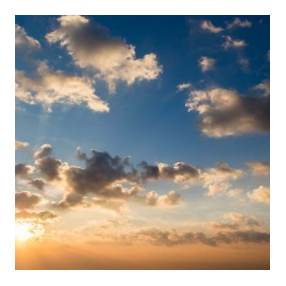

Processing 1 images
image                    shape: (473, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



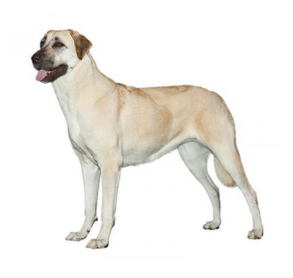

Processing 1 images
image                    shape: (244, 207, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  122.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



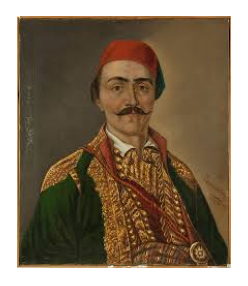

Processing 1 images
image                    shape: (1461, 1500, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1500.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



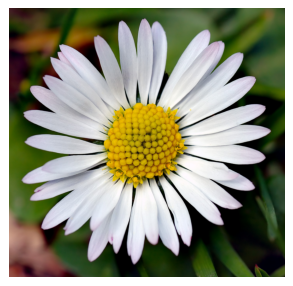

Processing 1 images
image                    shape: (563, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  563.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



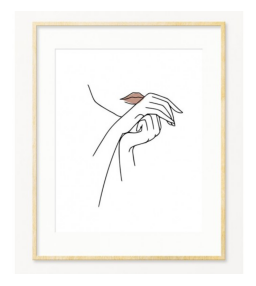

Processing 1 images
image                    shape: (168, 299, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



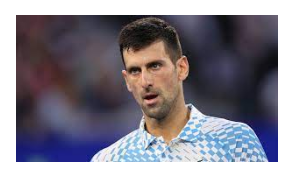

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


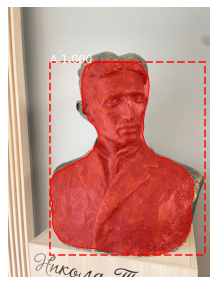

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


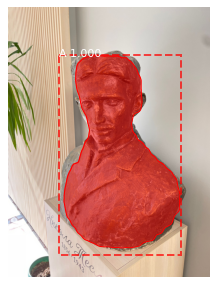

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


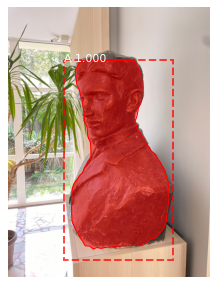

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


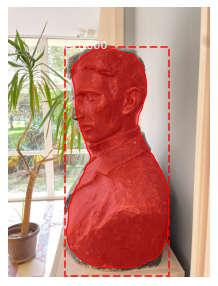

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


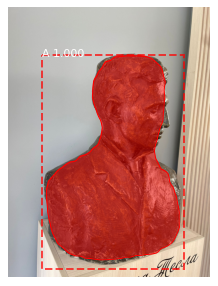

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


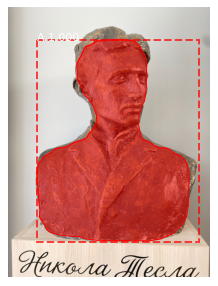

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


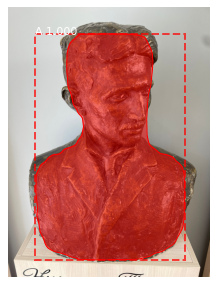

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


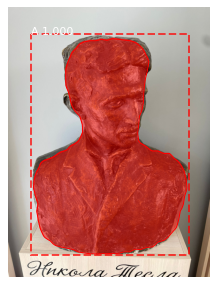

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


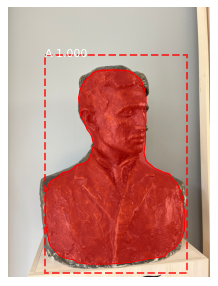

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


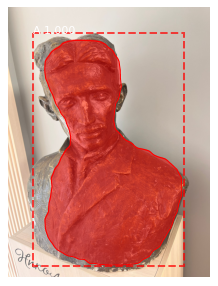

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



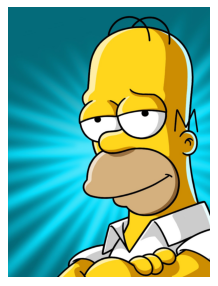

Processing 1 images
image                    shape: (308, 350, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



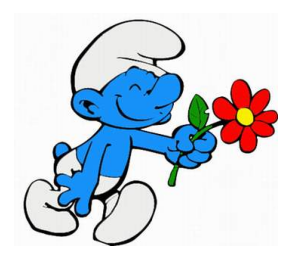

In [76]:
import skimage
real_test_dir = 'C:/Users/andre/anaconda3/envs/miep/Mask_RCNN/dataset/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [77]:
#Average Precision (mAP)

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 5)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                          r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))

mAP:  1.0


In [78]:
#Calculating mean Average Recall (mAR)

from sklearn import metrics

def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):

    AR = []
    for iou_threshold in list_iou_thresholds:

        try:
            recall, _ = utils.compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)

            AR.append(recall)

        except:
          AR.append(0.0)
          pass

    AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
    return AUC

In [79]:
#Calculating F1-Score

def evaluate_model(dataset, model, cfg, list_iou_thresholds=None):

  if list_iou_thresholds is None: list_iou_thresholds = np.arange(0.5, 1.01, 0.1)

  APs = []
  ARs = []
  for image_id in dataset.image_ids:

    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

    scaled_image = modellib.mold_image(image, cfg)

    sample = np.expand_dims(scaled_image, 0)

    yhat = model.detect(sample, verbose=0)

    r = yhat[0]

    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.5)

    AR = compute_ar(r['rois'], gt_bbox, list_iou_thresholds)
    ARs.append(AR)
    APs.append(AP)

  mAP = np.mean(APs)
  mAR = np.mean(ARs)
  f1_score = 2 * ((mAP * mAR) / (mAP + mAR))

  print("mAP:", mAP)
  print("mAR:", mAR)
  print("F1_score:", f1_score)

evaluate_model(dataset, model, config)

mAP: 0.5131578947368421
mAR: 0.1473684210526315
F1_score: 0.22897882155588165
